In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [200]:
print("torch:", torch.__version__)
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE 

torch: 2.10.0+cu128


'cuda'

In [4]:
df = pd.read_csv("./data/nepsealpha_export_price_NTC_2021-01-03_2026-01-03_unadjusted.csv", encoding="latin1")
df.head()

Symbol        Date   Open   High    Low  Close Percent Change     Volume  \
0    NTC  2026-01-01  905.0  909.0  902.2  905.0         0.00 %  74,592.00   
1    NTC  2025-12-31  909.0  909.0  900.0  905.0         0.02 %  40,304.00   
2    NTC  2025-12-29  908.0  911.0  898.0  904.8        -0.13 %  38,244.00   
3    NTC  2025-12-28  909.9  909.9  896.0  906.0         1.18 %  38,661.00   
4    NTC  2025-12-24  916.9  916.9  890.0  895.4        -0.40 %  39,968.00   

       Turn Over  
0  67,568,456.30  
1  36,498,409.60  
2  34,636,425.70  
3  34,912,329.80  
4  35,856,692.70

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# df.drop("Percent Change",axis=1,inplace=True)
# df.drop("Volume",axis=1,inplace=True)
df.drop("Symbol",axis=1,inplace=True)
df.drop("Turn Over",axis=1,inplace=True)

In [7]:
df['Percent Change'] = df['Percent Change'].str.replace('%', '').astype(float) / 100
df['price_change'] = df['Percent Change'] * df['Close']

In [8]:
df['price_change'] = df['price_change'].round(1)
df.drop("Percent Change",axis=1,inplace=True)

In [9]:
df.head()

Date   Open   High    Low  Close     Volume  price_change
0 2026-01-01  905.0  909.0  902.2  905.0  74,592.00           0.0
1 2025-12-31  909.0  909.0  900.0  905.0  40,304.00           0.2
2 2025-12-29  908.0  911.0  898.0  904.8  38,244.00          -1.2
3 2025-12-28  909.9  909.9  896.0  906.0  38,661.00          10.7
4 2025-12-24  916.9  916.9  890.0  895.4  39,968.00          -3.6

In [10]:
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = df['Volume'].replace('-', 0) # Replace hyphens with NaN
df['Volume'] = pd.to_numeric(df['Volume'])

In [11]:
df

Date    Open    High     Low   Close   Volume  price_change
0    2026-01-01   905.0   909.0   902.2   905.0  74592.0           0.0
1    2025-12-31   909.0   909.0   900.0   905.0  40304.0           0.2
2    2025-12-29   908.0   911.0   898.0   904.8  38244.0          -1.2
3    2025-12-28   909.9   909.9   896.0   906.0  38661.0          10.7
4    2025-12-24   916.9   916.9   890.0   895.4  39968.0          -3.6
...         ...     ...     ...     ...     ...      ...           ...
1161 2021-01-07  1282.0  1295.0  1263.0  1268.0      0.0          -0.3
1162 2021-01-06  1300.0  1300.0  1277.0  1288.0      0.0           0.1
1163 2021-01-05  1250.0  1306.0  1250.0  1275.0      0.0          -0.1
1164 2021-01-04  1320.0  1346.0  1270.0  1291.0      0.0          -0.1
1165 2021-01-03  1235.0  1304.0  1225.0  1302.0      0.0           1.0

[1166 rows x 7 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


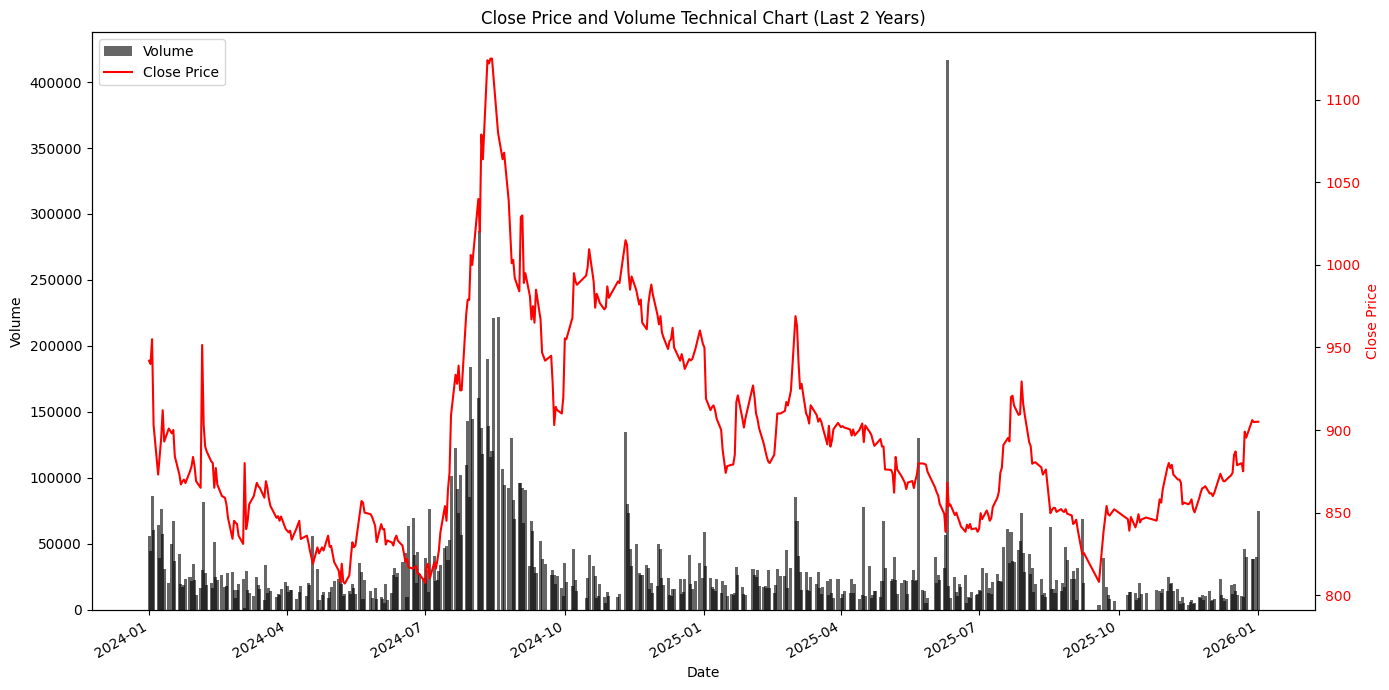

In [13]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Date
df_sorted = df.sort_values(by='Date').copy()

# Filter for the last 2 years of data
end_date = df_sorted['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
df_filtered = df_sorted[(df_sorted['Date'] >= start_date) & (df_sorted['Date'] <= end_date)]

# Create figure and primary axes for Volume
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Volume as a bar chart on ax1
ax1.bar(df_filtered['Date'], df_filtered['Volume'], color='black', alpha=0.6, label='Volume', width=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Close price
ax2 = ax1.twinx()

# Plot Close price as a line chart on ax2
ax2.plot(df_filtered['Date'], df_filtered['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set chart title and legends
plt.title('Close Price and Volume Technical Chart (Last 2 Years)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [14]:
df_long = df.melt(
    id_vars=["Date"],
    value_vars=["Open", "High", "Low", "Close","Volume","price_change"],
    var_name="unique_id",
    value_name="y"
).rename(columns={"Date": "ds"})

In [15]:
df_long.head()

ds unique_id      y
0 2026-01-01      Open  905.0
1 2025-12-31      Open  909.0
2 2025-12-29      Open  908.0
3 2025-12-28      Open  909.9
4 2025-12-24      Open  916.9

In [16]:
df_long = (
    df_long
    .groupby(['ds', 'unique_id'], as_index=False)['y']
    .mean()
)


In [17]:
df_long

ds     unique_id        y
0    2021-01-03         Close   1302.0
1    2021-01-03          High   1304.0
2    2021-01-03           Low   1225.0
3    2021-01-03          Open   1235.0
4    2021-01-03        Volume      0.0
...         ...           ...      ...
6991 2026-01-01          High    909.0
6992 2026-01-01           Low    902.2
6993 2026-01-01          Open    905.0
6994 2026-01-01        Volume  74592.0
6995 2026-01-01  price_change      0.0

[6996 rows x 3 columns]

In [18]:
df_long.info

<bound method DataFrame.info of              ds     unique_id        y
0    2021-01-03         Close   1302.0
1    2021-01-03          High   1304.0
2    2021-01-03           Low   1225.0
3    2021-01-03          Open   1235.0
4    2021-01-03        Volume      0.0
...         ...           ...      ...
6991 2026-01-01          High    909.0
6992 2026-01-01           Low    902.2
6993 2026-01-01          Open    905.0
6994 2026-01-01        Volume  74592.0
6995 2026-01-01  price_change      0.0

[6996 rows x 3 columns]>

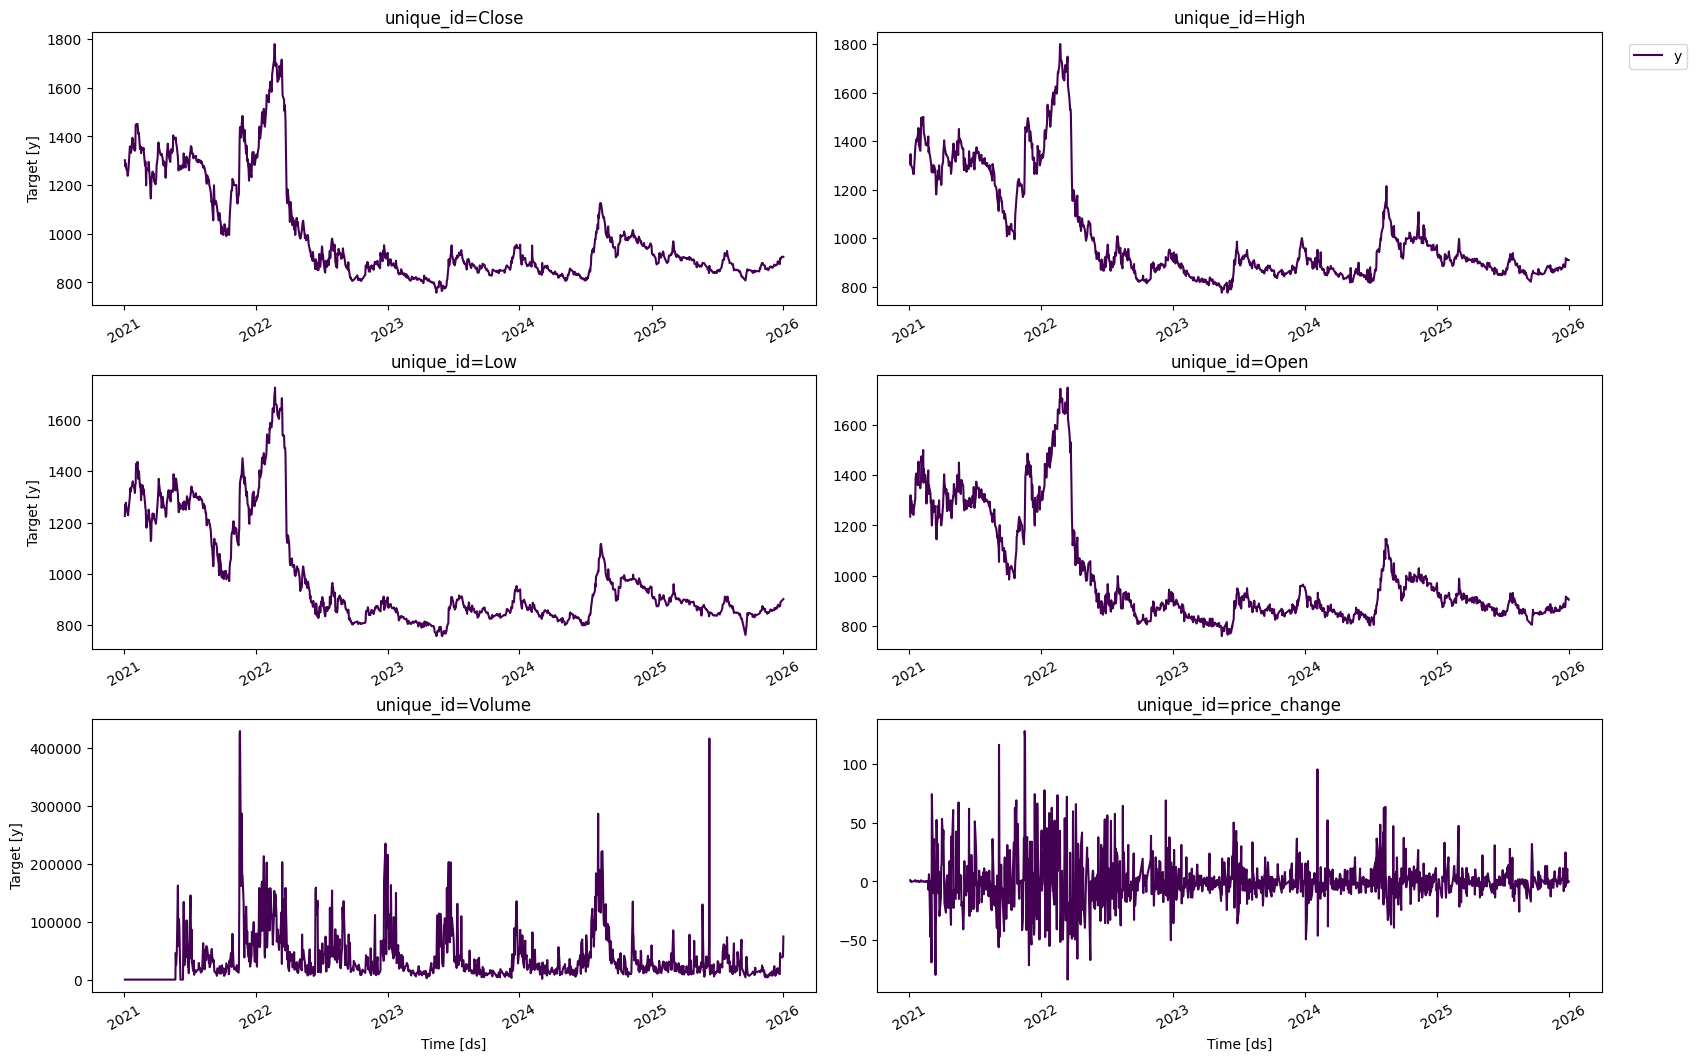

In [19]:
plot_series(df=df_long, palette="viridis")

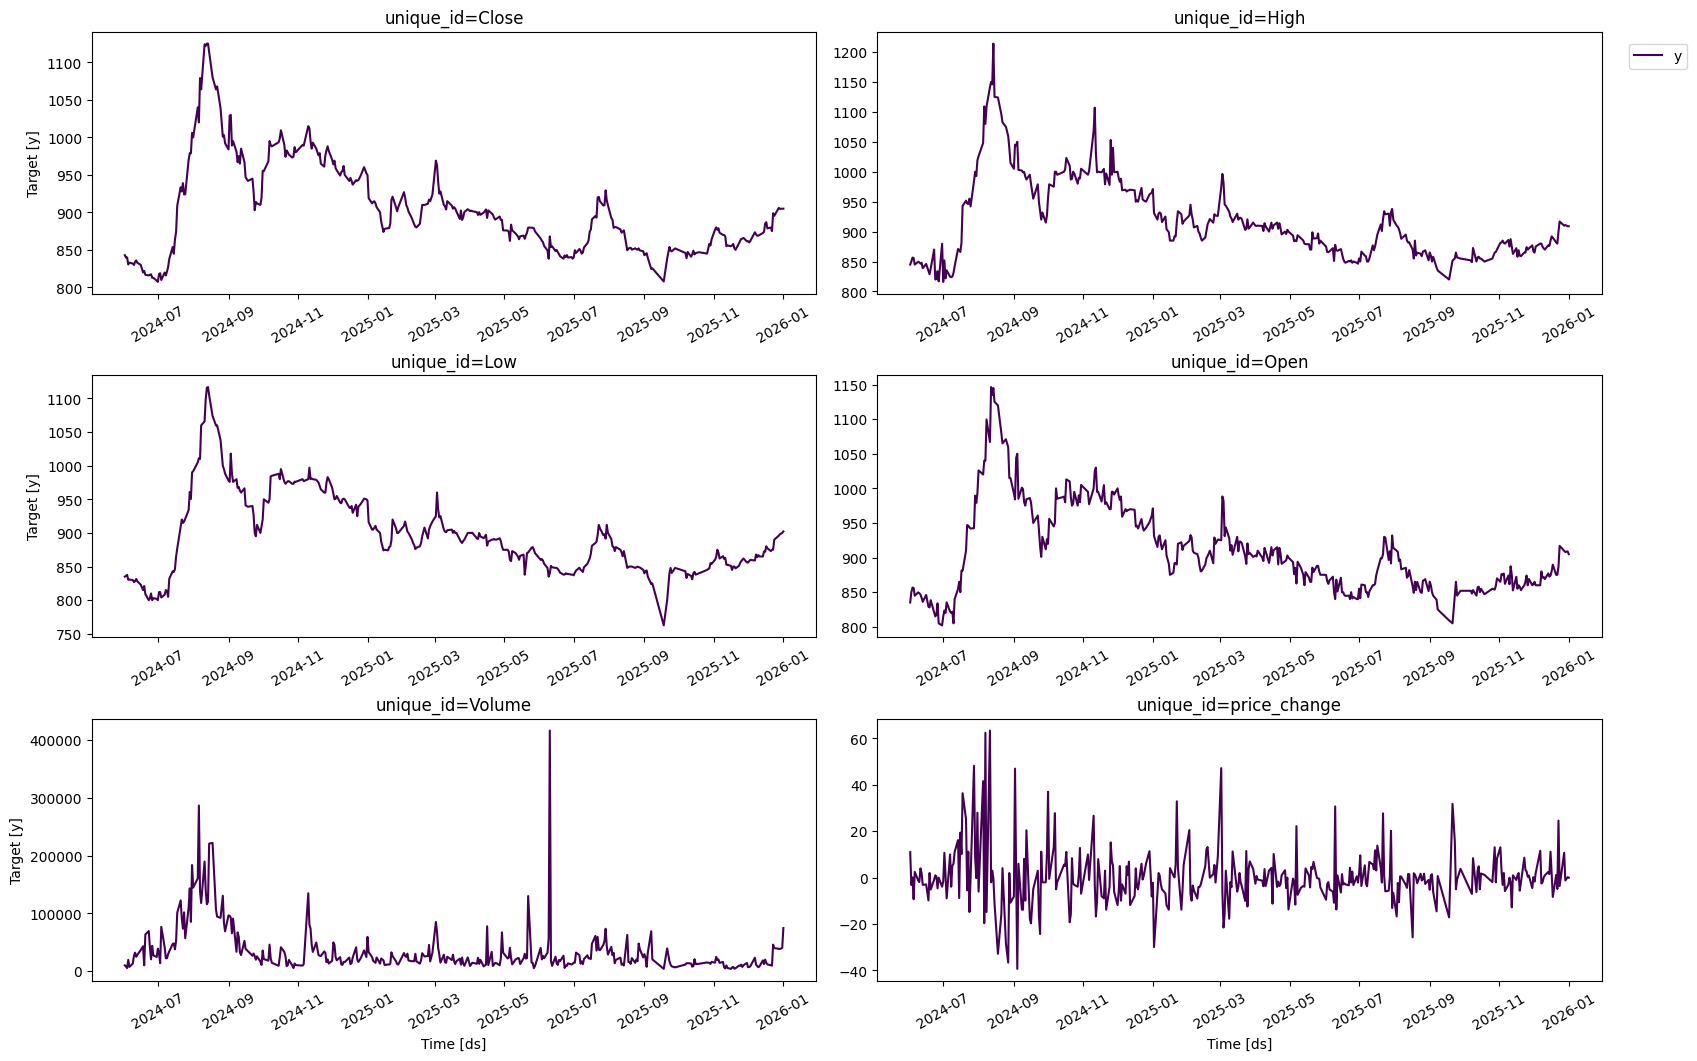

In [20]:
plot_series(df=df_long, max_insample_length=30*12, palette="viridis")

Time Series Decomposition

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

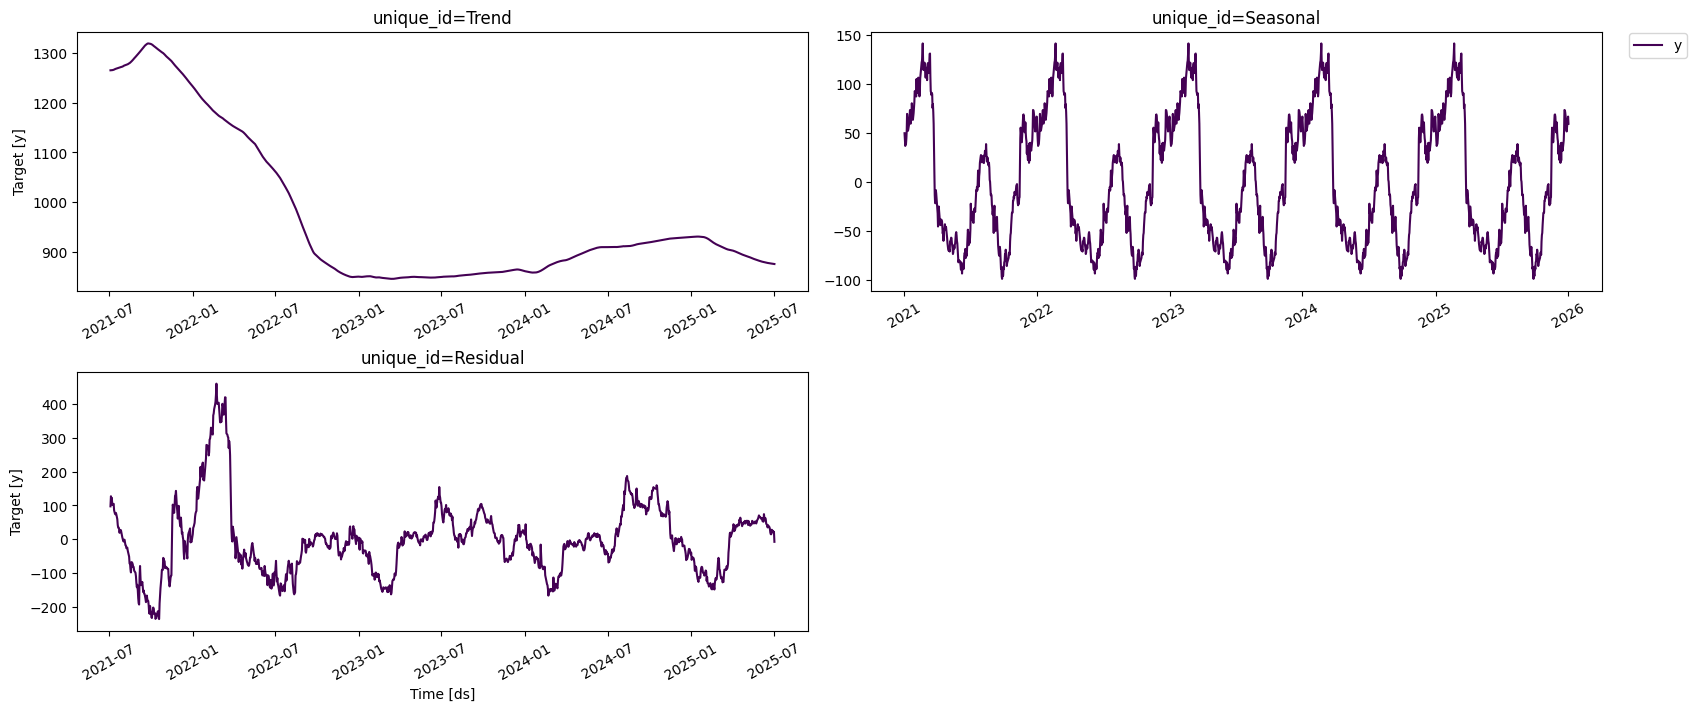

In [22]:
var = "Close"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

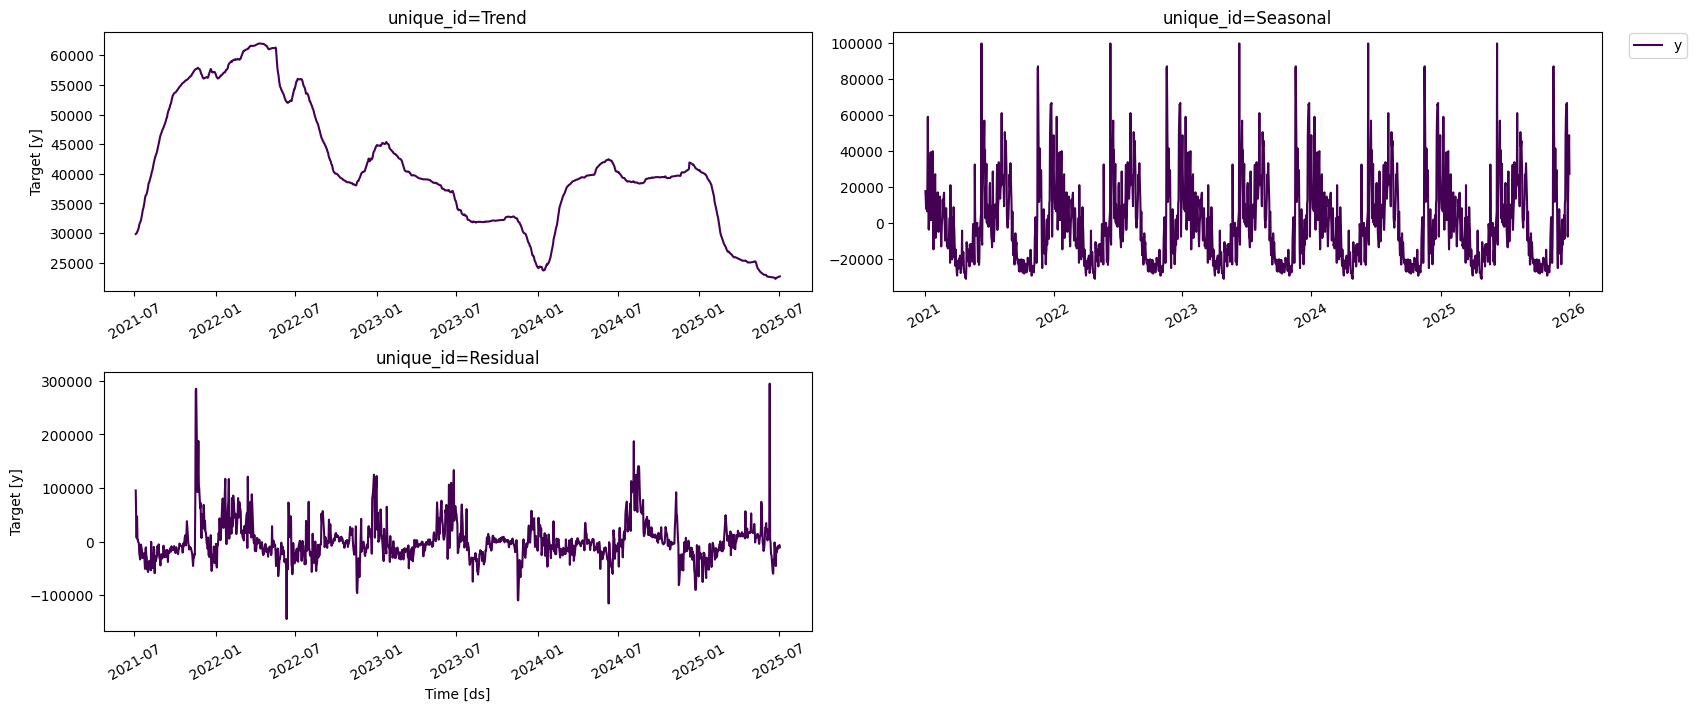

In [23]:
var = "Volume"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D")
    .interpolate(method="linear")
)

result = seasonal_decompose(ts, model="additive", period=365)

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365,
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

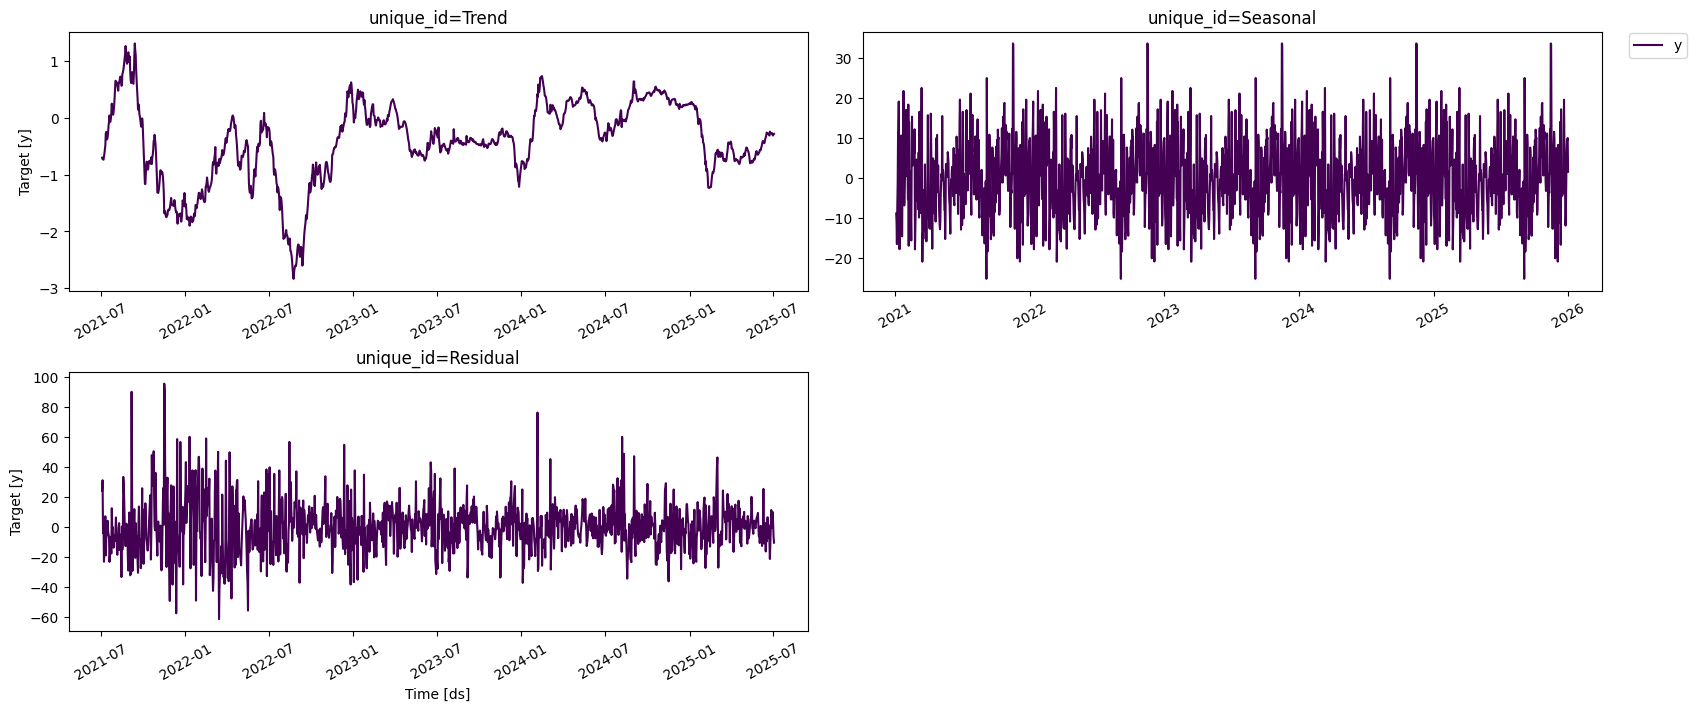

In [24]:
var = "price_change"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

In [25]:
df.head()

Date   Open   High    Low  Close   Volume  price_change
0 2026-01-01  905.0  909.0  902.2  905.0  74592.0           0.0
1 2025-12-31  909.0  909.0  900.0  905.0  40304.0           0.2
2 2025-12-29  908.0  911.0  898.0  904.8  38244.0          -1.2
3 2025-12-28  909.9  909.9  896.0  906.0  38661.0          10.7
4 2025-12-24  916.9  916.9  890.0  895.4  39968.0          -3.6

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


In [27]:
df.index = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [28]:
df.head()

Date   Open   High    Low  Close   Volume  price_change
Date                                                                    
2026-01-01 2026-01-01  905.0  909.0  902.2  905.0  74592.0           0.0
2025-12-31 2025-12-31  909.0  909.0  900.0  905.0  40304.0           0.2
2025-12-29 2025-12-29  908.0  911.0  898.0  904.8  38244.0          -1.2
2025-12-28 2025-12-28  909.9  909.9  896.0  906.0  38661.0          10.7
2025-12-24 2025-12-24  916.9  916.9  890.0  895.4  39968.0          -3.6

In [29]:
df['Date'] = pd.to_datetime(df['Date'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 72.9 KB


In [31]:
df.drop("Date",axis=1,inplace=True)


In [32]:
df.dropna(inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1166 non-null   float64
 1   High          1166 non-null   float64
 2   Low           1166 non-null   float64
 3   Close         1166 non-null   float64
 4   Volume        1166 non-null   float64
 5   price_change  1166 non-null   float64
dtypes: float64(6)
memory usage: 63.8 KB


In [34]:
def calculate_technical_indicators(df):
    # Calculate RSI
    def RSI(series, period):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        return 100 - (100 / (1 + RS))
    df['momentum_rsi'] = RSI(df['Close'],14)
    
    # Calculate SMA
    df['trend_sma_fast'] = df['Close'].rolling(window=10).mean()
    
    # Calculate WMA
    weights = np.arange(1, 11)
    df['wma'] = df['Close'].rolling(10).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Calculate Momentum
    df['momentum'] = df['Close'].diff(10)
    
    # Calculate MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['trend_macd'] = df['EMA12'] - df['EMA26']
    
    # Calculate Stochastic Oscillator K% and D%
    low_min = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['stoch_k'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Calculate William's %R
    df['momentum_wr'] = -100 * (high_max - df['Close']) / (high_max - low_min)
    
    # Calculate CCI
    TP = (df['Close'] + df['High'] + df['Low']) / 3
    df['trend_cci'] = (TP - TP.rolling(window=20).mean()) / (0.015 * TP.rolling(window=20).std())
    
    # Calculate A/D Oscillator
    df['volume_adi'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    
    # Calculate HMA
    def WMA(series, window):
        weights = np.arange(1, window + 1)
        return series.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    def HMA(series, window):
        half_length = int(window / 2)
        sqrt_length = int(np.sqrt(window))
        WMA_half = WMA(series, half_length)
        WMA_full = WMA(series, window)
        HMA = WMA(2 * WMA_half - WMA_full, sqrt_length)
        return HMA
    
    df['hma'] = HMA(df['Close'], 10)
    
    return df

# Calculate technical indicators
dataframe = calculate_technical_indicators(df)

# Display the first few rows with technical indicators
dataframe

Open    High     Low   Close   Volume  price_change  \
Date                                                                
2026-01-01   905.0   909.0   902.2   905.0  74592.0           0.0   
2025-12-31   909.0   909.0   900.0   905.0  40304.0           0.2   
2025-12-29   908.0   911.0   898.0   904.8  38244.0          -1.2   
2025-12-28   909.9   909.9   896.0   906.0  38661.0          10.7   
2025-12-24   916.9   916.9   890.0   895.4  39968.0          -3.6   
...            ...     ...     ...     ...      ...           ...   
2021-01-07  1282.0  1295.0  1263.0  1268.0      0.0          -0.3   
2021-01-06  1300.0  1300.0  1277.0  1288.0      0.0           0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0      0.0          -0.1   
2021-01-04  1320.0  1346.0  1270.0  1291.0      0.0          -0.1   
2021-01-03  1235.0  1304.0  1225.0  1302.0      0.0           1.0   

            momentum_rsi  trend_sma_fast          wma  momentum        EMA12  \
Date                                                                           
2026-01-01           NaN             NaN          NaN       NaN   905.000000   
2025-12-31           NaN             NaN          NaN       NaN   905.000000   
2025-12-29           NaN             NaN          NaN       NaN   904.969231   
2025-12-28           NaN             NaN          NaN       NaN   905.127811   
2025-12-24           NaN             NaN          NaN       NaN   903.631224   
...                  ...             ...          ...       ...          ...   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  1302.154631   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  1299.976996   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  1296.134381   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  1295.344476   
2021-01-03     34.666667          1279.2  1278.800000     -52.0  1296.368403   

                  EMA26  trend_macd    stoch_k    stoch_d  momentum_wr  \
Date                                                                     
2026-01-01   905.000000    0.000000        NaN        NaN          NaN   
2025-12-31   905.000000    0.000000        NaN        NaN          NaN   
2025-12-29   904.985185   -0.015954        NaN        NaN          NaN   
2025-12-28   905.060357    0.067454        NaN        NaN          NaN   
2025-12-24   904.344775   -0.713550        NaN        NaN          NaN   
...                 ...         ...        ...        ...          ...   
2021-01-07  1326.547745  -24.393114  17.699115  11.356932   -82.300885   
2021-01-06  1323.692357  -23.715361  26.548673  18.731563   -73.451327   
2021-01-05  1320.085516  -23.951135  23.857868  22.701885   -76.142132   
2021-01-04  1317.931033  -22.586557  31.979695  27.462079   -68.020305   
2021-01-03  1316.750956  -20.382553  42.307692  32.715085   -57.692308   

            trend_cci  volume_adi          hma  
Date                                            
2026-01-01        NaN   -0.176471          NaN  
2025-12-31        NaN    0.111111          NaN  
2025-12-29        NaN    0.046154          NaN  
2025-12-28        NaN    0.438849          NaN  
2025-12-24        NaN   -0.598513          NaN  
...               ...         ...          ...  
2021-01-07 -78.068195   -0.687500  1231.169697  
2021-01-06 -58.618604   -0.043478  1242.494949  
2021-01-05 -67.292947   -0.107143  1257.898990  
2021-01-04 -30.859961   -0.447368  1274.926263  
2021-01-03 -58.366514    0.949367  1290.140404  

[1166 rows x 19 columns]

In [35]:
dataframe.dropna(inplace=True)
dataframe

Open    High     Low   Close   Volume  price_change  \
Date                                                                
2025-12-02   865.0   865.0   858.1   860.0   7090.0          -1.7   
2025-12-01   861.5   867.0   856.0   861.7   6734.0           0.2   
2025-11-30   860.0   877.0   856.0   861.5  14037.0          -4.5   
2025-11-27   869.0   871.9   862.0   866.0  10215.0           0.9   
2025-11-26   860.0   870.0   860.0   865.1   7244.0           0.4   
...            ...     ...     ...     ...      ...           ...   
2021-01-07  1282.0  1295.0  1263.0  1268.0      0.0          -0.3   
2021-01-06  1300.0  1300.0  1277.0  1288.0      0.0           0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0      0.0          -0.1   
2021-01-04  1320.0  1346.0  1270.0  1291.0      0.0          -0.1   
2021-01-03  1235.0  1304.0  1225.0  1302.0      0.0           1.0   

            momentum_rsi  trend_sma_fast          wma  momentum        EMA12  \
Date                                                                           
2025-12-02     23.790323          870.60   867.863636     -27.0   872.720464   
2025-12-01     37.236084          868.27   866.245455     -23.3   871.025008   
2025-11-30     30.590717          867.02   865.014545     -12.5   869.559622   
2025-11-27     37.475345          866.37   864.829091      -6.5   869.011988   
2025-11-26     24.711316          865.88   864.598182      -4.9   868.410144   
...                  ...             ...          ...       ...          ...   
2021-01-07     37.012987         1300.20  1281.145455    -126.0  1302.154631   
2021-01-06     36.393443         1295.00  1278.927273     -52.0  1299.976996   
2021-01-05     36.156352         1289.30  1275.290909     -57.0  1296.134381   
2021-01-04     34.228188         1284.40  1275.600000     -49.0  1295.344476   
2021-01-03     34.666667         1279.20  1278.800000     -52.0  1296.368403   

                  EMA26  trend_macd    stoch_k    stoch_d  momentum_wr  \
Date                                                                     
2025-12-02   882.556082   -9.835618   5.604720  12.654990   -94.395280   
2025-12-01   881.011187   -9.986179  15.833333   9.585042   -84.166667   
2025-11-30   879.565914  -10.006292  15.277778  12.238610   -84.722222   
2025-11-27   878.561032   -9.549044  27.777778  19.629630   -72.222222   
2025-11-26   877.563918   -9.153775  31.379310  24.811622   -68.620690   
...                 ...         ...        ...        ...          ...   
2021-01-07  1326.547745  -24.393114  17.699115  11.356932   -82.300885   
2021-01-06  1323.692357  -23.715361  26.548673  18.731563   -73.451327   
2021-01-05  1320.085516  -23.951135  23.857868  22.701885   -76.142132   
2021-01-04  1317.931033  -22.586557  31.979695  27.462079   -68.020305   
2021-01-03  1316.750956  -20.382553  42.307692  32.715085   -57.692308   

            trend_cci  volume_adi          hma  
Date                                            
2025-12-02 -94.089608   -0.449275   865.045354  
2025-12-01 -84.222172    0.036364   862.331313  
2025-11-30 -63.857124   -0.476190   860.320303  
2025-11-27 -50.757315   -0.191919   860.326364  
2025-11-26 -57.259683    0.020000   861.704343  
...               ...         ...          ...  
2021-01-07 -78.068195   -0.687500  1231.169697  
2021-01-06 -58.618604   -0.043478  1242.494949  
2021-01-05 -67.292947   -0.107143  1257.898990  
2021-01-04 -30.859961   -0.447368  1274.926263  
2021-01-03 -58.366514    0.949367  1290.140404  

[1147 rows x 19 columns]

In [36]:
def process_indicators(df:pd.DataFrame, close:str, sma:str, wma:str, stK:str, stD:str, will:str, macd:str, rsi:str, cci:str, ad:str, momentum:str)->pd.DataFrame:
    pr_sma = []
    pr_wma = []
    pr_stK = []
    pr_stD = []
    pr_will = []
    pr_macd = []
    pr_rsi = []
    pr_cci = []
    pr_ad = []
    pr_moment = []
    prev_row = df.iloc[0]
    for i in range(0, len(df.index)):
        row = df.iloc[i]
        prev_close = prev_row[close]
        r_close = row[close]
        # SMA
        if r_close > row[sma]:
            pr_sma.append(1)
        else:
            pr_sma.append(-1)

        # WMA
        if r_close > row[wma]:
            pr_wma.append(1)
        else:
            pr_wma.append(-1)

        # stochasticK
        if row[stK] > prev_row[stK]:
            pr_stK.append(1)
        else:
            pr_stK.append(-1)
        
        # stochasticD
        if row[stD] > prev_row[stD]:
            pr_stD.append(1)
        else:
            pr_stD.append(-1)
        
        # William's oscillator
        if row[will] > prev_row[will]:
            pr_will.append(1)
        else:
            pr_will.append(-1)
        
        # MACD
        if row[macd] > prev_row[macd]:
            pr_macd.append(1)
        else:
            pr_macd.append(-1)
        
        # RSI
        if row[rsi] > 70:
            pr_rsi.append(-1)
        elif row[rsi] < 30:
            pr_rsi.append(1)
        else:
            if row[rsi] > prev_row[rsi]:
                pr_rsi.append(1)
            else:
                pr_rsi.append(-1)
        
        # cci
        if row[cci] > 200:
            pr_cci.append(-1)
        elif row[cci] < 200:
            pr_cci.append(1)
        else:
            if row[cci] > prev_row[cci]:
                pr_cci.append(1)
            else:
                pr_cci.append(-1)
        
        # A/D oscillator
        if row[ad] > prev_row[ad]:
            pr_ad.append(1)
        else:
            pr_ad.append(-1)
        
        # Momentum
        if row[momentum] >= 0:
            pr_moment.append(1)
        else:
            pr_moment.append(-1)
    
        prev_row = row
    
    df["pr_sma"] = pr_sma
    df["pr_wma"] = pr_wma
    df["pr_stK"] = pr_stK
    df["pr_stD"] = pr_stD
    df["pr_will"] = pr_will
    df["pr_macd"] = pr_macd
    df["pr_rsi"] = pr_rsi
    df["pr_cci"] = pr_cci
    df["pr_ad"] = pr_ad
    df["pr_moment"] = pr_moment

    # df = df.drop([sma, wma, stK, stD, will, macd, rsi, cci, ad, momentum], axis=1)

    return df

In [37]:
dataframe = process_indicators(dataframe,
                "Close",
                "trend_sma_fast",
                "wma",
                "stoch_k",
                "stoch_d",
                "momentum_wr",
                "trend_macd",
                "momentum_rsi",
                "trend_cci",
                "volume_adi",
                "momentum"
                )

In [38]:
dataframe.head()

Open   High    Low  Close   Volume  price_change  momentum_rsi  \
Date                                                                          
2025-12-02  865.0  865.0  858.1  860.0   7090.0          -1.7     23.790323   
2025-12-01  861.5  867.0  856.0  861.7   6734.0           0.2     37.236084   
2025-11-30  860.0  877.0  856.0  861.5  14037.0          -4.5     30.590717   
2025-11-27  869.0  871.9  862.0  866.0  10215.0           0.9     37.475345   
2025-11-26  860.0  870.0  860.0  865.1   7244.0           0.4     24.711316   

            trend_sma_fast         wma  momentum  ...  pr_sma  pr_wma  pr_stK  \
Date                                              ...                           
2025-12-02          870.60  867.863636     -27.0  ...      -1      -1      -1   
2025-12-01          868.27  866.245455     -23.3  ...      -1      -1       1   
2025-11-30          867.02  865.014545     -12.5  ...      -1      -1      -1   
2025-11-27          866.37  864.829091      -6.5  ...      -1       1       1   
2025-11-26          865.88  864.598182      -4.9  ...      -1       1       1   

            pr_stD  pr_will  pr_macd  pr_rsi  pr_cci  pr_ad  pr_moment  
Date                                                                    
2025-12-02      -1       -1       -1       1       1     -1         -1  
2025-12-01      -1        1       -1       1       1      1         -1  
2025-11-30       1       -1       -1      -1       1     -1         -1  
2025-11-27       1        1        1       1       1      1         -1  
2025-11-26       1        1        1       1       1      1         -1  

[5 rows x 29 columns]

In [39]:
def prepare_trend_array(df):
    trend_arr = []
    close_vals = df[["Close"]].values
    if len(close_vals) == 0:
        return trend_arr

    pre_val = close_vals[0]
    hh_val = pre_val
    hl_val = pre_val

    # HH, HL= 1,2 / LH, LL = 3,4 / Neut = 0

    trend_arr.append(0)
    for i in range(1, len(close_vals)):
        cur_val = close_vals[i]
        # high
        if cur_val > pre_val:
            # HH
            if cur_val >= hh_val:
                trend_arr.append(1)
                hh_val = cur_val
            # LH
            else:
                trend_arr.append(3)

        # low
        elif cur_val < pre_val:
            # HL
            if cur_val >= hl_val:
                trend_arr.append(2)
                hl_val = cur_val
            # LL
            else:
                trend_arr.append(4)

        # neut
        else:
            trend_arr.append(0)
        
        pre_val = cur_val

    if len(trend_arr) > 0:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            trend_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            trend_arr[0] = 2
    
    return trend_arr

def add_trend_columns(df: pd.DataFrame, close: str):
    hh_arr = []
    hl_arr = []
    lh_arr = []
    trend_arr = prepare_trend_array(df)

    index = 0
    for i in trend_arr:
        if i == 1:
            hh_arr.append(1)
            hl_arr.append(0)
            lh_arr.append(0)
        elif i==2:
            hh_arr.append(0)
            hl_arr.append(1)
            lh_arr.append(0)
        elif i == 3:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(1)
        elif i == 4:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(0)
        else:
            if index != 0:
                hh_arr.append(hh_arr[index-1])
                hl_arr.append(hl_arr[index-1])
                lh_arr.append(lh_arr[index-1])
            else:
                hh_arr.append(0)
                hl_arr.append(0)
                lh_arr.append(0)
        
        index += 1

    # label the first element(s) -> HL or HH
    if len(trend_arr) > 1:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            hh_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            hl_arr[0] = 1

    df["trend_hh"] = np.array(hh_arr)
    df["trend_hl"] = np.array(hl_arr)
    df["trend_lh"] = np.array(lh_arr)  

    return df    

In [40]:
dataframe = add_trend_columns(dataframe, "Close")

In [41]:
dataframe.head()

Open   High    Low  Close   Volume  price_change  momentum_rsi  \
Date                                                                          
2025-12-02  865.0  865.0  858.1  860.0   7090.0          -1.7     23.790323   
2025-12-01  861.5  867.0  856.0  861.7   6734.0           0.2     37.236084   
2025-11-30  860.0  877.0  856.0  861.5  14037.0          -4.5     30.590717   
2025-11-27  869.0  871.9  862.0  866.0  10215.0           0.9     37.475345   
2025-11-26  860.0  870.0  860.0  865.1   7244.0           0.4     24.711316   

            trend_sma_fast         wma  momentum  ...  pr_stD  pr_will  \
Date                                              ...                    
2025-12-02          870.60  867.863636     -27.0  ...      -1       -1   
2025-12-01          868.27  866.245455     -23.3  ...      -1        1   
2025-11-30          867.02  865.014545     -12.5  ...       1       -1   
2025-11-27          866.37  864.829091      -6.5  ...       1        1   
2025-11-26          865.88  864.598182      -4.9  ...       1        1   

            pr_macd  pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  \
Date                                                                        
2025-12-02       -1       1       1     -1         -1         1         0   
2025-12-01       -1       1       1      1         -1         1         0   
2025-11-30       -1      -1       1     -1         -1         0         1   
2025-11-27        1       1       1      1         -1         1         0   
2025-11-26        1       1       1      1         -1         0         1   

            trend_lh  
Date                  
2025-12-02         0  
2025-12-01         0  
2025-11-30         0  
2025-11-27         0  
2025-11-26         0  

[5 rows x 32 columns]

In [42]:
def calculate_alpha(close_df):
    mean_dif = close_df.diff().abs().sum() / (len(close_df.index) - 1)
    mean_close = close_df.mean()

    alpha = mean_dif / mean_close
    print("alpha:", alpha)
    return alpha

In [43]:
# creating the target dataset (Y data) for stop price prediction component
def add_stop_price(df, trade_window=10, alpha=0.1):
    print("Adding stop price")
    # alpha = calculate_alpha(df["Close"])
    close_vals = df[["Close"]].values
    
    # print(close_vals.shape)

    def find_max_index(values):
        index = values.argmax(axis=0)[0]
        return index

    exit_points = np.array([], dtype=int)

    for i in range(0, len(close_vals) // trade_window):
        window_values = close_vals[i*trade_window:(i+1)*trade_window]
        # pattern = [0] * len(window_values)

        max_index = find_max_index(window_values)

        max_value = window_values[max_index]
        # increase the value of the exit point
        window_values[max_index] = max_value + max_value * alpha
        
        # decrease the values of other entries
        for i in range(len(window_values)):
            if i != max_index:
                val = window_values[i]
                window_values[i] = val - val * alpha

        exit_points = np.concatenate((exit_points, window_values), axis=None)

    # add the values which are in the end that exceeds the trade_window
    if (len(close_vals) % trade_window) != 0:
        window_values = close_vals[-(len(close_vals) % trade_window):]

        # decrease the values of other entries
        for i in range(len(window_values)):
            val = window_values[i]
            window_values[i] = val - val * alpha
        
        exit_points = np.concatenate((exit_points, window_values), axis=None)

    df["stop_price"] = exit_points

    return df

In [44]:
def get_trend_change(df:pd.DataFrame, close:str):
    print("Adding trend")
    df["trend"] = df[close].diff()
    # df = df.dropna()
    # df = df.reset_index(drop=True)

    return df


In [45]:
LOOKBACK = 7
TRADE_WINDOW = 10
ALPHA = 0.0001        # paper value (0.01%)
BUFFER = 0.25         # 25% scaling buffer (paper code)

BATCH_SIZE = 64
LR = 1e-3

EPOCHS_TREND = 100
EPOCHS_PRICE = 100
EPOCHS_STOP  = 100
LAMBDA_DIR   = 0.1    # directional penalty weight

In [46]:
# calculate diff alpha
stop_alpha = calculate_alpha(dataframe["Close"])

alpha: 0.013759224446291744


In [47]:
df = dataframe.copy()

df = get_trend_change(df, "Close")
df = add_stop_price(df, TRADE_WINDOW, stop_alpha)

print(df.shape)
display(df.head())



Adding trend
Adding stop price
(1147, 34)


Open   High    Low  Close   Volume  price_change  momentum_rsi  \
Date                                                                          
2025-12-02  865.0  865.0  858.1  860.0   7090.0          -1.7     23.790323   
2025-12-01  861.5  867.0  856.0  861.7   6734.0           0.2     37.236084   
2025-11-30  860.0  877.0  856.0  861.5  14037.0          -4.5     30.590717   
2025-11-27  869.0  871.9  862.0  866.0  10215.0           0.9     37.475345   
2025-11-26  860.0  870.0  860.0  865.1   7244.0           0.4     24.711316   

            trend_sma_fast         wma  momentum  ...  pr_macd  pr_rsi  \
Date                                              ...                    
2025-12-02          870.60  867.863636     -27.0  ...       -1       1   
2025-12-01          868.27  866.245455     -23.3  ...       -1       1   
2025-11-30          867.02  865.014545     -12.5  ...       -1      -1   
2025-11-27          866.37  864.829091      -6.5  ...        1       1   
2025-11-26          865.88  864.598182      -4.9  ...        1       1   

            pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  trend  \
Date                                                                        
2025-12-02       1     -1         -1         1         0         0    NaN   
2025-12-01       1      1         -1         1         0         0    1.7   
2025-11-30       1     -1         -1         0         1         0   -0.2   
2025-11-27       1      1         -1         1         0         0    4.5   
2025-11-26       1      1         -1         0         1         0   -0.9   

            stop_price  
Date                    
2025-12-02  848.167067  
2025-12-01  849.843676  
2025-11-30  849.646428  
2025-11-27  877.915488  
2025-11-26  853.196895  

[5 rows x 34 columns]

In [209]:
df.head()

Open    High     Low   Close  Volume  price_change  \
Date                                                               
2021-01-03  1235.0  1304.0  1225.0  1302.0     0.0           1.0   
2021-01-04  1320.0  1346.0  1270.0  1291.0     0.0          -0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0     0.0          -0.1   
2021-01-06  1300.0  1300.0  1277.0  1288.0     0.0           0.1   
2021-01-07  1282.0  1295.0  1263.0  1268.0     0.0          -0.3   

            momentum_rsi  trend_sma_fast          wma  momentum  ...  pr_macd  \
Date                                                             ...            
2021-01-03     34.666667          1279.2  1278.800000     -52.0  ...        1   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  ...        1   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  ...       -1   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  ...        1   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  ...       -1   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03       1       1      1         -1         0         0         1   
2021-01-04      -1       1     -1         -1         0         0         1   
2021-01-05      -1       1     -1         -1         0         0         0   
2021-01-06      -1       1      1         -1         0         0         1   
2021-01-07       1       1     -1         -1         0         0         1   

            trend   stop_price  
Date                            
2021-01-03   11.0  1284.085490  
2021-01-04   16.0  1273.236841  
2021-01-05  -13.0  1257.456989  
2021-01-06   20.0  1270.278119  
2021-01-07   13.0  1250.553303  

[5 rows x 34 columns]

In [ ]:
df = df.copy()
df["stop_delta"] = (df["stop_price"] - df["Close"]) / df["Close"]

In [363]:
# Cell 2 — Configuration

from dataclasses import dataclass


@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    lookback_period: int = 7
    trend_detection_window: int = 1

    batch_size: int = 256
    epochs: int = 200
    lr: float = 1e-4

    # Directional penalty multiplier for trend loss
    trend_dir_penalty: float = 2000.0

    # MinMax scaling range
    scaler_min: float = -1.0
    scaler_max: float =  1.0

    # Expand min/max by 25%
    expand_range_frac: float = 0.25

cfg = Config()
cfg

Config(device='cuda', lookback_period=7, trend_detection_window=1, batch_size=256, epochs=200, lr=0.0001, trend_dir_penalty=2000.0, scaler_min=-1.0, scaler_max=1.0, expand_range_frac=0.25)

In [364]:
# Cell 3 — Validate df exists and clean it

assert "df" in globals(), "You must have a dataframe named `df` in memory before running this notebook."

required_cols = {"Close", "trend", "stop_price"}
missing = required_cols - set(df.columns)
assert not missing, f"df is missing required columns: {missing}"

df = df.sort_index()
df = df.dropna().copy()

print("df shape:", df.shape)
df.head()

df shape: (1146, 34)


Open    High     Low   Close  Volume  price_change  \
Date                                                               
2021-01-03  1235.0  1304.0  1225.0  1302.0     0.0           1.0   
2021-01-04  1320.0  1346.0  1270.0  1291.0     0.0          -0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0     0.0          -0.1   
2021-01-06  1300.0  1300.0  1277.0  1288.0     0.0           0.1   
2021-01-07  1282.0  1295.0  1263.0  1268.0     0.0          -0.3   

            momentum_rsi  trend_sma_fast          wma  momentum  ...  pr_macd  \
Date                                                             ...            
2021-01-03     34.666667          1279.2  1278.800000     -52.0  ...        1   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  ...        1   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  ...       -1   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  ...        1   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  ...       -1   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03       1       1      1         -1         0         0         1   
2021-01-04      -1       1     -1         -1         0         0         1   
2021-01-05      -1       1     -1         -1         0         0         0   
2021-01-06      -1       1      1         -1         0         0         1   
2021-01-07       1       1     -1         -1         0         0         1   

            trend   stop_price  
Date                            
2021-01-03   11.0  1284.085490  
2021-01-04   16.0  1273.236841  
2021-01-05  -13.0  1257.456989  
2021-01-06   20.0  1270.278119  
2021-01-07   13.0  1250.553303  

[5 rows x 34 columns]

In [365]:
# Cell 4 — Column sets (mirrors the original feature-splitting logic)

# Trend branch excludes these continuous indicators (if present)
NON_DISCRETE_COLS = [
    "trend_sma_fast",
    "wma",
    "stoch_k",
    "stoch_d",
    "momentum_wr",
    "trend_macd",
    "momentum_rsi",
    "trend_cci",
    "volume_adi",
    "momentum",
]

# Price branch excludes discretized pr_* features
DISCRETE_PR_COLS = [
    "pr_sma",
    "pr_wma",
    "pr_stK",
    "pr_stD",
    "pr_will",
    "pr_macd",
    "pr_rsi",
    "pr_cci",
    "pr_ad",
    "pr_moment",
]

TARGET_COLS = ["trend", "stop_price"]

feature_cols = [c for c in df.columns if c not in TARGET_COLS]
assert "Close" in feature_cols, "Close must exist in features."

trend_input_cols = [c for c in feature_cols if c not in NON_DISCRETE_COLS]
price_input_cols = [c for c in feature_cols if c not in DISCRETE_PR_COLS]

print("Total feature cols:", len(feature_cols))
print("Trend input cols:", len(trend_input_cols))
print("Price input cols:", len(price_input_cols))

missing_non_disc = [c for c in NON_DISCRETE_COLS if c not in df.columns]
missing_disc = [c for c in DISCRETE_PR_COLS if c not in df.columns]

if missing_non_disc:
    print("Missing NON_DISCRETE_COLS (ok):", missing_non_disc)
if missing_disc:
    print("Missing DISCRETE_PR_COLS (ok):", missing_disc)

Total feature cols: 32
Trend input cols: 22
Price input cols: 22


In [366]:
# Cell 5 — MinMax scaler (same behavior intent as your TF/sklearn pipeline)

class MinMaxScalerTorch:
    def __init__(self, feature_range=(-1.0, 1.0), expand_range_frac=0.25):
        self.a, self.b = feature_range
        self.expand = expand_range_frac
        self.min_ = None
        self.max_ = None

    def fit(self, X: np.ndarray):
        col_min = X.min(axis=0)
        col_max = X.max(axis=0)

        col_max = col_max + np.abs(col_max) * self.expand
        col_min = col_min - np.abs(col_min) * self.expand

        same = (col_max - col_min) == 0
        if np.any(same):
            col_max[same] = col_max[same] + 1e-6

        self.min_ = col_min.astype(np.float32)
        self.max_ = col_max.astype(np.float32)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        X01 = (X - self.min_) / (self.max_ - self.min_)
        return X01 * (self.b - self.a) + self.a

    def inverse_transform(self, X_scaled: np.ndarray) -> np.ndarray:
        X01 = (X_scaled - self.a) / (self.b - self.a)
        return X01 * (self.max_ - self.min_) + self.min_

scaler = MinMaxScalerTorch(feature_range=(cfg.scaler_min, cfg.scaler_max), expand_range_frac=cfg.expand_range_frac)

all_cols = list(df.columns)
X_all = df[all_cols].values.astype(np.float32)

scaler.fit(X_all)
X_scaled = scaler.transform(X_all).astype(np.float32)

scaled_df = pd.DataFrame(X_scaled, columns=all_cols, index=df.index)
scaled_df.head()

Open      High       Low     Close  Volume  price_change  \
Date                                                                       
2021-01-03 -0.176598 -0.133718 -0.173044 -0.113729    -1.0     -0.202274   
2021-01-04 -0.071351 -0.083377 -0.116360 -0.127020    -1.0     -0.210611   
2021-01-05 -0.158025 -0.131321 -0.141553 -0.146353    -1.0     -0.210611   
2021-01-06 -0.096115 -0.138512 -0.107542 -0.130645    -1.0     -0.209095   
2021-01-07 -0.118403 -0.144505 -0.125177 -0.154810    -1.0     -0.212127   

            momentum_rsi  trend_sma_fast       wma  momentum  ...  pr_macd  \
Date                                                          ...            
2021-01-03     -0.485313       -0.097649 -0.105664 -0.328766  ...      0.8   
2021-01-04     -0.493414       -0.090915 -0.109767 -0.323706  ...      0.8   
2021-01-05     -0.457792       -0.084569 -0.110163 -0.337198  ...     -0.8   
2021-01-06     -0.453412       -0.077187 -0.105501 -0.328766  ...      0.8   
2021-01-07     -0.441966       -0.070453 -0.102658 -0.453568  ...     -0.8   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03     0.8     0.8    0.8       -0.8      -1.0      -1.0       0.6   
2021-01-04    -0.8     0.8   -0.8       -0.8      -1.0      -1.0       0.6   
2021-01-05    -0.8     0.8   -0.8       -0.8      -1.0      -1.0      -1.0   
2021-01-06    -0.8     0.8    0.8       -0.8      -1.0      -1.0       0.6   
2021-01-07     0.8     0.8   -0.8       -0.8      -1.0      -1.0       0.6   

               trend  stop_price  
Date                              
2021-01-03 -0.392362   -0.145751  
2021-01-04 -0.372902   -0.158562  
2021-01-05 -0.485770   -0.177196  
2021-01-06 -0.357334   -0.162056  
2021-01-07 -0.384578   -0.185348  

[5 rows x 34 columns]

In [367]:
# Cell 6 — Build sequences (mirrors your original stop_loss_train.py logic)

from typing import List


def build_sequences(
    scaled_df: pd.DataFrame,
    feature_cols: List[str],
    trend_input_cols: List[str],
    price_input_cols: List[str],
    lookback: int,
    trend_window: int,
):
    arr = scaled_df.values.astype(np.float32)
    col_to_idx = {c: i for i, c in enumerate(scaled_df.columns)}

    close_idx = col_to_idx["Close"]
    trend_idx = col_to_idx["trend"]
    stop_idx  = col_to_idx["stop_price"]

    feat_idxs = [col_to_idx[c] for c in feature_cols]

    X_seq, X_prev_close, y_next_close, y_stop = [], [], [], []

    for i in range(lookback, len(arr)):
        X_seq.append(arr[i - lookback:i, feat_idxs])
        X_prev_close.append(arr[i - 1, close_idx])
        y_next_close.append(arr[i, close_idx])
        y_stop.append(arr[i, stop_idx])

    y_trend = []
    for i in range(lookback + trend_window, len(arr) + 1):
        y_trend.append(arr[i - trend_window:i, trend_idx])

    if trend_window > 1:
        cut = trend_window - 1
        X_seq = X_seq[:-cut]
        X_prev_close = X_prev_close[:-cut]
        y_next_close = y_next_close[:-cut]
        y_stop = y_stop[:-cut]

    X_seq = np.asarray(X_seq, dtype=np.float32)
    X_prev_close = np.asarray(X_prev_close, dtype=np.float32).reshape(-1, 1, 1)
    y_next_close = np.asarray(y_next_close, dtype=np.float32).reshape(-1, 1)
    y_stop = np.asarray(y_stop, dtype=np.float32).reshape(-1, 1)
    y_trend = np.asarray(y_trend, dtype=np.float32)  # (N, trend_window)

    feat_pos = {c: j for j, c in enumerate(feature_cols)}
    trend_positions = [feat_pos[c] for c in trend_input_cols if c in feat_pos]
    price_positions = [feat_pos[c] for c in price_input_cols if c in feat_pos]

    X_trend = X_seq[:, :, trend_positions]
    X_price = X_seq[:, :, price_positions]

    return X_price, X_trend, X_prev_close, y_stop, y_trend, y_next_close

X_price, X_trend, X_prev_close, y_stop, y_trend, y_next_close = build_sequences(
    scaled_df=scaled_df,
    feature_cols=feature_cols,
    trend_input_cols=trend_input_cols,
    price_input_cols=price_input_cols,
    lookback=cfg.lookback_period,
    trend_window=cfg.trend_detection_window,
)

print("X_price:", X_price.shape)
print("X_trend:", X_trend.shape)
print("X_prev_close:", X_prev_close.shape)
print("y_stop:", y_stop.shape)
print("y_trend:", y_trend.shape)
print("y_next_close:", y_next_close.shape)

X_price: (1139, 7, 22)
X_trend: (1139, 7, 22)
X_prev_close: (1139, 1, 1)
y_stop: (1139, 1)
y_trend: (1139, 1)
y_next_close: (1139, 1)


In [368]:
# Cell 7 — Train/Val split (time-respecting; no shuffle recommended)

N = X_price.shape[0]
split = int(N * 0.8)

train = {
    "X_price": X_price[:split],
    "X_trend": X_trend[:split],
    "X_prev":  X_prev_close[:split],
    "y_stop":  y_stop[:split],
    "y_trend": y_trend[:split],
    "y_close": y_next_close[:split],
}

val = {
    "X_price": X_price[split:],
    "X_trend": X_trend[split:],
    "X_prev":  X_prev_close[split:],
    "y_stop":  y_stop[split:],
    "y_trend": y_trend[split:],
    "y_close": y_next_close[split:],
}

print("Train N:", train["X_price"].shape[0], " Val N:", val["X_price"].shape[0])

Train N: 911  Val N: 228


In [369]:
# Cell 8 — Dataset & DataLoaders

from typing import Dict


class StopLossDataset(Dataset):
    def __init__(self, pack: Dict[str, np.ndarray]):
        self.X_price = torch.from_numpy(pack["X_price"])
        self.X_trend = torch.from_numpy(pack["X_trend"])
        self.X_prev  = torch.from_numpy(pack["X_prev"])
        self.y_stop  = torch.from_numpy(pack["y_stop"])
        self.y_trend = torch.from_numpy(pack["y_trend"])
        self.y_close = torch.from_numpy(pack["y_close"])

    def __len__(self):
        return self.X_price.shape[0]

    def __getitem__(self, idx):
        return (
            self.X_price[idx],
            self.X_trend[idx],
            self.X_prev[idx],
            self.y_stop[idx],
            self.y_trend[idx],
            self.y_close[idx],
        )

train_loader = DataLoader(StopLossDataset(train), batch_size=cfg.batch_size, shuffle=False, drop_last=False)
val_loader   = DataLoader(StopLossDataset(val),   batch_size=cfg.batch_size, shuffle=False, drop_last=False)

next(iter(train_loader))[0].shape

torch.Size([256, 7, 22])

In [370]:
import torch.nn.functional as F

In [371]:
# Cell 9 — Attention (PyTorch) [FIXED: params created on correct device]

class Attention(nn.Module):
    def __init__(self, input_dim: int, time_steps: int, return_sequences: bool = True):
        super().__init__()
        self.return_sequences = return_sequences

        self.W = nn.Parameter(torch.empty(input_dim, 1))
        self.b = nn.Parameter(torch.empty(time_steps, 1))

        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.b)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, D)
        # e = tanh(x @ W + b)
        e = torch.tanh(torch.matmul(x, self.W) + self.b)  # (B, T, 1)
        a = torch.softmax(e, dim=1)                       # (B, T, 1)
        out = x * a                                       # (B, T, D)

        if self.return_sequences:
            return out
        return out.sum(dim=1)                             # (B, D)


In [372]:
# Cell 10 — Trend Detection Branch (CNN → LSTM)

class TrendDetectBranch(nn.Module):
    def __init__(self, in_features: int, trend_window: int):
        super().__init__()
        self.trend_window = trend_window

        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=256, kernel_size=4)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.pool  = nn.MaxPool1d(kernel_size=2)

        self.lstm = None  # built dynamically after flatten size known
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, trend_window)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, F)
        x = x.transpose(1, 2)        # (B, F, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)             # (B, 128, T')
        x = torch.flatten(x, 1)      # (B, flat)

        x = x.unsqueeze(1).repeat(1, self.trend_window, 1)  # (B, trend_window, flat)

        if self.lstm is None:
            self.lstm = nn.LSTM(input_size=x.size(-1), hidden_size=320, batch_first=True).to(x.device)

        out, _ = self.lstm(x)
        out = out[:, -1, :]          # (B, 320)

        out = F.relu(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)          # (B, trend_window)
        return out

In [373]:
# Cell 11 — Price Prediction Branch (LSTM → Attention → CNN) [FIXED]

class PricePredictBranch(nn.Module):
    def __init__(self, in_features: int, time_steps: int):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=in_features, hidden_size=320, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=320, hidden_size=320, batch_first=True)
        self.dropout = nn.Dropout(p=0.01)

        # Attention now has fixed params on correct device
        self.attn = Attention(input_dim=320, time_steps=time_steps, return_sequences=True)

        self.conv = nn.Conv1d(in_channels=320, out_channels=64, kernel_size=2, padding="same")
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.fc = None  # built dynamically after flatten

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.lstm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x, _ = self.lstm2(x)
        x = F.relu(x)

        x = self.attn(x)             # (B, T, 320)

        x = x.transpose(1, 2)        # (B, 320, T)
        x = F.relu(self.conv(x))     # (B, 64, T)
        x = self.pool(x)             # (B, 64, T')
        x = torch.flatten(x, 1)      # (B, flat)

        if self.fc is None:
            self.fc = nn.Linear(x.size(-1), 1).to(x.device)

        return self.fc(x)            # (B, 1)


In [374]:
# Cell 12 — Full Stop-Loss Model [FIXED]

class StopLossModel(nn.Module):
    def __init__(self, price_in_features: int, trend_in_features: int, trend_window: int, time_steps: int):
        super().__init__()
        self.trend_window = trend_window

        self.trend_branch = TrendDetectBranch(trend_in_features, trend_window)
        self.price_branch = PricePredictBranch(price_in_features, time_steps=time_steps)

        self.dec_lstm = None
        self.dec_fc = nn.Linear(320, 1)

    def forward(self, x_price: torch.Tensor, x_trend: torch.Tensor, prev_close: torch.Tensor):
        trend_out = self.trend_branch(x_trend)   # (B, trend_window)
        price_out = self.price_branch(x_price)   # (B, 1)

        prev_flat = prev_close.view(prev_close.size(0), -1)  # (B, 1)
        concat = torch.cat([prev_flat, trend_out, price_out], dim=1)
        concat = concat.unsqueeze(1)  # (B, 1, D)

        if self.dec_lstm is None:
            self.dec_lstm = nn.LSTM(input_size=concat.size(-1), hidden_size=320, batch_first=True).to(concat.device)

        dec_out, _ = self.dec_lstm(concat)
        dec_out = dec_out[:, -1, :]

        stop_pred = self.dec_fc(dec_out)
        return stop_pred, trend_out, price_out


In [375]:
# Cell 13 — Instantiate model + sanity forward

model = StopLossModel(
    price_in_features=X_price.shape[-1],
    trend_in_features=X_trend.shape[-1],
    trend_window=cfg.trend_detection_window,
    time_steps=X_price.shape[1],
).to(cfg.device)

batch = next(iter(train_loader))
xb_price, xb_trend, xb_prev, yb_stop, yb_trend, yb_close = [t.to(cfg.device) for t in batch]

with torch.no_grad():
    stop_pred, trend_pred, price_pred = model(xb_price, xb_trend, xb_prev)

print("stop_pred:", stop_pred.shape)
print("trend_pred:", trend_pred.shape)
print("price_pred:", price_pred.shape)

stop_pred: torch.Size([256, 1])
trend_pred: torch.Size([256, 1])
price_pred: torch.Size([256, 1])


## Loss functions

- Stop price: MSE
- Next-step Close: MSE
- Trend: directional penalty (ported from your TensorFlow `custom_loss`)

This loss compares consecutive samples in batch, so we keep `shuffle=False`.


In [376]:
# Cell 14 — Losses

mse = nn.MSELoss()

def trend_custom_loss(y_true: torch.Tensor, y_pred: torch.Tensor, alpha: float = 2000.0) -> torch.Tensor:
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(1)
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)

    if y_true.size(0) < 2:
        return mse(y_pred, y_true)

    yt_next = y_true[1:]
    yp_next = y_pred[1:]
    yt_tdy  = y_true[:-1]
    yp_tdy  = y_pred[:-1]

    yt_diff = yt_next - yt_tdy
    yp_diff = yp_next - yp_tdy

    yt_move = (yt_diff >= 0)
    yp_move = (yp_diff >= 0)

    mismatch = (yt_move != yp_move).any(dim=1)  # (B-1,)

    weights = torch.ones((y_true.size(0), 1), device=y_true.device)
    weights[1:][mismatch] = alpha

    loss = ((y_true - y_pred) ** 2) * weights
    return loss.mean()

In [377]:
# Cell 15 — Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

In [378]:
# Cell 16 — Training loop

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = total_stop = total_trend = total_price = 0.0
    n = 0

    for batch in loader:
        xb_price, xb_trend, xb_prev, yb_stop, yb_trend, yb_close = batch
        xb_price = xb_price.to(cfg.device)
        xb_trend = xb_trend.to(cfg.device)
        xb_prev  = xb_prev.to(cfg.device)
        yb_stop  = yb_stop.to(cfg.device)
        yb_trend = yb_trend.to(cfg.device)
        yb_close = yb_close.to(cfg.device)

        if is_train:
            optimizer.zero_grad()

        stop_pred, trend_pred, price_pred = model(xb_price, xb_trend, xb_prev)

        loss_stop  = mse(stop_pred, yb_stop)
        loss_price = mse(price_pred, yb_close)
        loss_trend = trend_custom_loss(yb_trend, trend_pred, alpha=cfg.trend_dir_penalty)

        # TREND_W = 0.01
        # loss = loss_stop + loss_price + TREND_W * loss_trend
        loss = loss_stop + loss_price + loss_trend

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb_price.size(0)
        total_loss  += loss.item() * bs
        total_stop  += loss_stop.item() * bs
        total_trend += loss_trend.item() * bs
        total_price += loss_price.item() * bs
        n += bs

    return {
        "loss": total_loss / n,
        "stop_mse": total_stop / n,
        "trend_loss": total_trend / n,
        "price_mse": total_price / n,
    }

history = {"train": [], "val": []}

for epoch in range(1, cfg.epochs + 1):
    tr = run_epoch(model, train_loader, optimizer=optimizer)
    va = run_epoch(model, val_loader, optimizer=None)

    history["train"].append(tr)
    history["val"].append(va)

    if epoch == 1 or epoch % 5 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"train loss={tr['loss']:.6f} (stop={tr['stop_mse']:.6f}, trend={tr['trend_loss']:.6f}, price={tr['price_mse']:.6f}) | "
            f"val loss={va['loss']:.6f} (stop={va['stop_mse']:.6f}, trend={va['trend_loss']:.6f}, price={va['price_mse']:.6f})"
        )

Epoch 001 | train loss=218.725427 (stop=0.286782, trend=218.177178, price=0.261466) | val loss=253.674454 (stop=0.392515, trend=252.923065, price=0.358874)
Epoch 005 | train loss=175.471713 (stop=0.273661, trend=174.947949, price=0.250104) | val loss=160.614792 (stop=0.374835, trend=159.897034, price=0.342926)
Epoch 010 | train loss=58.379184 (stop=0.258140, trend=57.888500, price=0.232543) | val loss=26.783064 (stop=0.353599, trend=26.112558, price=0.316906)
Epoch 015 | train loss=8.244635 (stop=0.243778, trend=7.791049, price=0.209808) | val loss=2.193220 (stop=0.334263, trend=1.574133, price=0.284824)
Epoch 020 | train loss=7.918037 (stop=0.223977, trend=7.538124, price=0.155936) | val loss=1.436753 (stop=0.304847, trend=0.936465, price=0.195440)
Epoch 025 | train loss=3.785733 (stop=0.197955, trend=3.547247, price=0.040531) | val loss=1.537521 (stop=0.266904, trend=1.260445, price=0.010172)
Epoch 030 | train loss=4.427330 (stop=0.171509, trend=4.203207, price=0.052614) | val loss=1

In [379]:
# Cell 17 — Prediction helpers

def predict(model, loader):
    model.eval()
    stops, trends, prices = [], [], []
    ys_stop, ys_trend, ys_close = [], [], []

    with torch.no_grad():
        for batch in loader:
            xb_price, xb_trend, xb_prev, yb_stop, yb_trend, yb_close = batch
            xb_price = xb_price.to(cfg.device)
            xb_trend = xb_trend.to(cfg.device)
            xb_prev  = xb_prev.to(cfg.device)

            stop_pred, trend_pred, price_pred = model(xb_price, xb_trend, xb_prev)

            stops.append(stop_pred.cpu().numpy())
            trends.append(trend_pred.cpu().numpy())
            prices.append(price_pred.cpu().numpy())

            ys_stop.append(yb_stop.numpy())
            ys_trend.append(yb_trend.numpy())
            ys_close.append(yb_close.numpy())

    return (
        np.vstack(stops), np.vstack(trends), np.vstack(prices),
        np.vstack(ys_stop), np.vstack(ys_trend), np.vstack(ys_close),
    )

stop_p, trend_p, close_p, stop_y, trend_y, close_y = predict(model, val_loader)
print("Pred stop (scaled) head:", stop_p[:5].ravel())

Pred stop (scaled) head: [-0.5261051  -0.5232822  -0.52490664 -0.5313262  -0.53678966]


In [380]:
# Cell 18 — Inverse scaling back to real units

col_to_idx = {c: i for i, c in enumerate(all_cols)}

def inverse_single_column(pred_scaled: np.ndarray, col_name: str) -> np.ndarray:
    idx = col_to_idx[col_name]
    dummy = np.zeros((pred_scaled.shape[0], len(all_cols)), dtype=np.float32)
    dummy[:, idx] = pred_scaled.reshape(-1)
    inv = scaler.inverse_transform(dummy)
    return inv[:, idx]

stop_pred_real  = inverse_single_column(stop_p, "stop_price")
stop_true_real  = inverse_single_column(stop_y, "stop_price")

close_pred_real = inverse_single_column(close_p, "Close")
close_true_real = inverse_single_column(close_y, "Close")

print("Stop pred real head:", stop_pred_real[:5])
print("Stop true real head:", stop_true_real[:5])

Stop pred real head: [961.98846 964.379   963.0034  957.56714 952.9404 ]
Stop true real head: [1001.6955   968.4884   956.65356  950.7361   955.6673 ]


In [381]:
# Cell 19 — Simple metrics

def rmse(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    return float(np.sqrt(np.mean((a - b) ** 2)))

print("Stop RMSE:", rmse(stop_pred_real, stop_true_real))
print("Close RMSE:", rmse(close_pred_real, close_true_real))

Stop RMSE: 27.338945388793945
Close RMSE: 16.59282112121582


In [382]:
# Cell 20 — Save model + scaler
import os
save_dir = "./py_model/stoploss_pytorch_artifacts"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "stoploss_model.pt")
scaler_path = os.path.join(save_dir, "scaler.npz")

torch.save(model.state_dict(), model_path)
np.savez(
    scaler_path,
    cols=np.array(all_cols),
    min_=scaler.min_,
    max_=scaler.max_,
    a=np.float32(cfg.scaler_min),
    b=np.float32(cfg.scaler_max),
)

print("Saved model:", model_path)
print("Saved scaler:", scaler_path)

Saved model: ./py_model/stoploss_pytorch_artifacts/stoploss_model.pt
Saved scaler: ./py_model/stoploss_pytorch_artifacts/scaler.npz


In [383]:
output_folder = "./plots/"

In [384]:
def torch_test(
    test_df: pd.DataFrame,
    model: nn.Module,
    scaler,
    lookback_period: int,
    trend_index: int = -2,          # kept for compatibility; not used directly
    stop_price_index: int = -1,     # kept for compatibility; not used directly
    device: str = None
):
    if device is None:
        device = next(model.parameters()).device.type

    model.eval()

    # --- same column logic as training ---
    NON_DISCRETE_COLS = [
        "trend_sma_fast","wma","stoch_k","stoch_d","momentum_wr",
        "trend_macd","momentum_rsi","trend_cci","volume_adi","momentum"
    ]
    DISCRETE_PR_COLS = [
        "pr_sma","pr_wma","pr_stK","pr_stD","pr_will",
        "pr_macd","pr_rsi","pr_cci","pr_ad","pr_moment"
    ]
    TARGET_COLS = ["trend", "stop_price"]

    feature_cols = [c for c in test_df.columns if c not in TARGET_COLS]
    trend_input_cols = [c for c in feature_cols if c not in NON_DISCRETE_COLS]
    price_input_cols = [c for c in feature_cols if c not in DISCRETE_PR_COLS]

    # --- scale ---
    scaled = scaler.transform(test_df.values.astype(np.float32))

    col_to_idx = {c: i for i, c in enumerate(test_df.columns)}
    close_idx = col_to_idx["Close"]

    feat_idxs = [col_to_idx[c] for c in feature_cols]

    X_seq, prev_close = [], []
    for i in range(lookback_period, len(scaled)):
        X_seq.append(scaled[i - lookback_period:i, feat_idxs])
        prev_close.append(scaled[i - 1, close_idx])

    X_seq = np.asarray(X_seq, dtype=np.float32)                      # (N, T, F)
    prev_close = np.asarray(prev_close, dtype=np.float32).reshape(-1, 1, 1)

    feat_pos = {c: j for j, c in enumerate(feature_cols)}
    trend_pos = [feat_pos[c] for c in trend_input_cols if c in feat_pos]
    price_pos = [feat_pos[c] for c in price_input_cols if c in feat_pos]

    X_trend = X_seq[:, :, trend_pos]
    X_price = X_seq[:, :, price_pos]

    # --- tensors ---
    X_trend_t = torch.from_numpy(X_trend).to(device)
    X_price_t = torch.from_numpy(X_price).to(device)
    prev_t    = torch.from_numpy(prev_close).to(device)

    with torch.no_grad():
        stop_p, trend_p, price_p = model(X_price_t, X_trend_t, prev_t)

    stop_p = stop_p.cpu().numpy()
    price_p = price_p.cpu().numpy()

    # --- inverse scaling (single-column trick) ---
    def inverse_column(pred, col):
        dummy = np.zeros((pred.shape[0], len(test_df.columns)), dtype=np.float32)
        dummy[:, col_to_idx[col]] = pred.reshape(-1)
        return scaler.inverse_transform(dummy)[:, col_to_idx[col]]

    inv_stop  = inverse_column(stop_p, "stop_price")
    inv_price = inverse_column(price_p, "Close")

    #actual prices
    actual_prices = test_df["Close"].values
    actual_stop_prices = test_df["stop_price"].values

    # Plot
    plot(actual_prices, inv_stop, inv_price, lookback_period, output_folder)

    print(inv_stop)
    print(actual_stop_prices)

    return inv_price, inv_stop


In [385]:
def find_trend_trades(test_df, lookback_period, trade_window=10, number_of_trades=10, direction="up"):
    trade_count = 0
    trades_df = pd.DataFrame(columns=test_df.columns)
    i = 0
    while i < len(test_df.index) - (lookback_period+trade_window):
        if trade_count >= number_of_trades:
            break
        # lb_period defines the trend of the trade. last element is the value to be predicted
        end_index = i + lookback_period + trade_window
        trade_df = test_df.iloc[i:end_index]
        # Once the trade has started, it has to be of the direction given (previous data points in lookback doesn't matter)
        trend_arr = prepare_trend_array(trade_df[lookback_period-1:])
                
        trend_arr = [str(j) for j in trend_arr]
        trend_pattern = "".join(trend_arr)
        # if "43" not in trend_pattern and not trend_pattern.endswith("4") and not trend_pattern.endswith("3"):
        #     # plt.plot([i for i in range(lookback_period+1)], trade_df[["Close"]].values, color='orange', label="plt")
        #     # plt.savefig(output_folder+"plot.png")
        #     print(trend_pattern)
        # else:
        #     i += 1

        if direction == "up" and not "3" in trend_pattern[1:] and not "4" in trend_pattern[1:] and not trend_pattern.startswith("00"):
            # plt.plot([i for i in range(lookback_period+1)], trade_df[["Close"]].values, color='orange', label="plt")
            # plt.savefig(output_folder+"plot.png")
            print(trend_pattern)
            trades_df = pd.concat([trades_df, trade_df])
            i = end_index
            trade_count += 1
        elif direction == "down" and not "1" in trend_pattern[1:] and not "2" in trend_pattern[1:] and not trend_pattern.startswith("00"):
            print(trend_pattern)
            trades_df = pd.concat([trades_df, trade_df])
            i = end_index
            trade_count += 1
        else:
            i += 1

        # if "4" not in trend_pattern and "3" not in trend_pattern:
        #     # plt.plot([i for i in range(lookback_period+1)], trade_df[["Close"]].values, color='orange', label="plt")
        #     # plt.savefig(output_folder+"plot.png")
        #     print(trend_pattern)
        #     trades_df = trades_df.append(trade_df)
        #     i = end_index
        #     trade_count += 1 
        # else:
        #     i += 1
    
    return trades_df

In [386]:
def std_dev_profit(actual_prices, entering_price):
    avg_price = actual_prices.mean()
    alpha = actual_prices.std()
    stop_price = avg_price - alpha

    for price in actual_prices:
        if price <= stop_price:
            return price - entering_price
    
    return actual_prices[-1] - entering_price    # return profit from last step of the trade if stop price didn't cross


In [387]:
def fixed_stop_profit(actual_prices, entering_price, percent):
    stop_price = entering_price - entering_price * percent

    for price in actual_prices:
        if price <= stop_price:
            return price - entering_price
    
    return actual_prices[-1] - entering_price    # return profit from last step of the trade if stop price didn't cross


In [388]:
def trailing_stop_profit(actual_prices, entering_price, percent):
    stop_price = entering_price - entering_price * percent
    prev_price = entering_price

    for price in actual_prices:
        if price <= stop_price:
            return price - entering_price
        if price > prev_price:
            stop_price = price - price * percent
    
    return actual_prices[-1] - entering_price    # return profit from last step of the trade if stop price didn't cross 


In [389]:
def oracle_test(actual_prices, pred_prices, pred_stops, entering_prices, trade_window=10):
    success_count = 0
    stop_exit_count = 0
    profits_made = []
    max_profits = []
    buy_and_hold_profits = []
    std_dev_profits = []
    zero_one_percent_fixed_stop_profits = []
    zero_two_percent_fixed_stop_porfits = []
    zero_five_percent_fixed_stop_profits = []
    one_percent_fixed_stop_profits = []
    zero_one_percent_trailing_stop_profits = []
    zero_two_percent_trailing_stop_porfits = []
    zero_five_percent_trailing_stop_profits = []
    one_percent_trailing_stop_profits = []
    for i in range(len(actual_prices)):
        actual_price = actual_prices[i, :]
        pred_price = pred_prices[i,:]
        pred_stop = pred_stops[i, :]
        entering_price = entering_prices[i, 0]

        max_price_of_trade_index = actual_price.argmax(axis=0)
        max_price_of_trade = actual_price[max_price_of_trade_index]

        max_profit_of_trade = max_price_of_trade - entering_price # if negative, then this is the least loss
        max_profits.append(max_profit_of_trade)

        buy_and_hold_profits.append(actual_price[-1] - entering_price)

        # standard deviation method profits
        std_dev_profits.append(std_dev_profit(actual_price, entering_price))

        # Fixed stop-loss profits
        zero_one_percent_fixed_stop_profits.append(fixed_stop_profit(actual_price, entering_price, 0.001))
        zero_two_percent_fixed_stop_porfits.append(fixed_stop_profit(actual_price, entering_price, 0.002))
        zero_five_percent_fixed_stop_profits.append(fixed_stop_profit(actual_price, entering_price, 0.005))
        one_percent_fixed_stop_profits.append(fixed_stop_profit(actual_price, entering_price, 0.01))

        # Trailing stop-loss profits
        zero_one_percent_trailing_stop_profits.append(trailing_stop_profit(actual_price, entering_price, 0.001))
        zero_two_percent_trailing_stop_porfits.append(trailing_stop_profit(actual_price, entering_price, 0.002))
        zero_five_percent_trailing_stop_profits.append(trailing_stop_profit(actual_price, entering_price, 0.005))
        one_percent_trailing_stop_profits.append(trailing_stop_profit(actual_price, entering_price, 0.01))

        # iterate the predictions and find exit point
        exit_point = -1
        for j in range(len(pred_price)):
            price = pred_price[j]
            stop = pred_stop[j]
            if stop >= price:
                exit_point = j
                break
        
        if exit_point != -1:
            if exit_point < max_price_of_trade_index:
                profits_made.append(actual_price[exit_point] - entering_price)
            else:
                profits_made.append(max_profit_of_trade)
        else:
            profits_made.append(max_profit_of_trade)

    print("Total number of trades:", len(actual_prices))

    total_investment = np.sum(entering_prices)
    max_profit = sum(max_profits)
    actual_profit = sum(profits_made)
    bnh_profit = sum(buy_and_hold_profits)
    stdDev_profit = sum(std_dev_profits)
    z_onep_fix_profit = sum(zero_one_percent_fixed_stop_profits)
    z_twop_fix_profit = sum(zero_two_percent_fixed_stop_porfits)
    z_fivep_fix_profit = sum(zero_five_percent_fixed_stop_profits)
    onep_fix_profit = sum(one_percent_fixed_stop_profits)
    z_onep_trail_profit = sum(zero_one_percent_trailing_stop_profits)
    z_twop_trail_profit =  sum(zero_two_percent_trailing_stop_porfits)
    z_fivep_trail_profit = sum(zero_five_percent_trailing_stop_profits)
    onep_trail_profit = sum(one_percent_trailing_stop_profits)

    print("Total investment:", total_investment)

    print("Maximum profit to be made from trades:", max_profit)
    print("Actual profit made from trades:", actual_profit)
    print("Buy and Hold profit:", bnh_profit)
    print("Standard Deviation Method profit:", stdDev_profit)
    print("0.1% fixed stop_loss profit:", z_onep_fix_profit)
    print("0.2% fixed stop_loss profit:", z_twop_fix_profit)
    print("0.5% fixed stop_loss profit:", z_fivep_fix_profit)
    print("1% fixed stop_loss profit:", onep_fix_profit)
    print("0.1% trailing stop_loss profit:", z_onep_trail_profit)
    print("0.2% trailing stop_loss profit:", z_twop_trail_profit)
    print("0.5% trailing stop_loss profit:", z_fivep_trail_profit)
    print("1% trailing stop_loss profit:", onep_trail_profit)
    
    print("\nPerformance against max profit\n")

    print("Actual profit/Max profit:", actual_profit/max_profit)
    print("Buy and Hold profit/Max profit:", bnh_profit/max_profit)
    print("Standard deviation profit/Max profit:", stdDev_profit/max_profit)
    print("0.1% fixed stop_loss profit/Max profit:", z_onep_fix_profit/max_profit)
    print("0.2% fixed stop_loss profit/Max profit:", z_twop_fix_profit/max_profit)
    print("0.5% fixed stop_loss profit/Max profit:", z_fivep_fix_profit/max_profit)
    print("1% fixed stop_loss profit/Max profit:", onep_fix_profit/max_profit)
    print("0.1% trailing stop_loss profit/Max profit:", z_onep_trail_profit/max_profit)
    print("0.2% trailing stop_loss profit/Max profit:", z_twop_trail_profit/max_profit)
    print("0.5% trailing stop_loss profit/Max profit:", z_fivep_trail_profit/max_profit)
    print("1% trailing stop_loss profit/Max profit:", onep_trail_profit/max_profit)

    print("\nProfit against investment\n")
    print("Maximum profit/investment:", max_profit/total_investment)
    print("Actual profit/investment:", actual_profit/total_investment)
    print("Buy and Hold profit/investment:", bnh_profit/total_investment)
    print("Standard deviatio profit/investment:", stdDev_profit/total_investment)
    print("0.1% fixed stop_loss profit/investment:", z_onep_fix_profit/total_investment)
    print("0.2% fixed stop_loss profit/investment:", z_twop_fix_profit/total_investment)
    print("0.5% fixed stop_loss profit/investment:", z_fivep_fix_profit/total_investment)
    print("1% fixed stop_loss profit/investment:", onep_fix_profit/total_investment)
    print("0.1% trailing stop_loss profit/investment:", z_onep_trail_profit/total_investment)
    print("0.2% trailing stop_loss profit/investment:", z_twop_trail_profit/total_investment)
    print("0.5% trailing stop_loss profit/investment:", z_fivep_trail_profit/total_investment)
    print("1% trailing stop_loss profit/investment:", onep_trail_profit/total_investment)


In [390]:
import matplotlib.pyplot as plt
plot_count = 0

def plot(actual_prices, inverse_pred_stop, inverse_pred_price, lookback_period, output_folder):
    global plot_count
    plt.figure(figsize=(19.20,10.80))
    plt.plot(actual_prices, color="green", label="Lookback")
    # current actual values
    off_s = lookback_period
    off_e = len(actual_prices)
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = actual_prices[lookback_period:]
    plt.plot(xaxis, yaxis, color='red', label="Actual Closing Prices")
    # predicted stop values
    off_s = lookback_period
    off_e = len(actual_prices)
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = inverse_pred_stop
    plt.plot(xaxis, yaxis, color='blue', label="Predicted Stop Prices")
    # predicted cp values
    off_s = lookback_period
    off_e = len(actual_prices)
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = inverse_pred_price
    plt.plot(xaxis, yaxis, color='orange', label="Predicted Closing Prices")

    plt.title("Stock closing prices")
    plt.xlabel("Time")
    plt.ylabel("Stock price")
    plt.legend()
    plt.savefig(output_folder+"stop_res_fig" + str(plot_count) + ".png")

    plot_count += 1

In [391]:
def perform_directional_trades(test_df, model, scaler, lookback_period, trade_window=10, trend_index=-2, stop_price_index=-1, number_of_trades=10, direction="up"):
    actual_prices = []
    pred_prices = []
    pred_stops = []
    entering_prices = []

    trend_df = find_trend_trades(test_df, lookback_period, trade_window, number_of_trades, direction)
    trend_df = trend_df.reset_index(drop=True)
    # print(trend_df.to_string())
    print(len(trend_df.index))

    for i in range(0, number_of_trades):
        data_start_index = (i*trade_window) + (i*lookback_period)
        data_end_index = data_start_index + trade_window + lookback_period

        print(data_start_index, data_end_index)
        
        # print("start:end -", data_start_index, data_end_index)
        test_data = trend_df[data_start_index:data_end_index]
        
        pred_price, pred_stop = torch_test(test_data, model, scaler, lookback_period, trend_index, stop_price_index)
        # print(test_data["Close"][lookback_period:].values.reshape(-1, trade_window))
        entering_price = trend_df["Close"][data_start_index + lookback_period-1]
        actual_price = test_data["Close"][lookback_period:].values.reshape(-1, trade_window)
        entering_prices.append(entering_price)
        actual_prices.append(actual_price)
        pred_prices.append(pred_price)
        pred_stops.append(pred_stop)
    
    entering_prices = np.array(entering_prices)
    actual_prices = np.array(actual_prices)
    pred_prices = np.array(pred_prices)
    pred_stops = np.array(pred_stops)

    actual_prices = actual_prices.reshape(-1, trade_window)
    pred_prices = pred_prices.reshape(-1, trade_window)
    pred_stops = pred_stops.reshape(-1, trade_window)
    entering_prices = entering_prices.reshape(-1, 1)

    #successful_trades(actual_prices, pred_prices, pred_stops, entering_prices, trade_window)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    oracle_test(actual_prices, pred_prices, pred_stops, entering_prices, trade_window)

In [392]:
lookback_period = 7
trade_window = 10
test_df = dataframe.copy()

In [393]:
test_df = get_trend_change(test_df, "Close")
test_df = add_stop_price(test_df, trade_window, stop_alpha)


Adding trend
Adding stop price


In [394]:
print("Expected scaler dims:", scaler.min_.shape[0])
print("Training cols:", len(all_cols))


Expected scaler dims: 34
Training cols: 34


24443434434
24434334433
24433443444
24344343434
24434404443
24433444444
24343443334
24434433433
24343434343
24443444434
170
0 17


/tmp/ipykernel_140073/2770628684.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  trades_df = pd.concat([trades_df, trade_df])
/tmp/ipykernel_140073/2770628684.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trades_df = pd.concat([trades_df, trade_df])


[880.9794  881.93695 876.8966  875.78534 877.9923  875.26654 877.0803
 877.6876  879.0585  883.2574 ]
[856.05699318 858.02947473 858.02947473 860.98819706 890.99298237
 864.83453608 892.10811751 864.93316016 852.21065416 844.22210387
 846.19458543 833.47207942 835.34593689 834.16244796 832.38721457
 837.31841845 832.48583864]
17 34
[876.8945  872.41296 860.876   865.9939  868.7433  873.10034 874.12866
 873.8415  873.2285  872.5069 ]
[835.64180913 827.45601069 834.35969612 840.27714077 836.52942582
 837.31841845 865.75037768 827.06151438 796.88254665 814.16148504
 813.39221723 827.95899349 834.02437425 832.48583864 831.43056102
 836.59846268 861.00598451]
34 51
[907.60754 901.26917 899.5348  903.21533 907.49976 909.3083  903.2317
 906.34094 906.9846  903.40845]
[868.04968101 867.43821173 878.01071284 880.28892904 897.09447185
 928.76565107 942.19796079 897.12405907 896.66052591 902.26237352
 908.11078131 907.28233906 880.79191183 882.84329264 878.63204453
 865.19944517 886.20803883]
51 

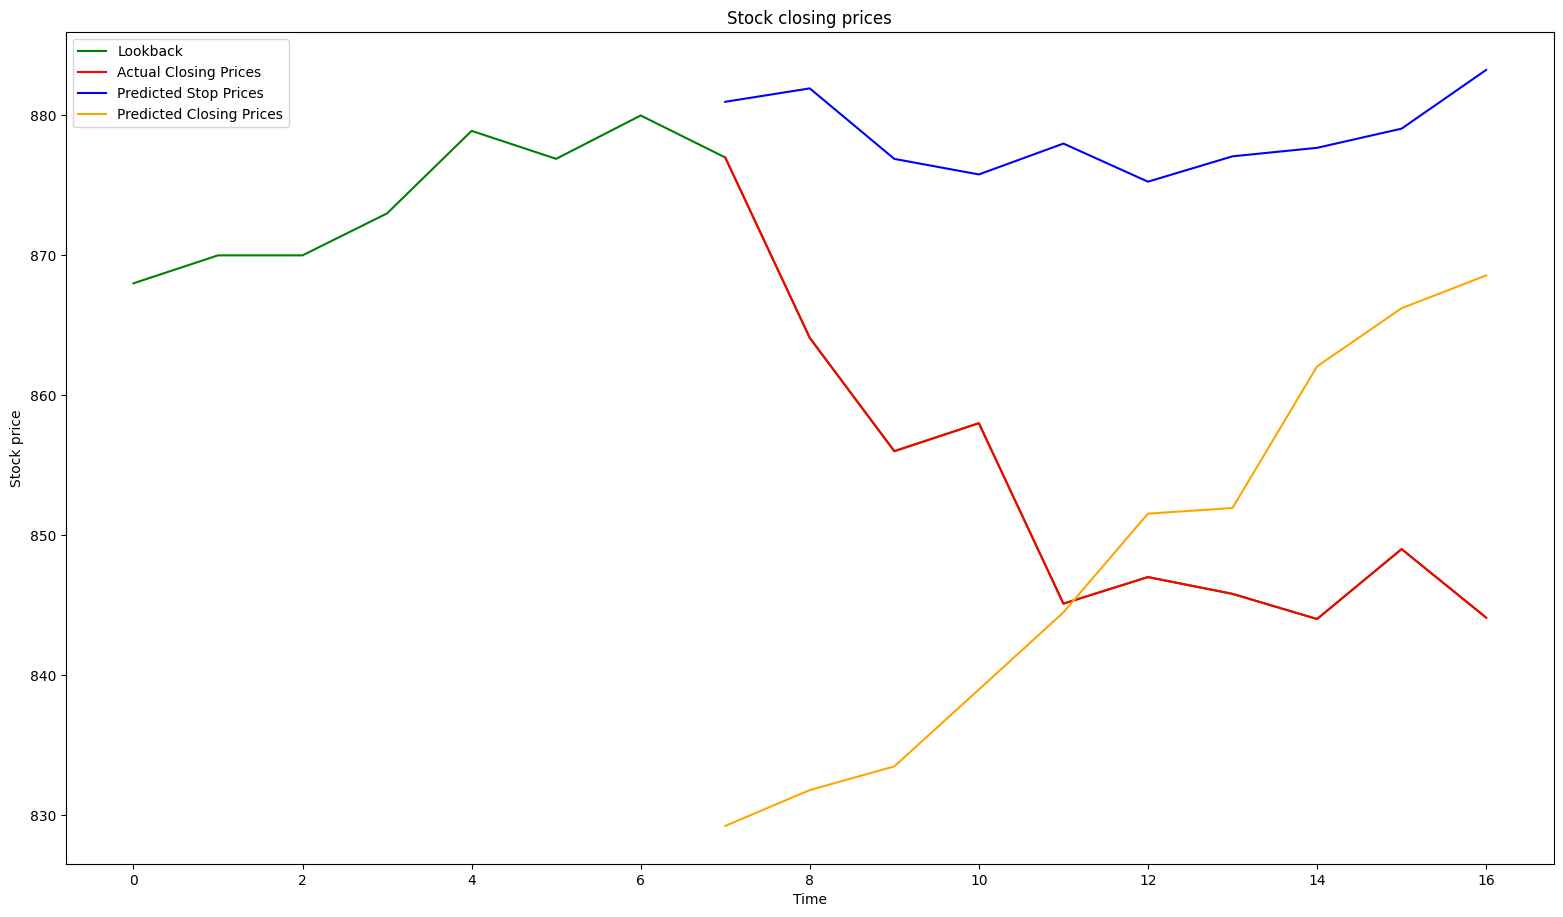

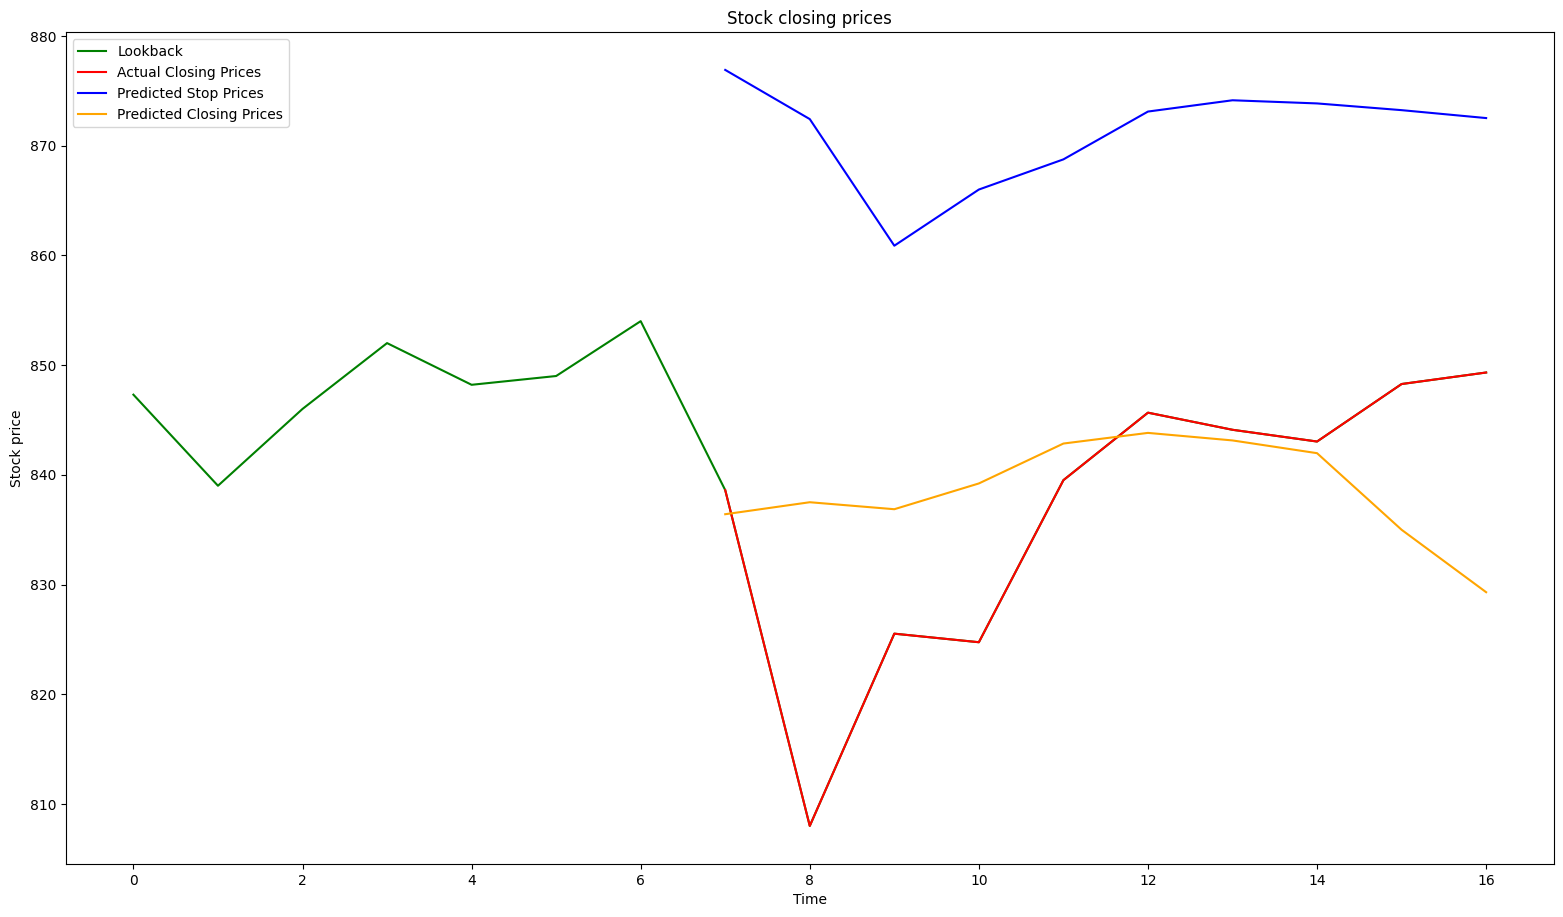

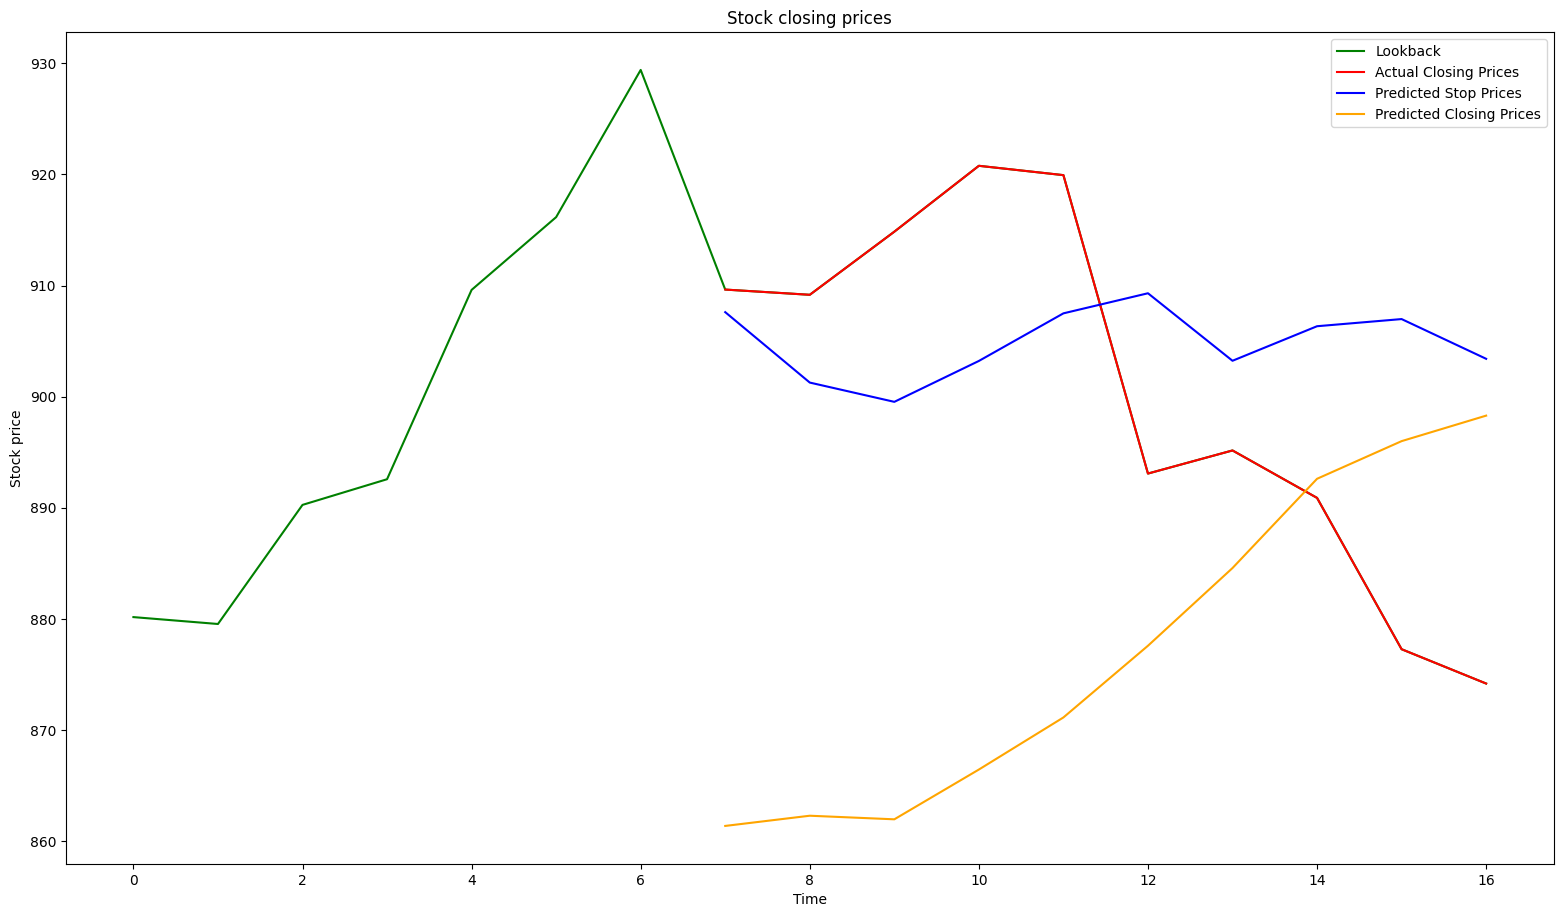

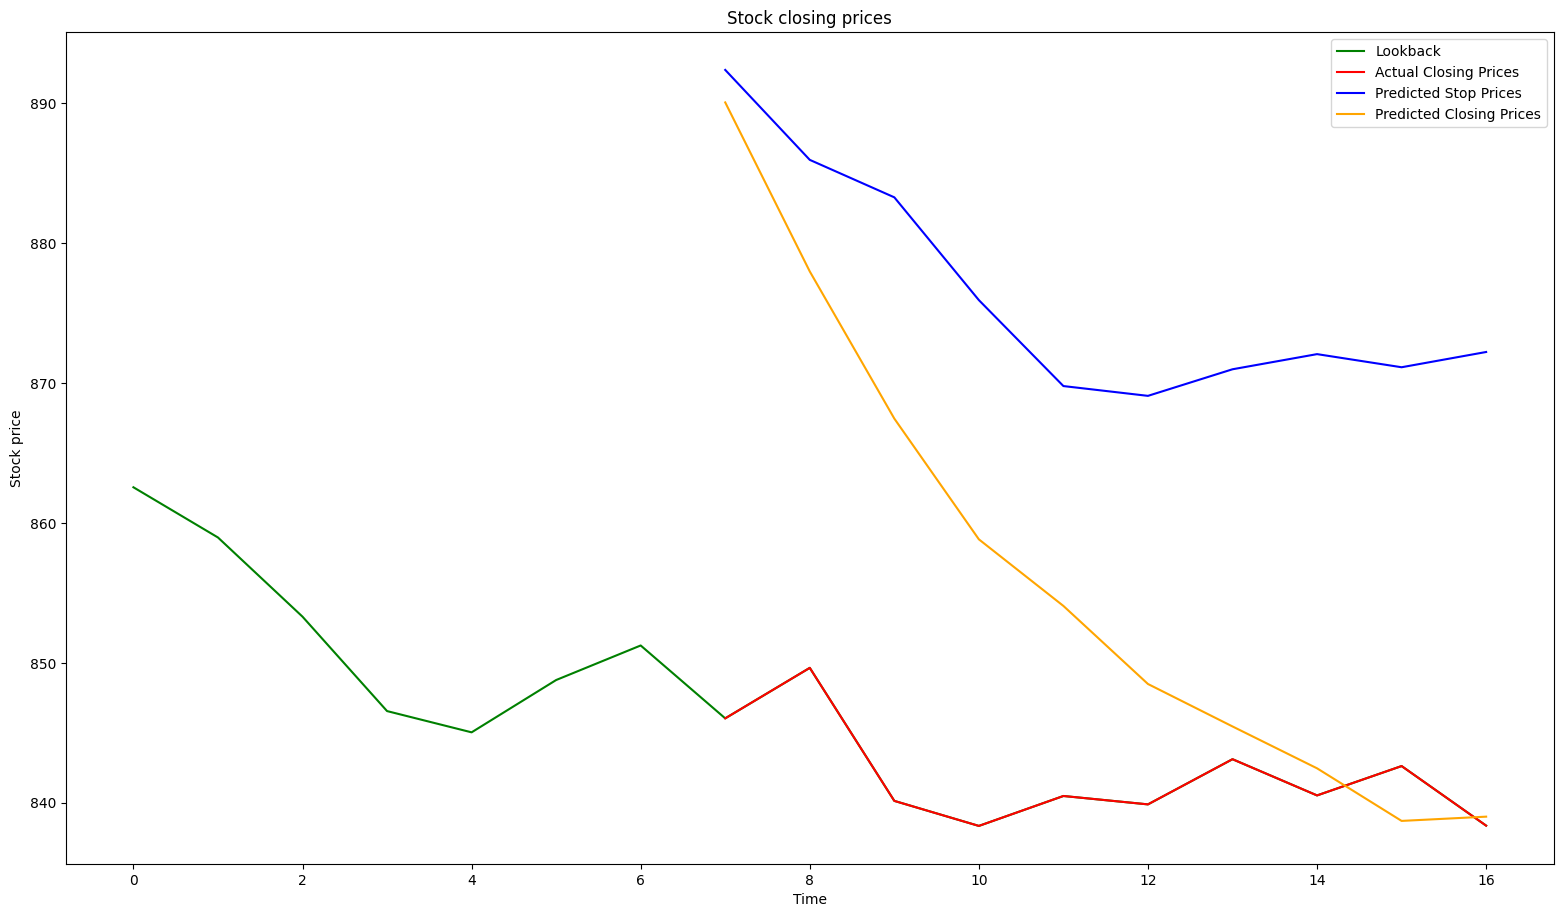

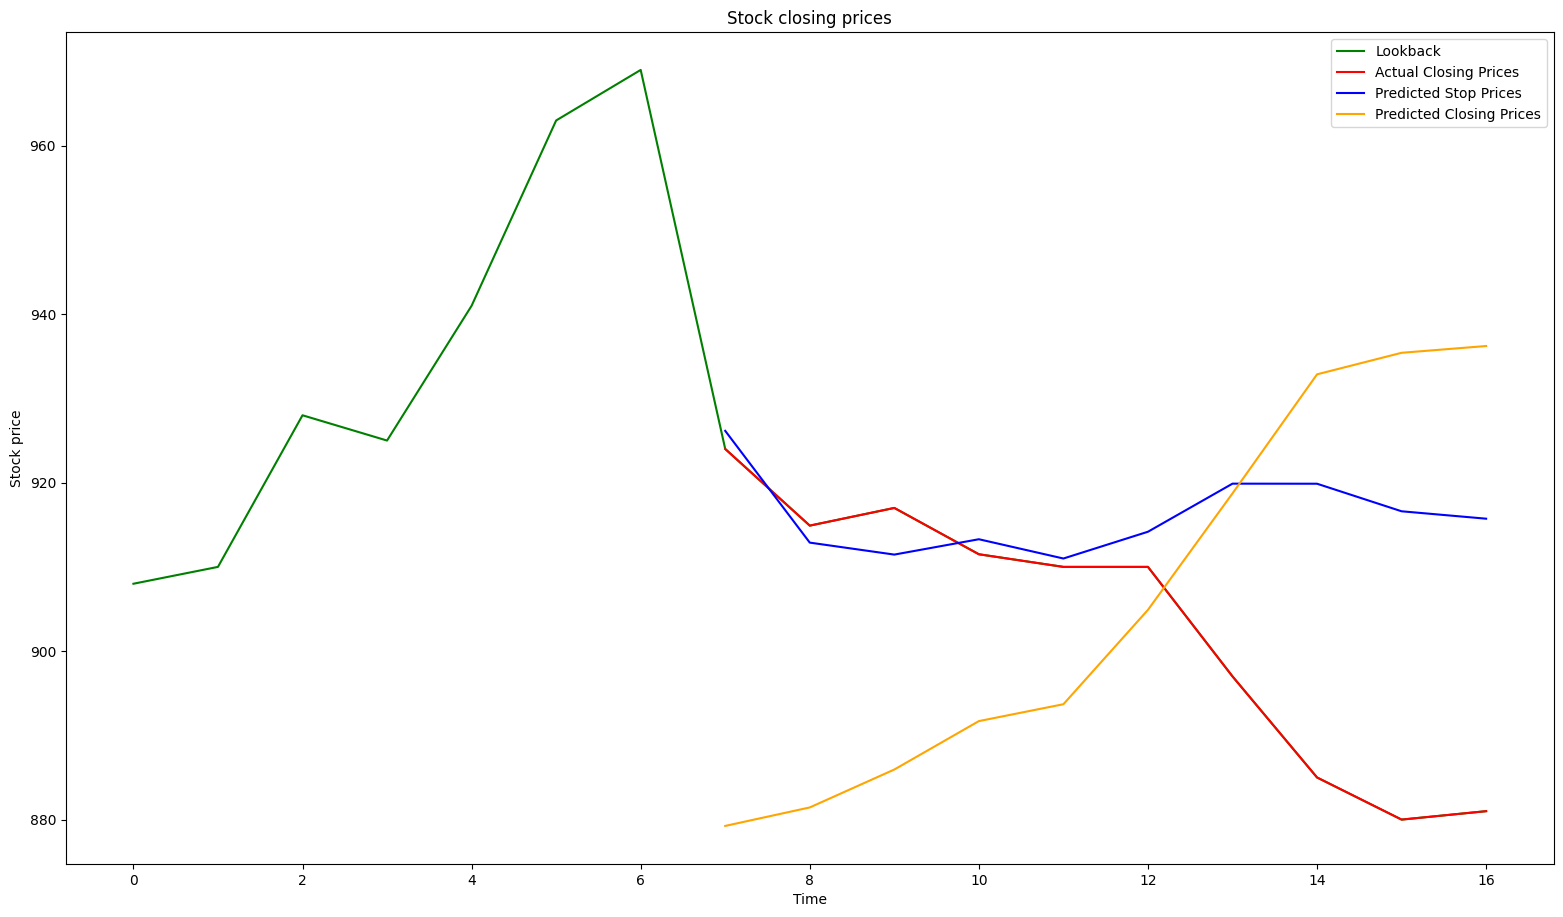

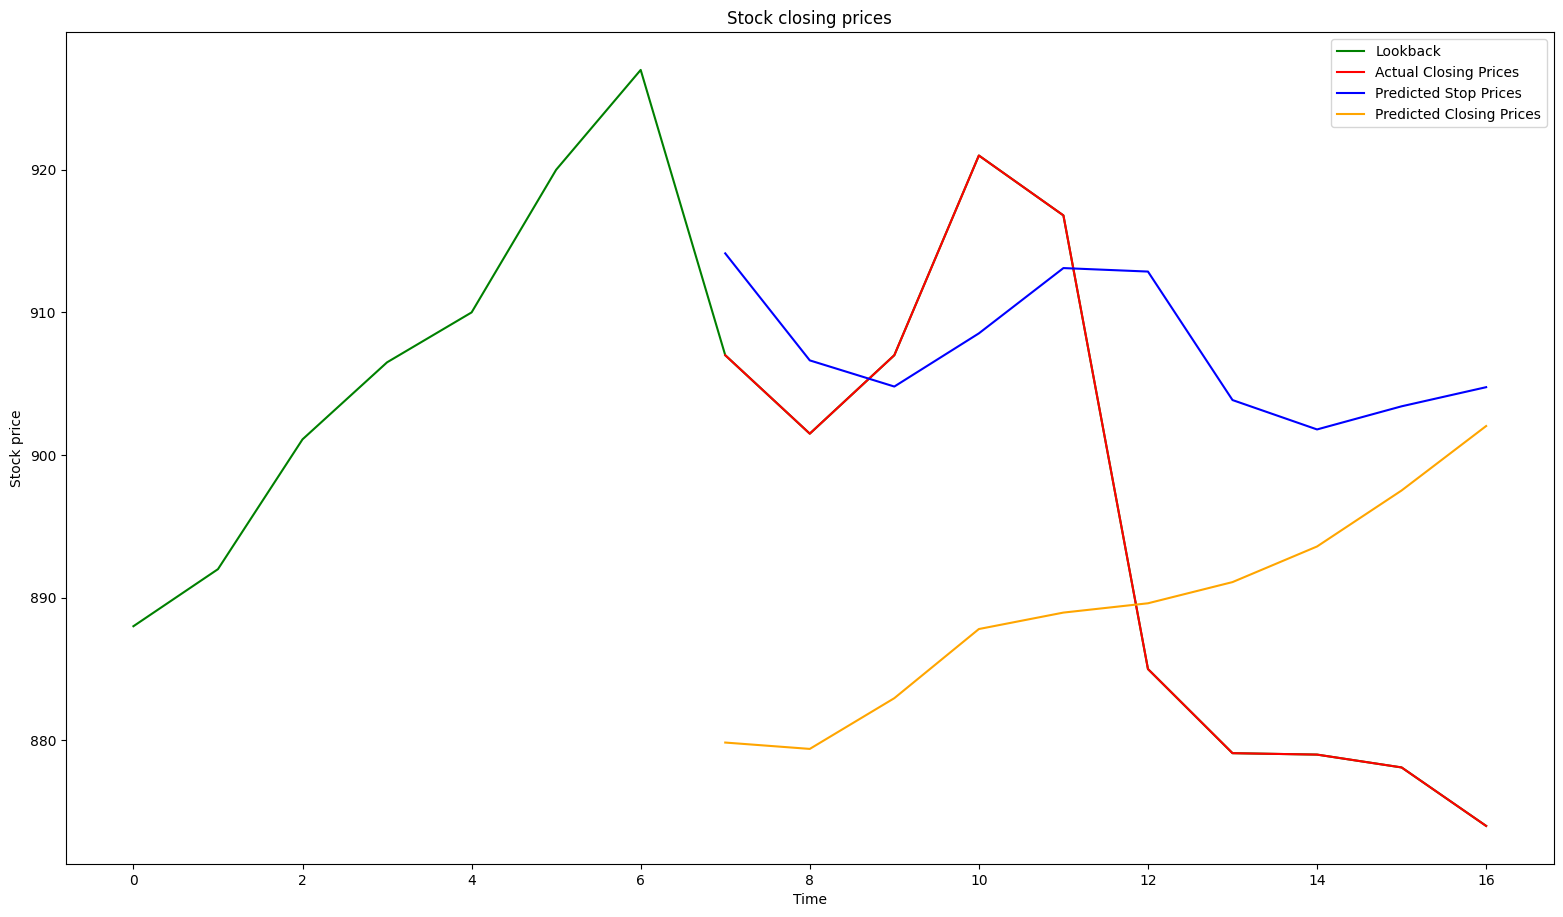

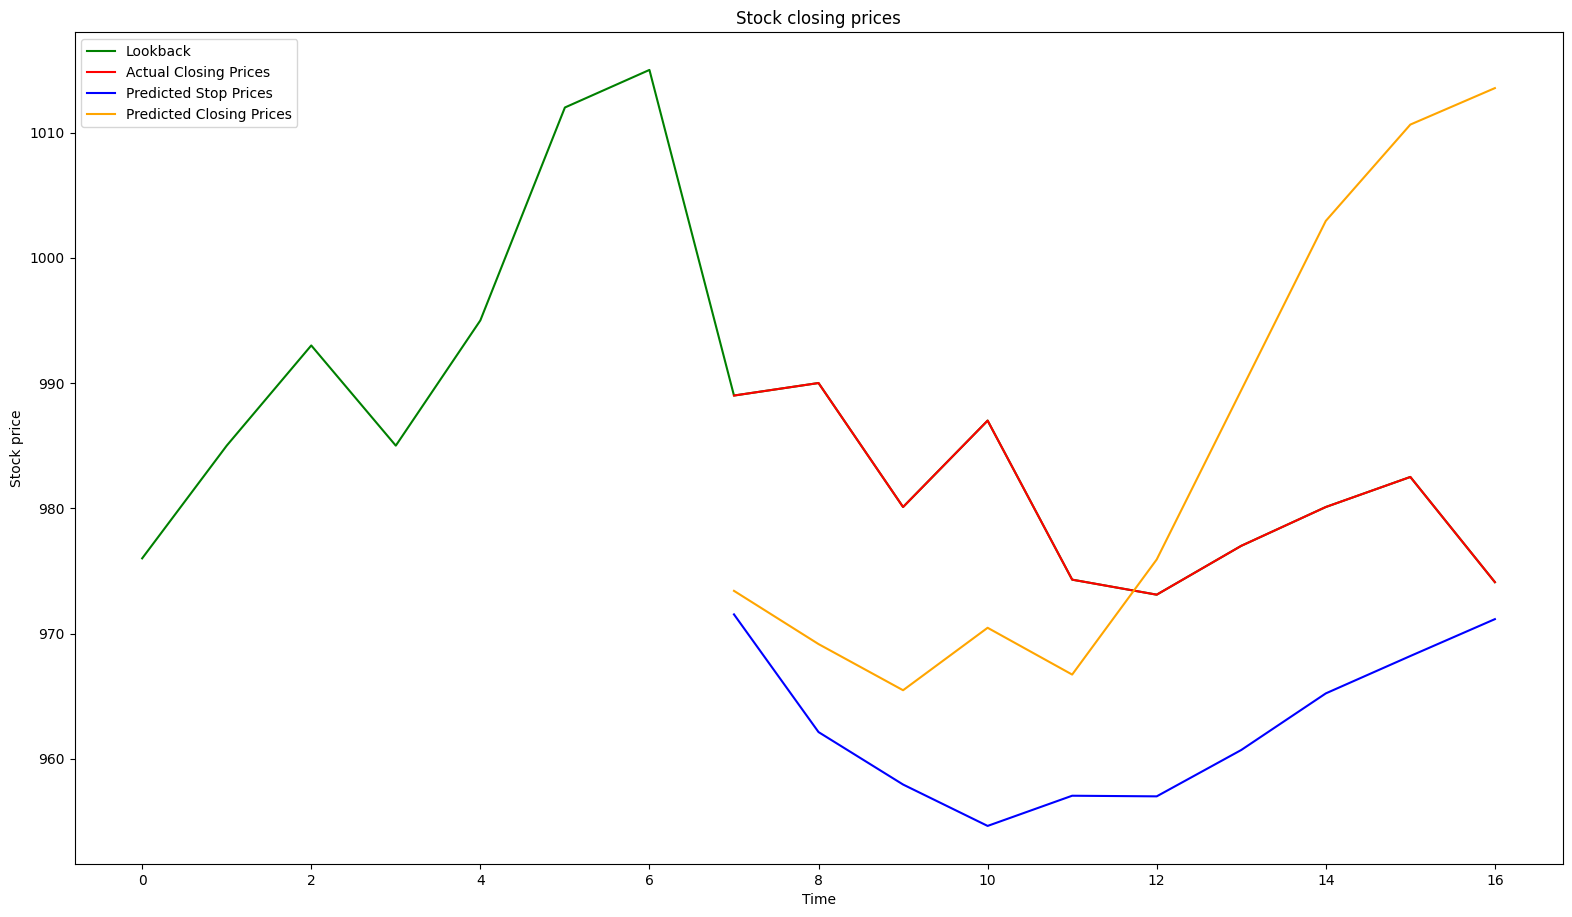

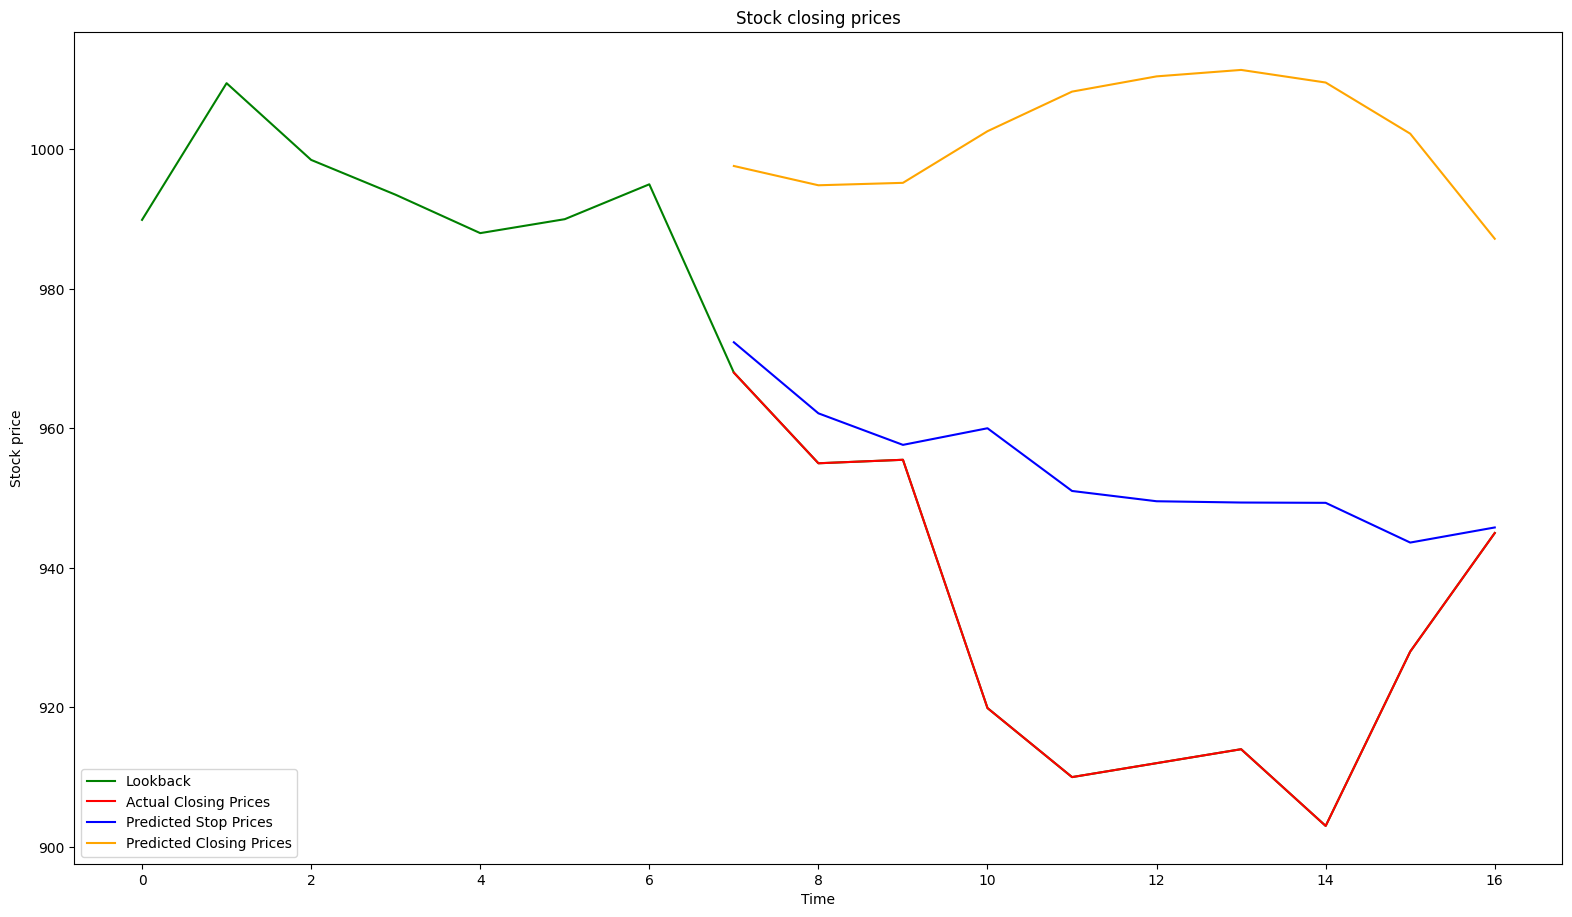

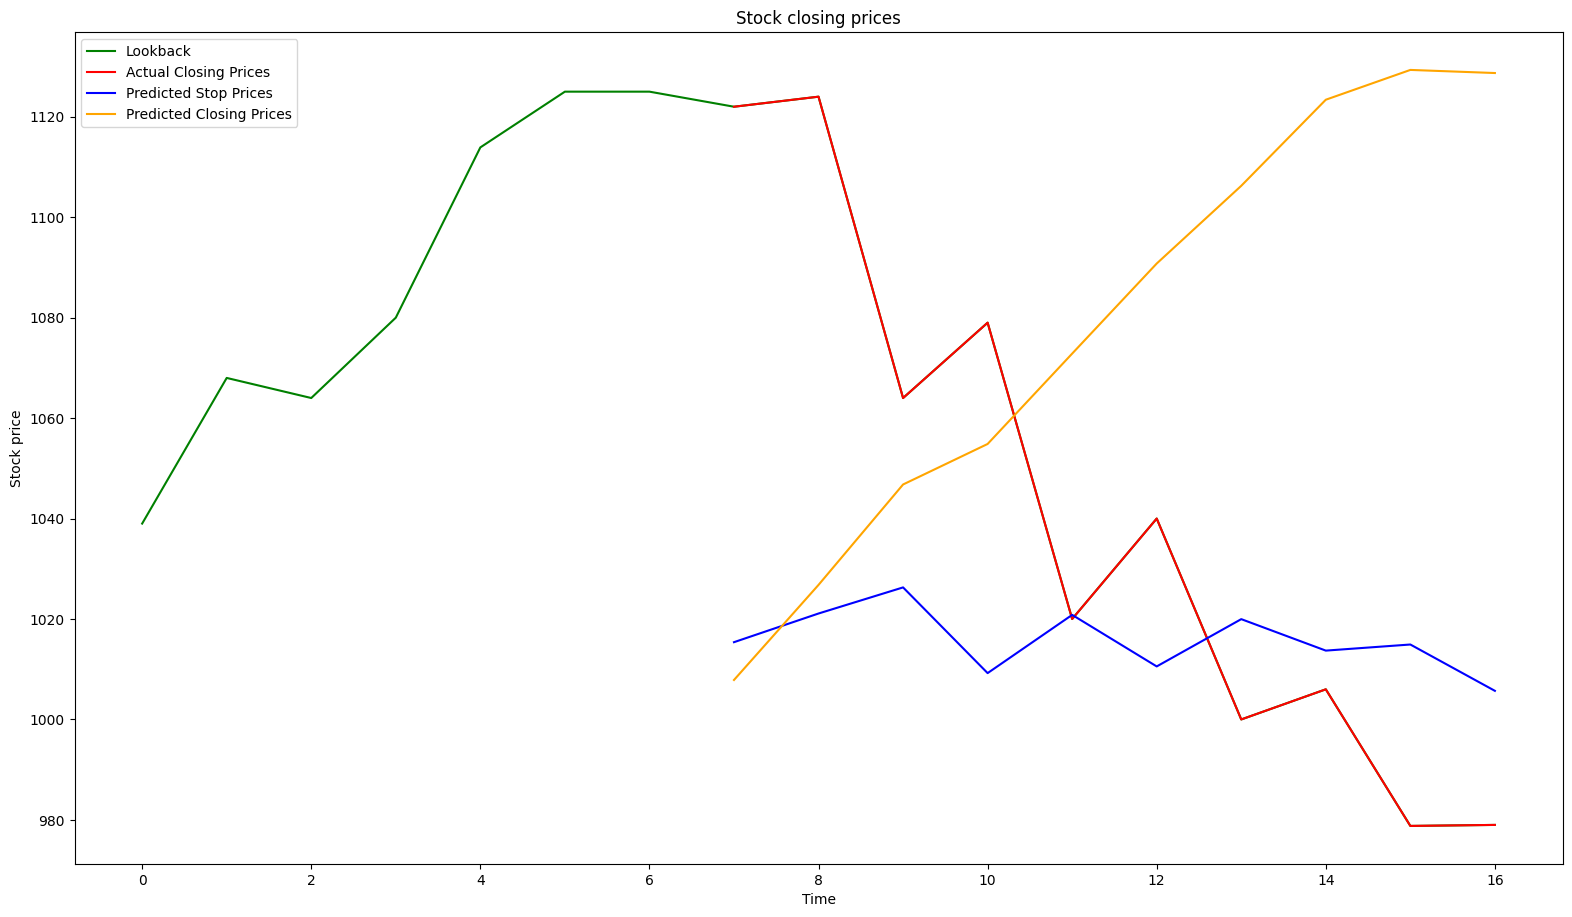

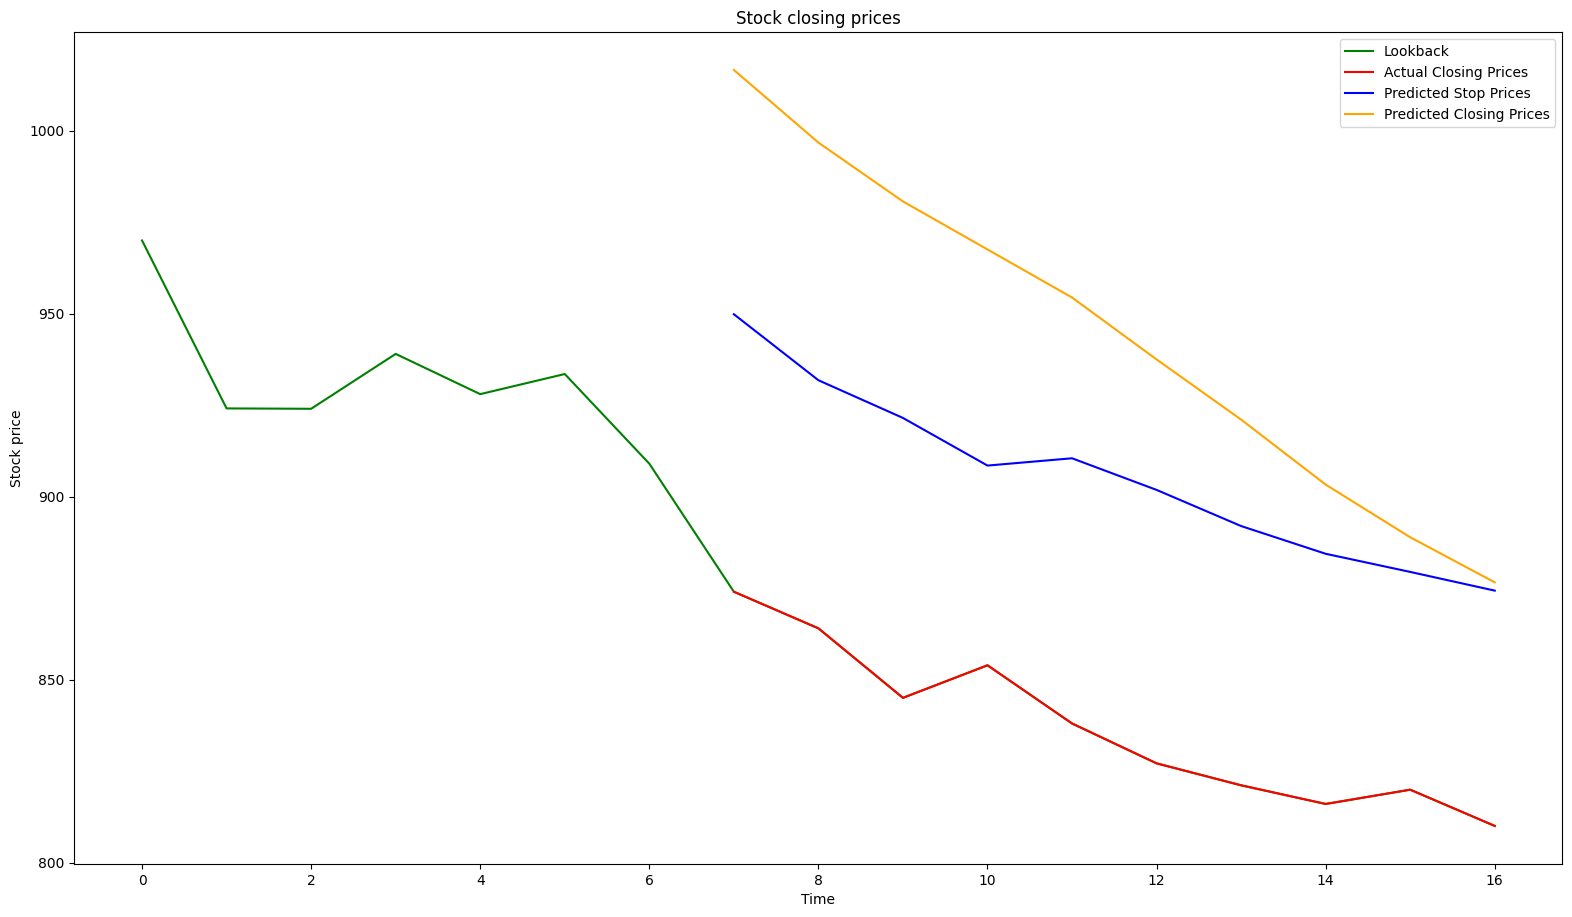

In [395]:
perform_directional_trades(test_df, model, scaler, cfg.lookback_period, trade_window, -2, -1, 10, "down")

In [396]:
def plot_predictions_window(
    df_window: pd.DataFrame,
    pred_price: np.ndarray,
    pred_stop: np.ndarray,
    lookback: int,
    title: str = "Predictions"
):
    """
    df_window: the raw (unscaled) window you fed into torch_test
    pred_* arrays are returned by torch_test (already inverse-transformed)
    """
    close = df_window["Close"].to_numpy()

    # x axis for predicted points starts after lookback
    x = np.arange(lookback, lookback + len(pred_price))

    plt.figure(figsize=(14, 6))
    plt.plot(np.arange(len(close)), close, label="Close (input window)")

    plt.plot(x, pred_price, label="Pred Close")
    plt.plot(x, pred_stop, label="Pred Stop")

    # If ground truth stop exists, overlay it
    if "stop_price" in df_window.columns:
        gt_stop = df_window["stop_price"].to_numpy()[lookback:]
        if len(gt_stop) == len(pred_stop):
            plt.plot(x, gt_stop, label="Actual Stop")

    plt.title(title)
    plt.xlabel("Index in window")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


[1217.0242 1218.425  1190.6672 1182.5637 1173.7109 1178.2646 1180.4286
 1180.7266 1171.8689 1169.8705]
[1341.28745475 1365.94347414 1413.18035888 1321.56263924 1313.67271304
 1321.56263924 1335.3700101  1340.30121398 1245.62209952 1235.75969177
 1220.96608014 1237.73217332 1250.5533034  1270.27811891 1257.45698883
 1273.23684124 1284.08548977]
pred_price shape: (10,)
pred_stop shape: (10,)


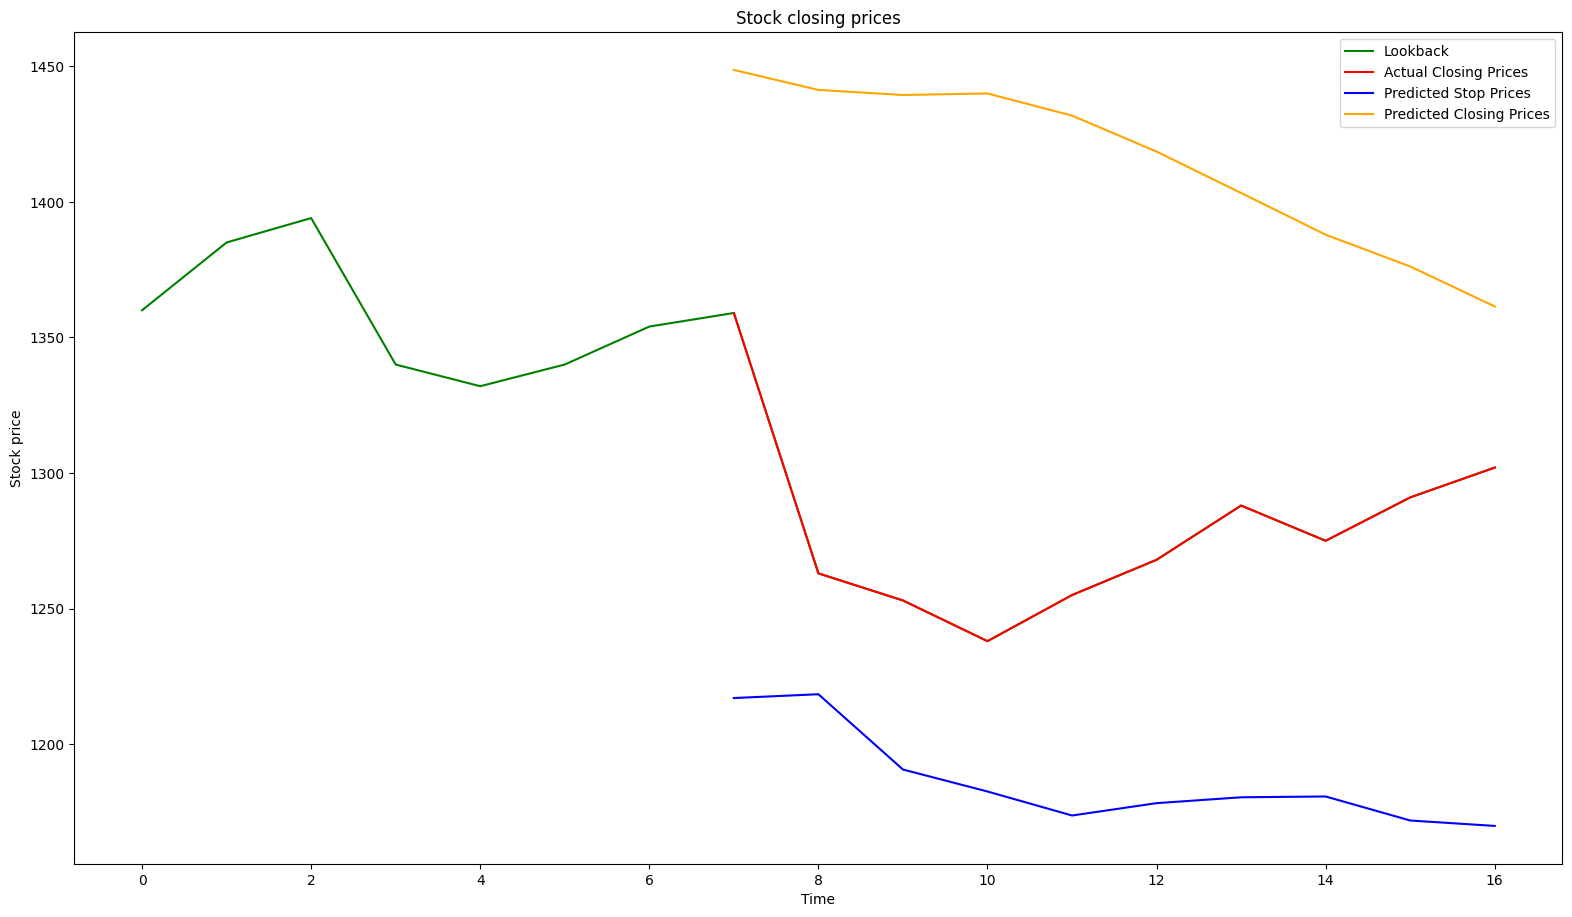

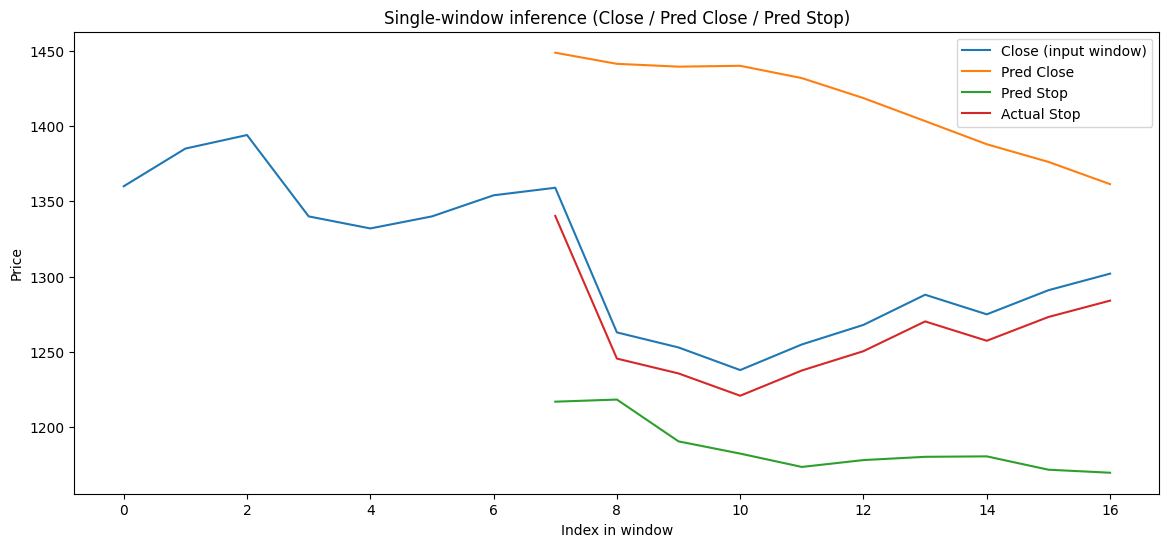

In [397]:
# Pick a single contiguous slice for a clean test
lookback = cfg.lookback_period
trade_window = 10

# Example: last (lookback+trade_window) rows
df_window = test_df.iloc[-(lookback + trade_window):].copy()

pred_price, pred_stop = torch_test(df_window, model, scaler, lookback)

print("pred_price shape:", pred_price.shape)
print("pred_stop shape:", pred_stop.shape)

# Basic shape tests
assert pred_price.ndim == 1 and pred_stop.ndim == 1
assert len(pred_price) == len(pred_stop) == (len(df_window) - lookback)

plot_predictions_window(
    df_window=df_window,
    pred_price=pred_price,
    pred_stop=pred_stop,
    lookback=lookback,
    title="Single-window inference (Close / Pred Close / Pred Stop)"
)


[885.5085  886.83826 883.3898  880.74243 882.7916  883.76245 887.1362
 886.6322  884.8762  885.33594]
[848.16706698 849.84367629 849.64642814 877.91548837 853.19689493
 852.80239862 850.13954853 846.78632989 838.4032833  840.573013
 846.19458543 844.22210387 843.2358631  844.22210387 843.2358631
 856.05699318 858.02947473]
[873.10034 874.12866 873.8415  873.2285  872.5069  872.88544 872.4348
 871.14343 869.413   870.24835]
[837.31841845 865.75037768 827.06151438 796.88254665 814.16148504
 813.39221723 827.95899349 834.02437425 832.48583864 831.43056102
 836.59846268 861.00598451 840.33631522 838.63998108 839.20213833
 840.39548966 838.69915553]
[898.008   897.15564 893.93567 892.732   892.38605 885.95605 883.2777
 875.93005 869.7849  869.08496]
[882.84329264 878.63204453 865.19944517 886.20803883 850.68198095
 847.14137657 841.55925378 834.90212854 833.40304257 837.09158307
 839.52759778 834.38928334 837.94961254 828.57046277 826.80509178
 828.91564704 828.32390257]
[884.58215 886.3374

/tmp/ipykernel_140073/306145648.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(19.20,10.80))


[915.5554  897.5768  901.34644 892.693   890.58704 896.73865 909.9768
 897.05566 892.4147  893.4807 ]
[833.37345534 866.90564171 878.74053102 899.4515873  888.60293877
 925.09384747 961.04374478 882.68549412 897.47910575 862.96067861
 852.11203008 867.89188249 929.51583289 855.07075241 838.30465922
 848.16706698 867.89188249]
[975.73376 974.92676 976.68243 971.0199  973.1376  975.60333 989.64355
 995.9702  991.0355  990.16406]
[ 959.61227461  976.3783678   982.29581245  968.48844159 1068.09671888
 1035.55281433 1024.60554172 1005.96559106  996.10318331  968.48844159
  966.51596004  975.39212702 1015.82799882 1034.56657356 1023.61930095
 1025.69040658 1079.65357404]
[1312.3419 1330.9614 1331.3081 1342.0918 1365.6426 1380.4089 1387.437
 1399.1416 1416.7207 1404.4539]
[1528.67320211 1546.42553607 1648.37249895 1690.4166893  1738.59706993
 1623.35231656 1656.88450293 1665.76066991 1614.47614958 1601.6550195
 1651.95329905 1675.62307767 1666.74691069 1702.25157861 1803.47766029
 1713.100227

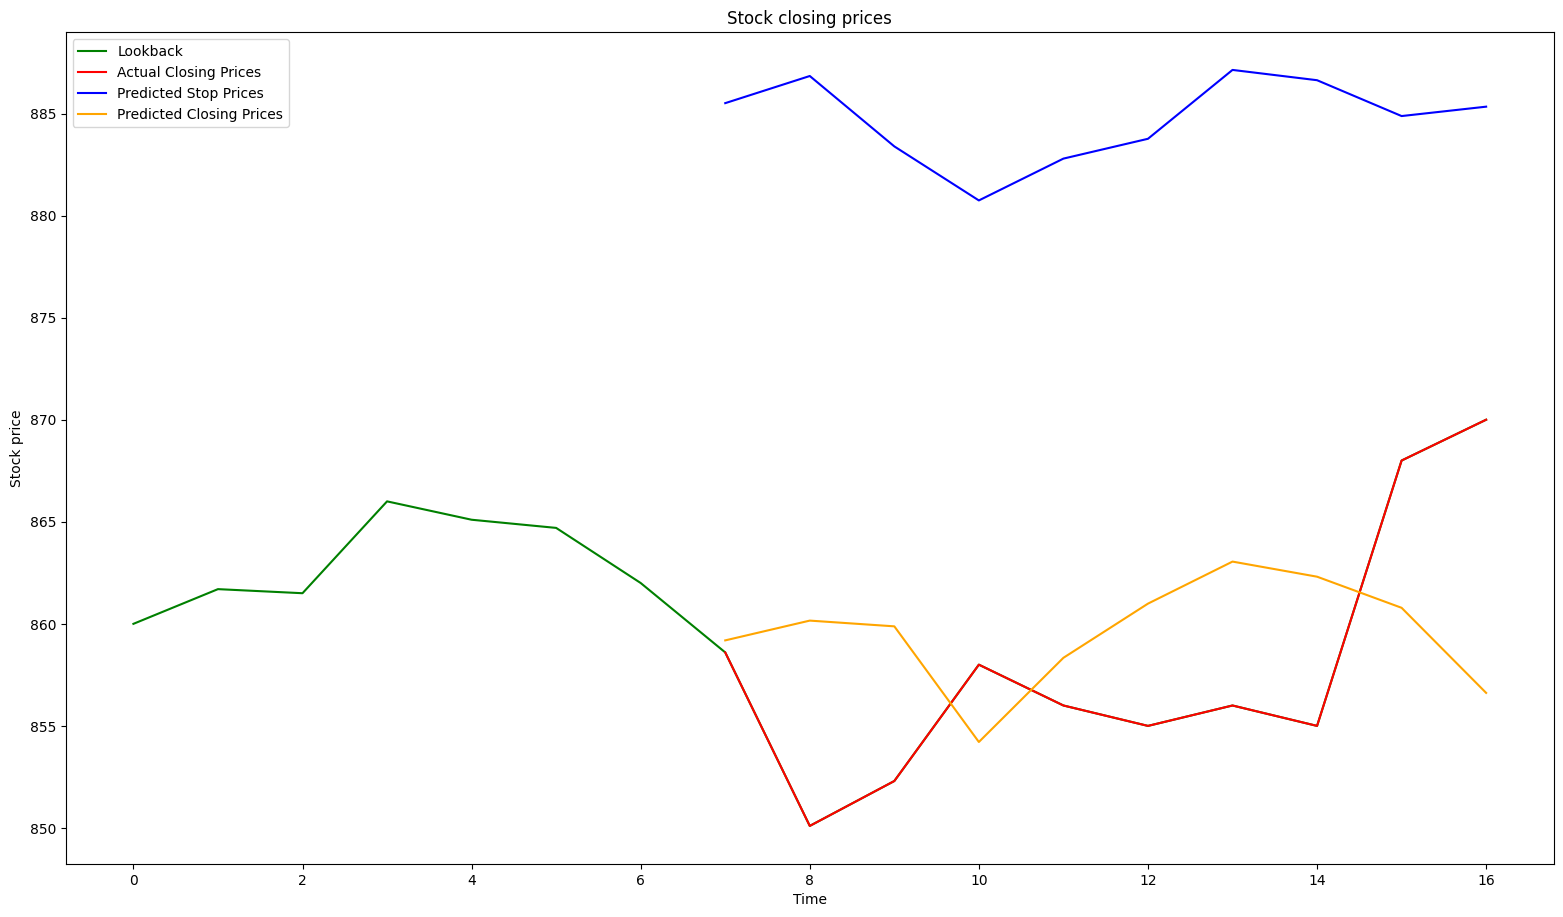

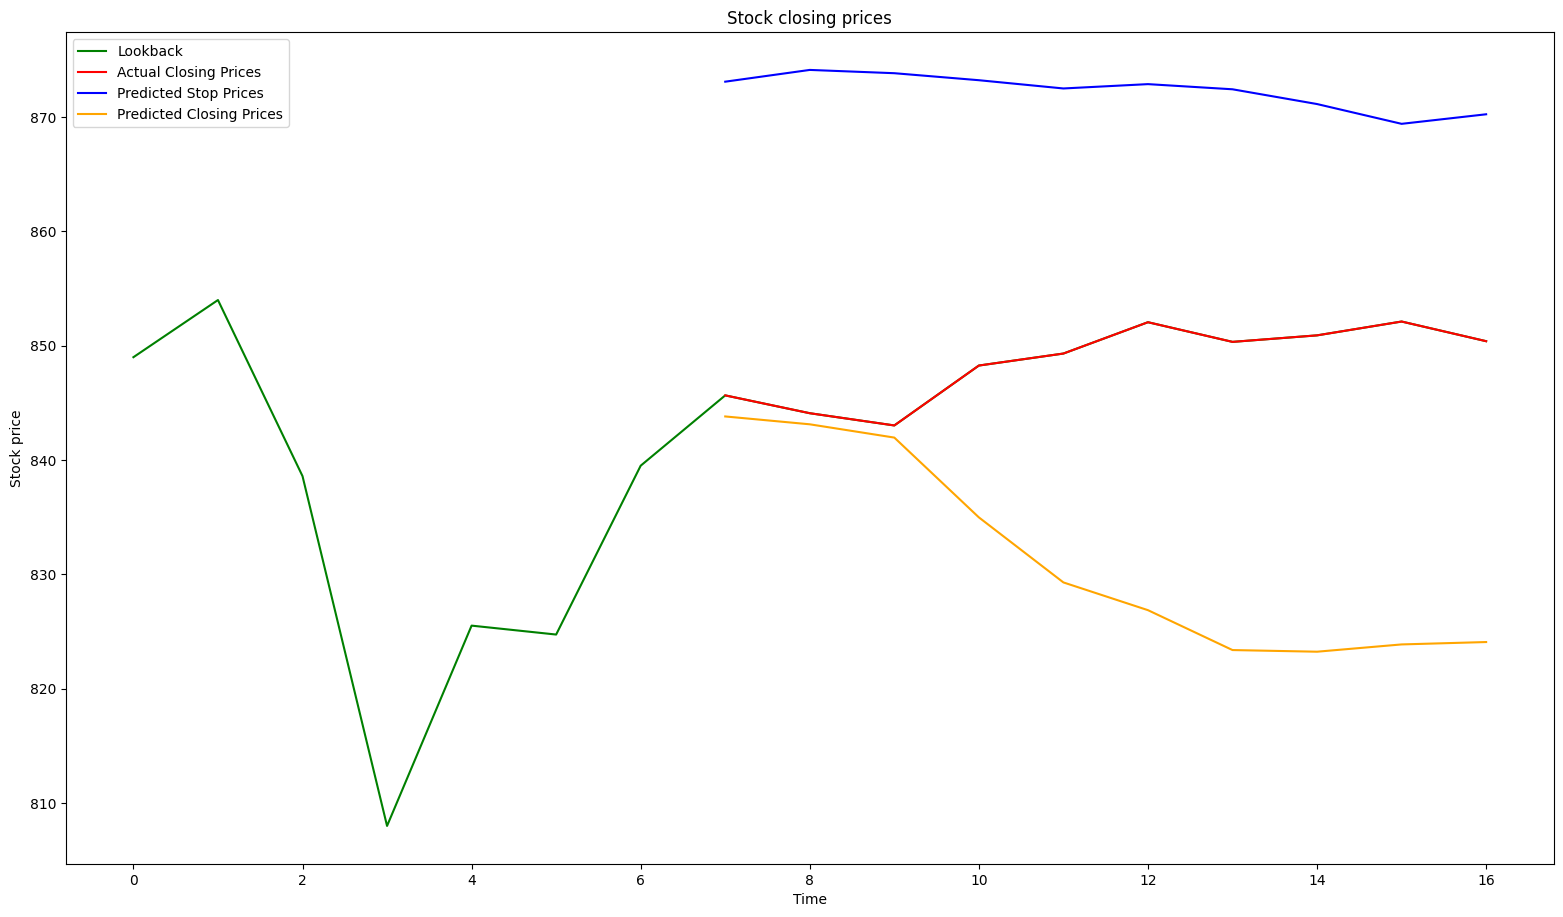

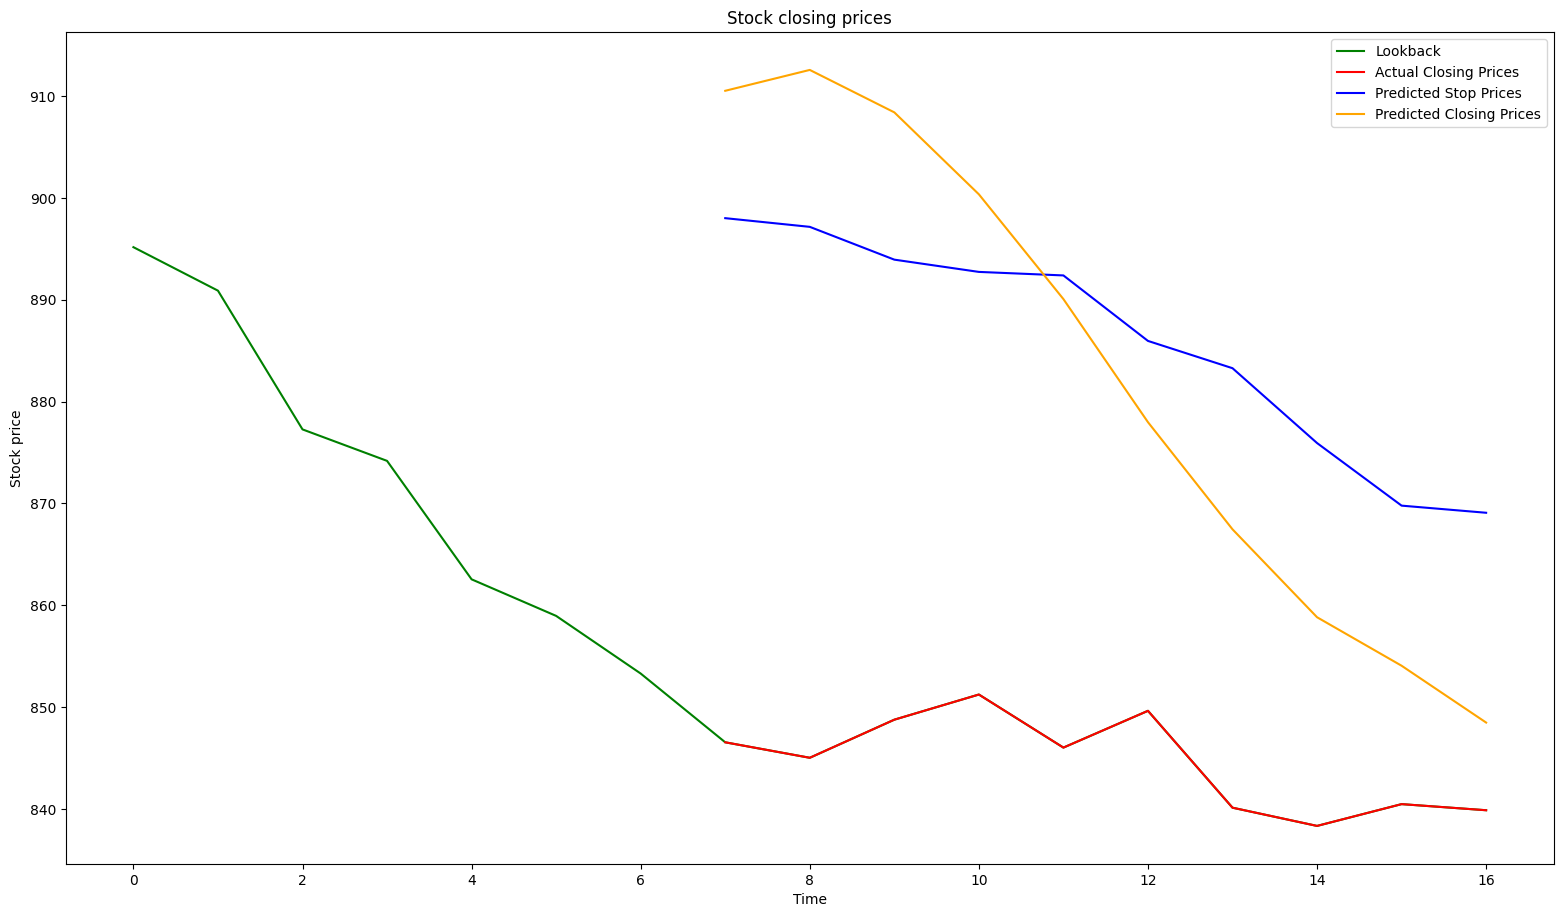

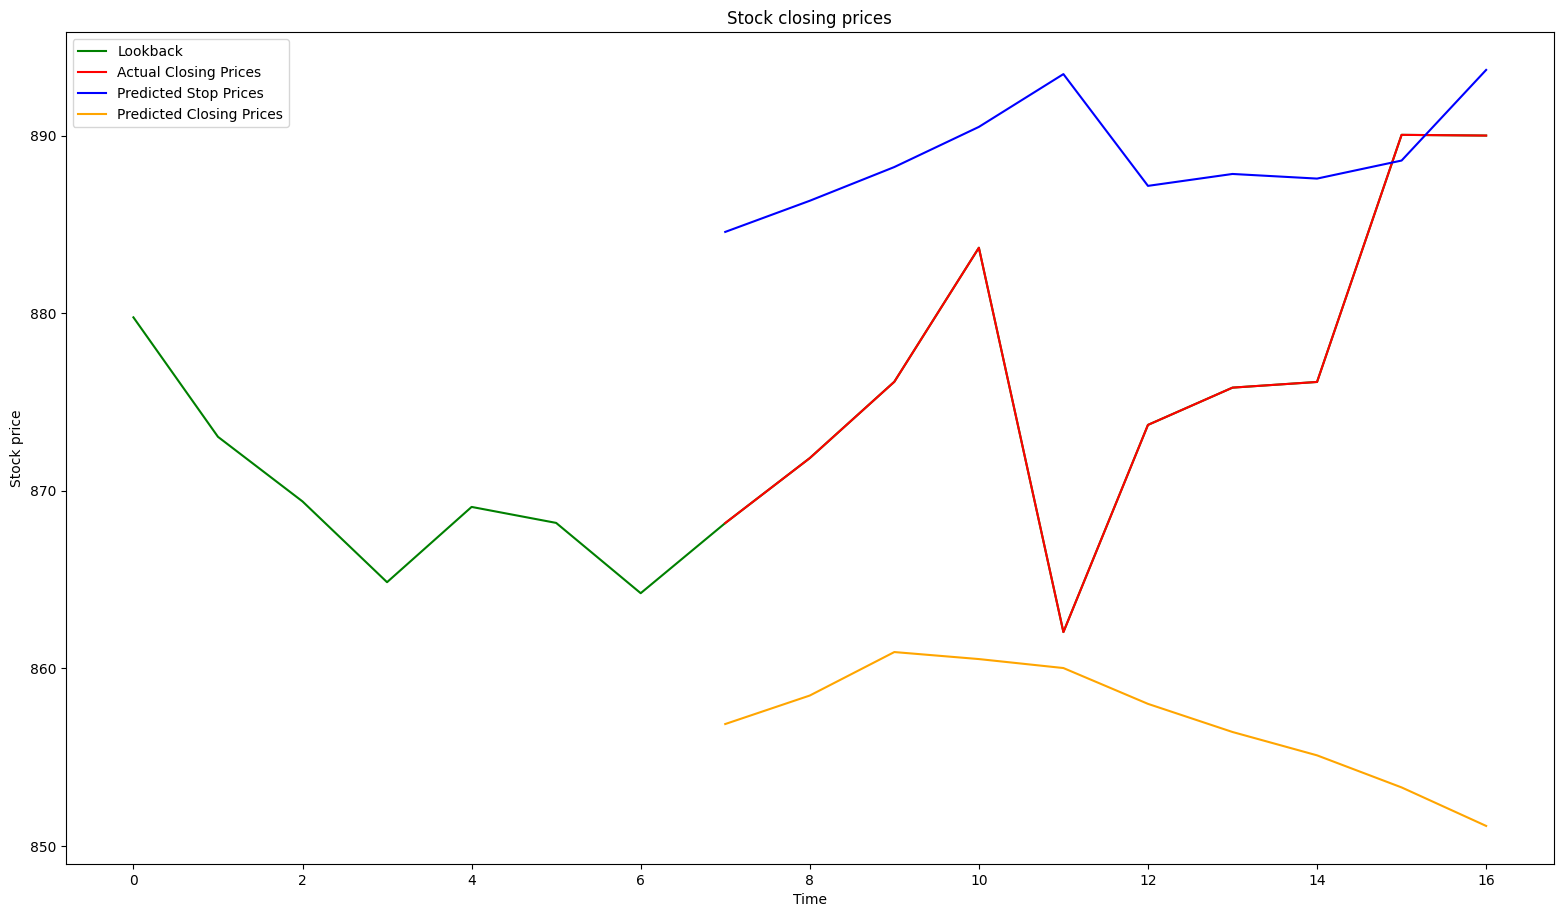

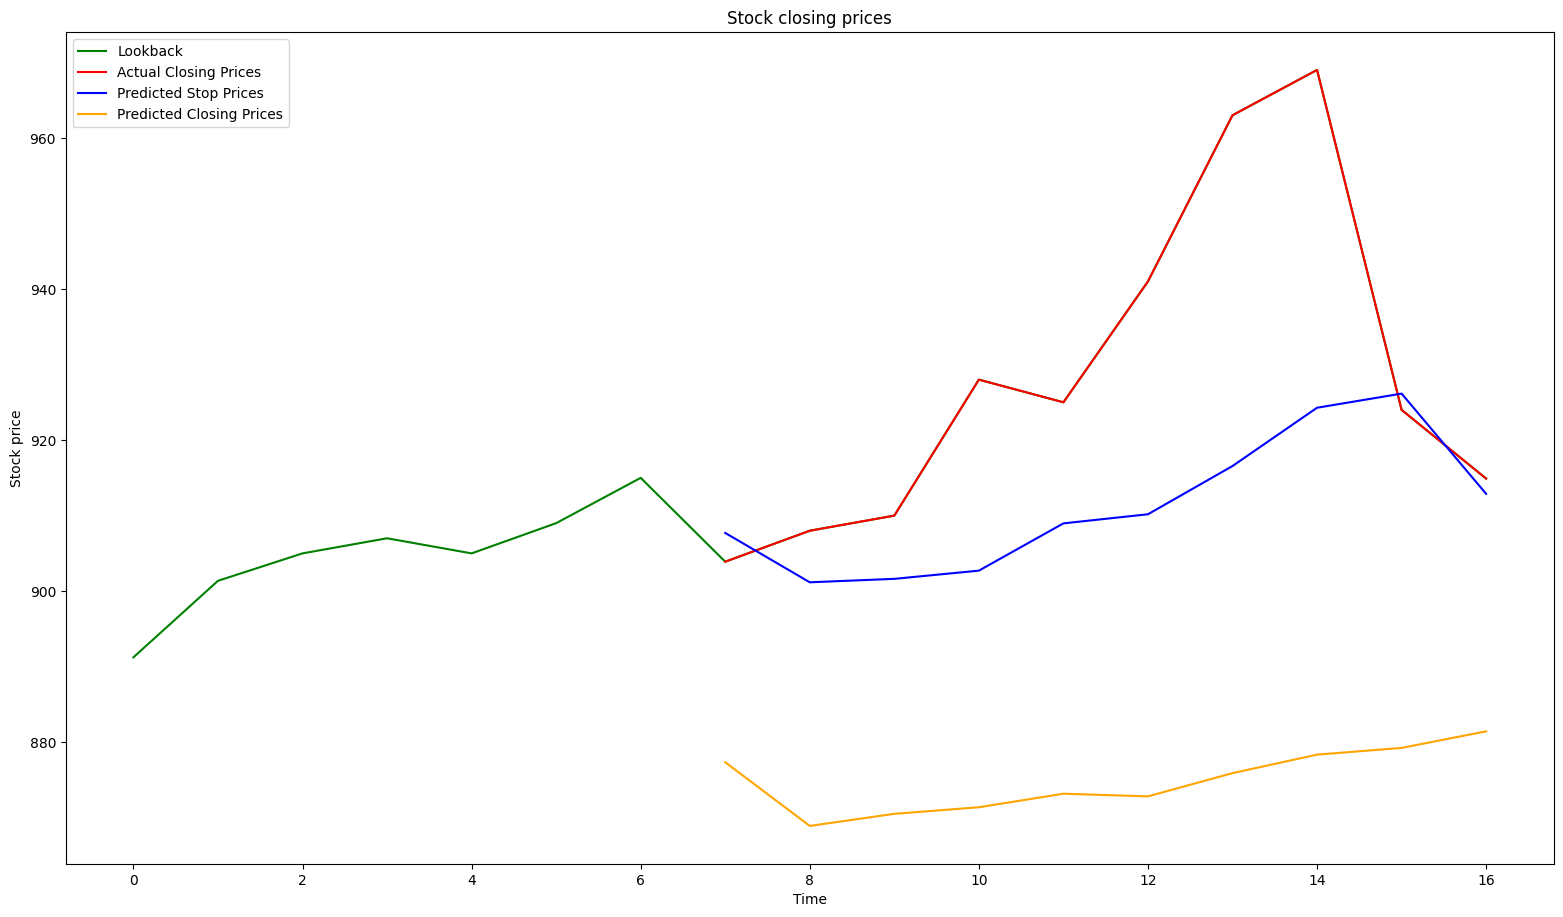

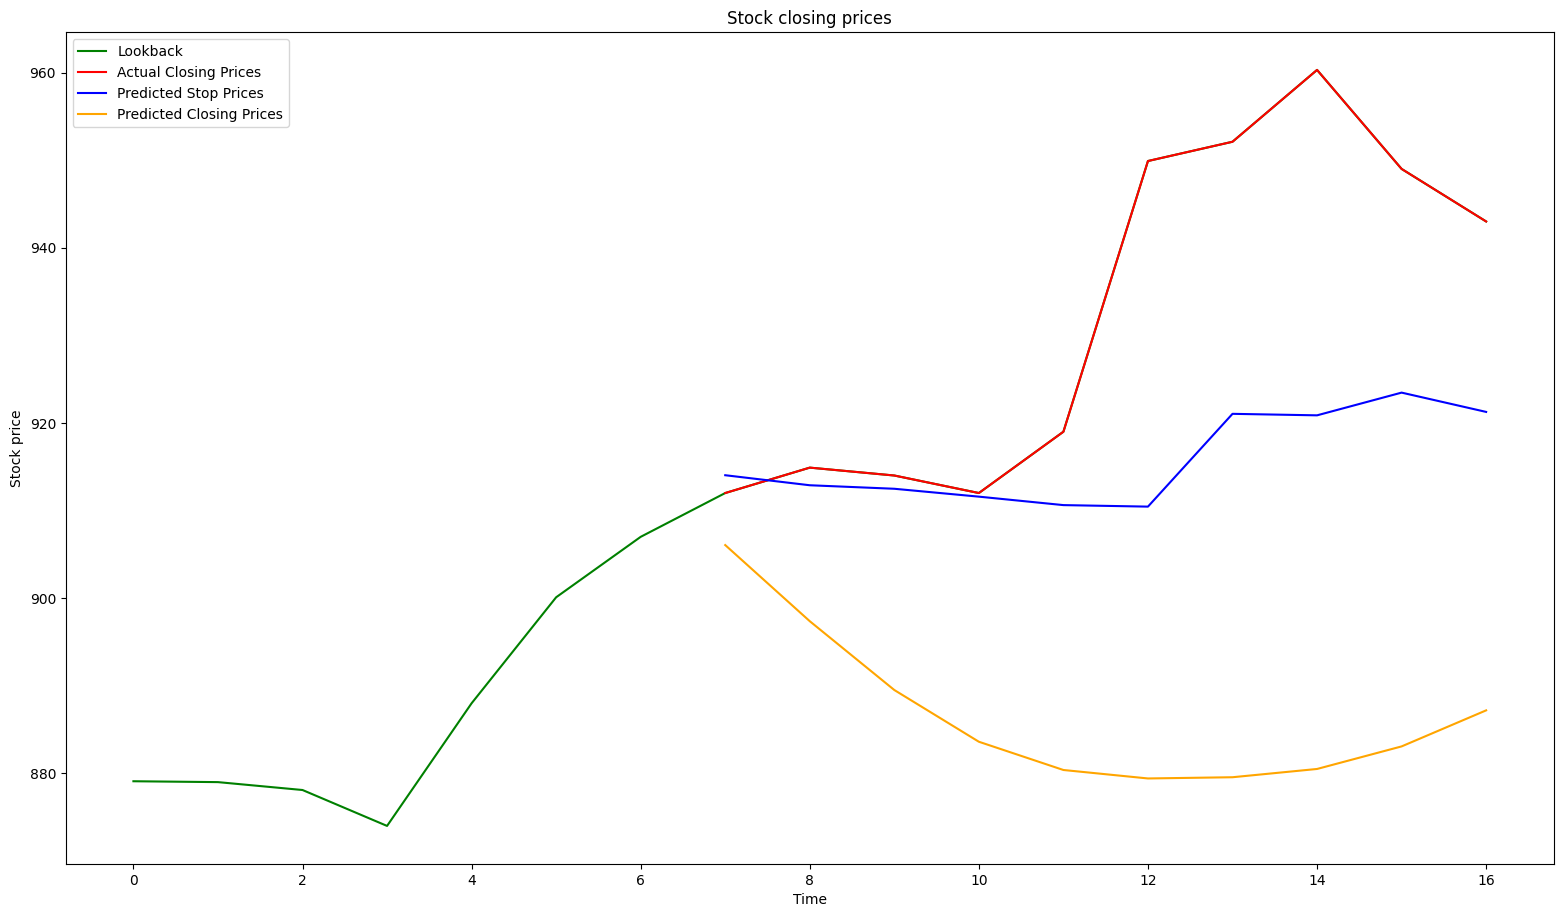

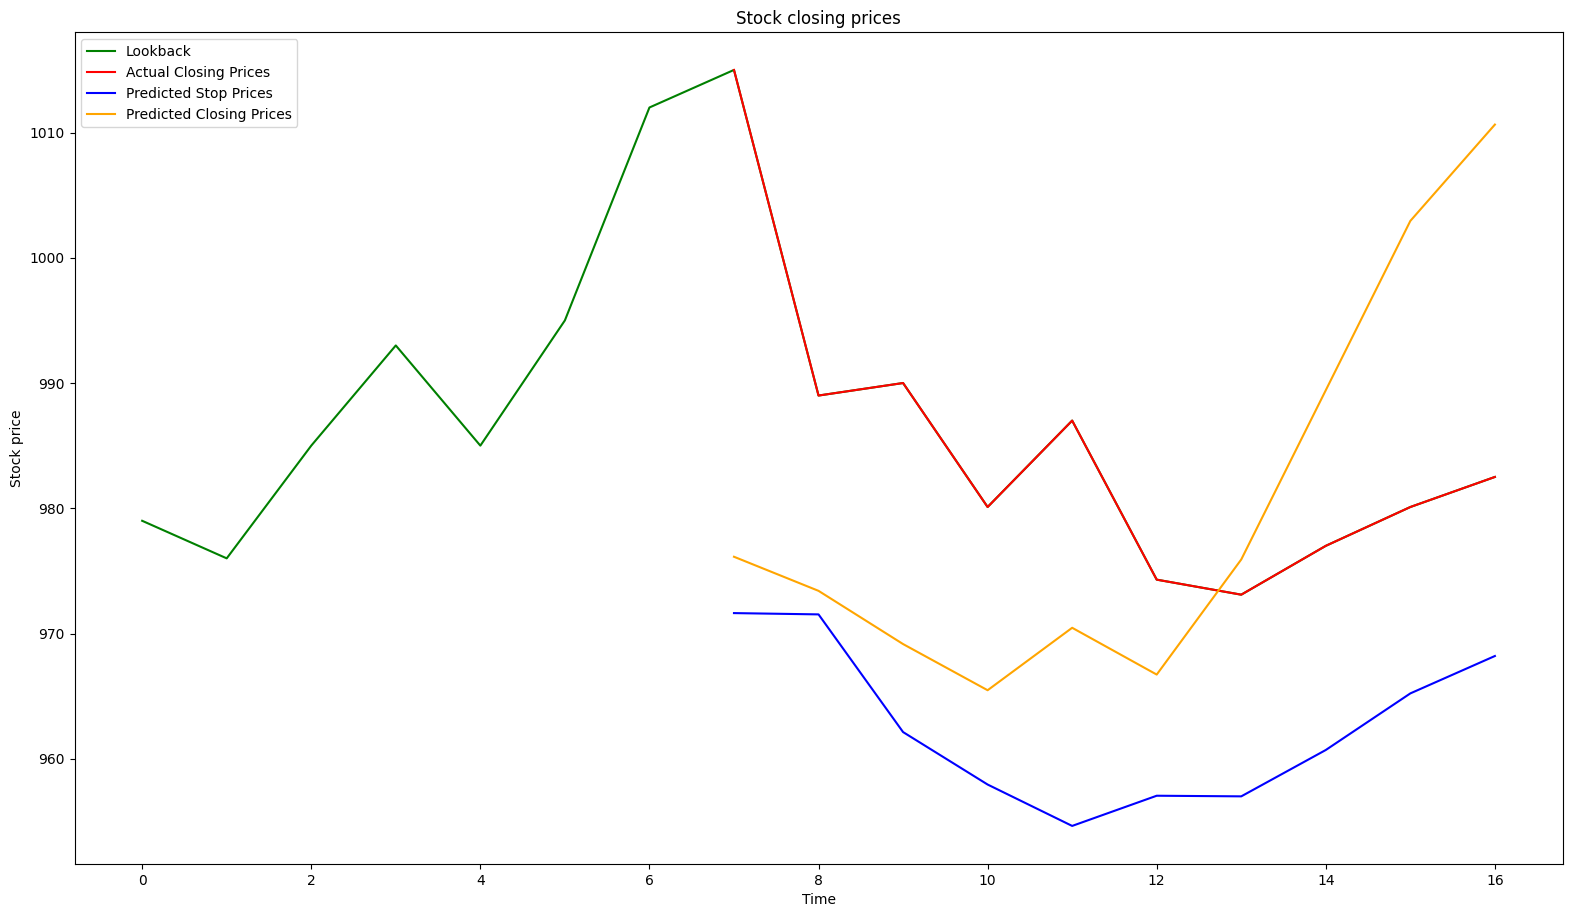

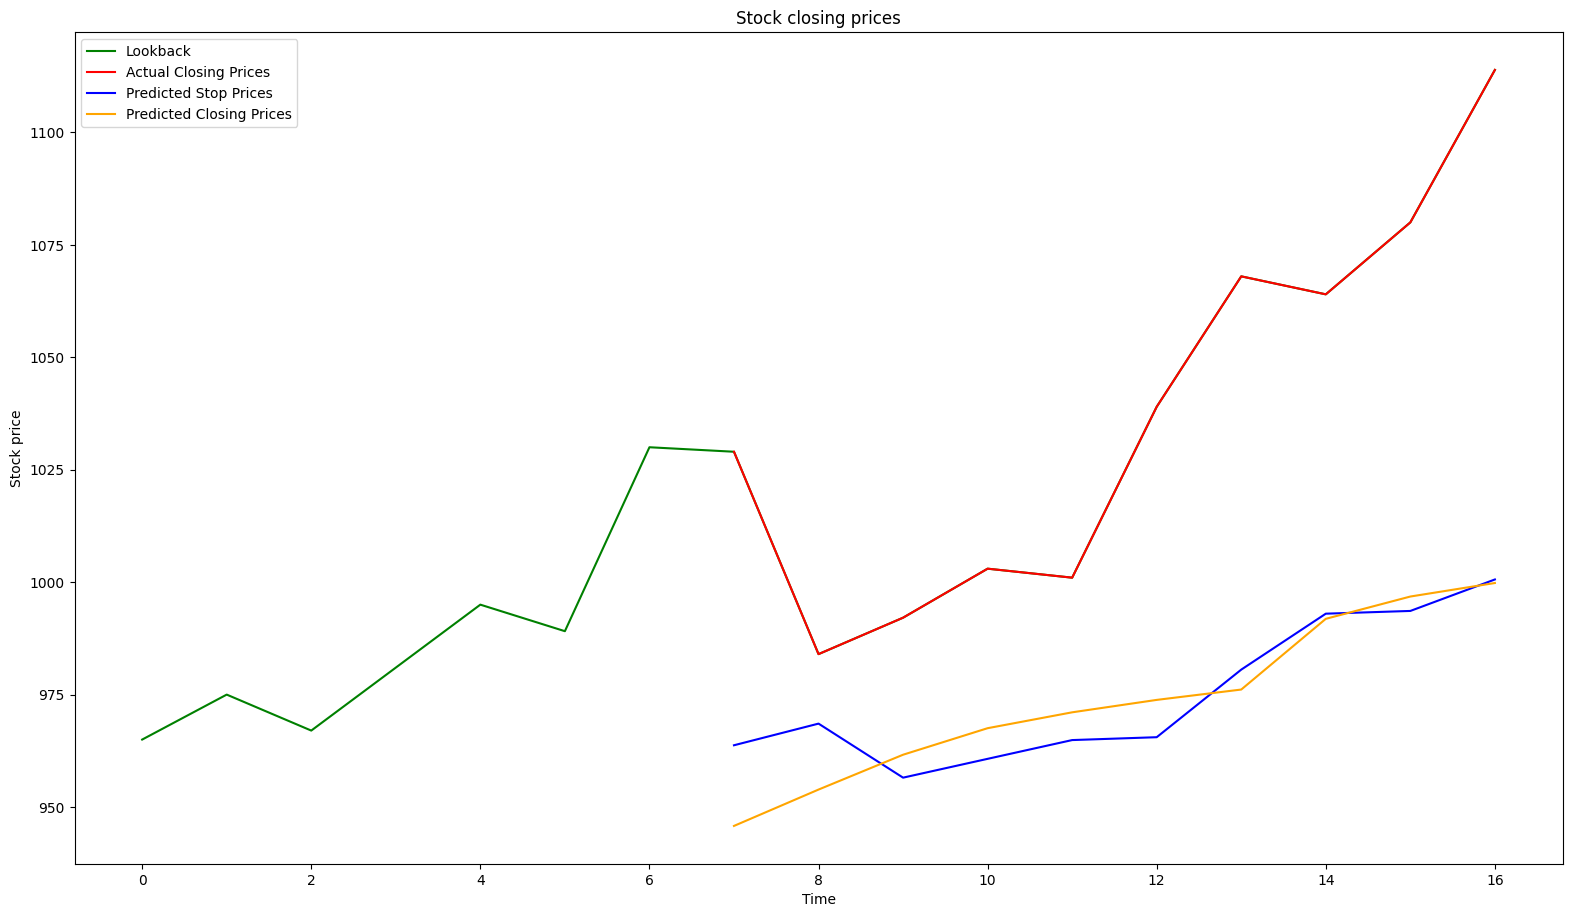

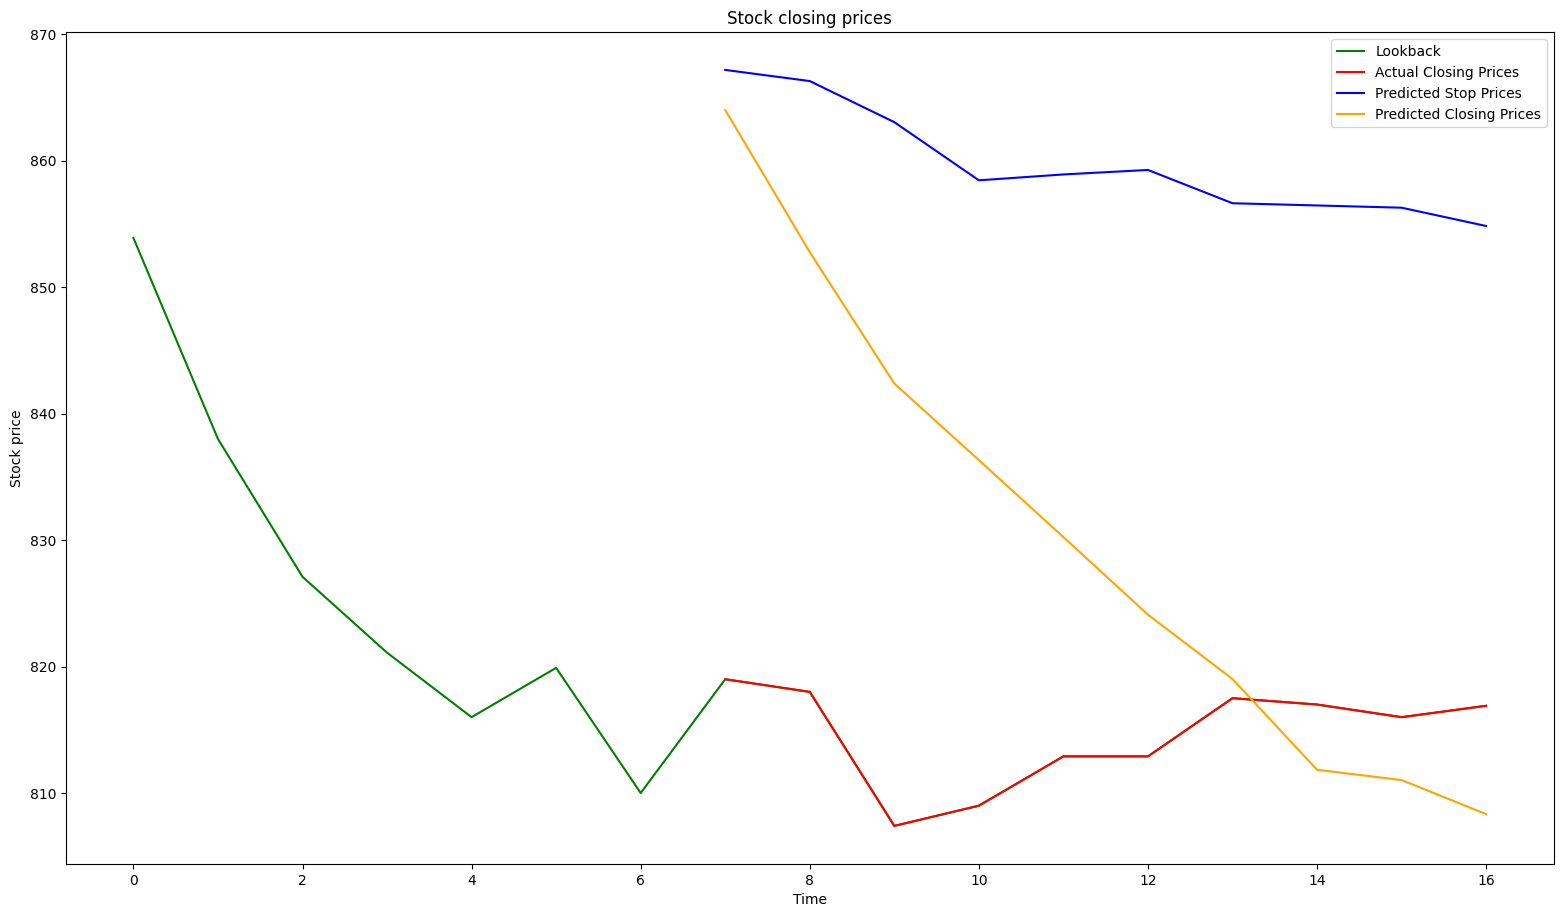

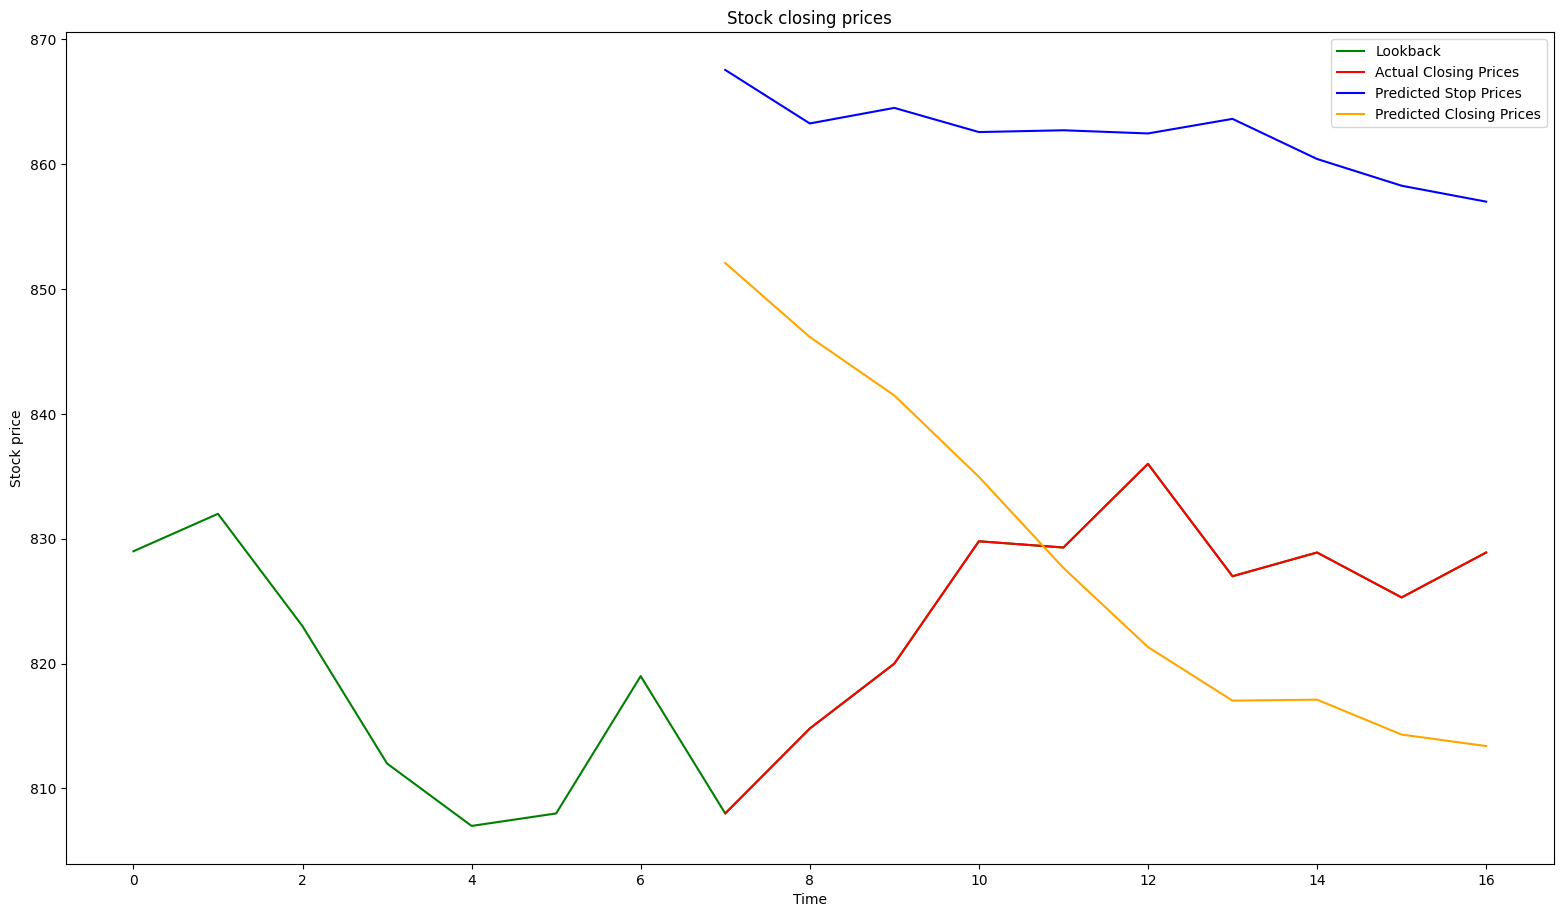

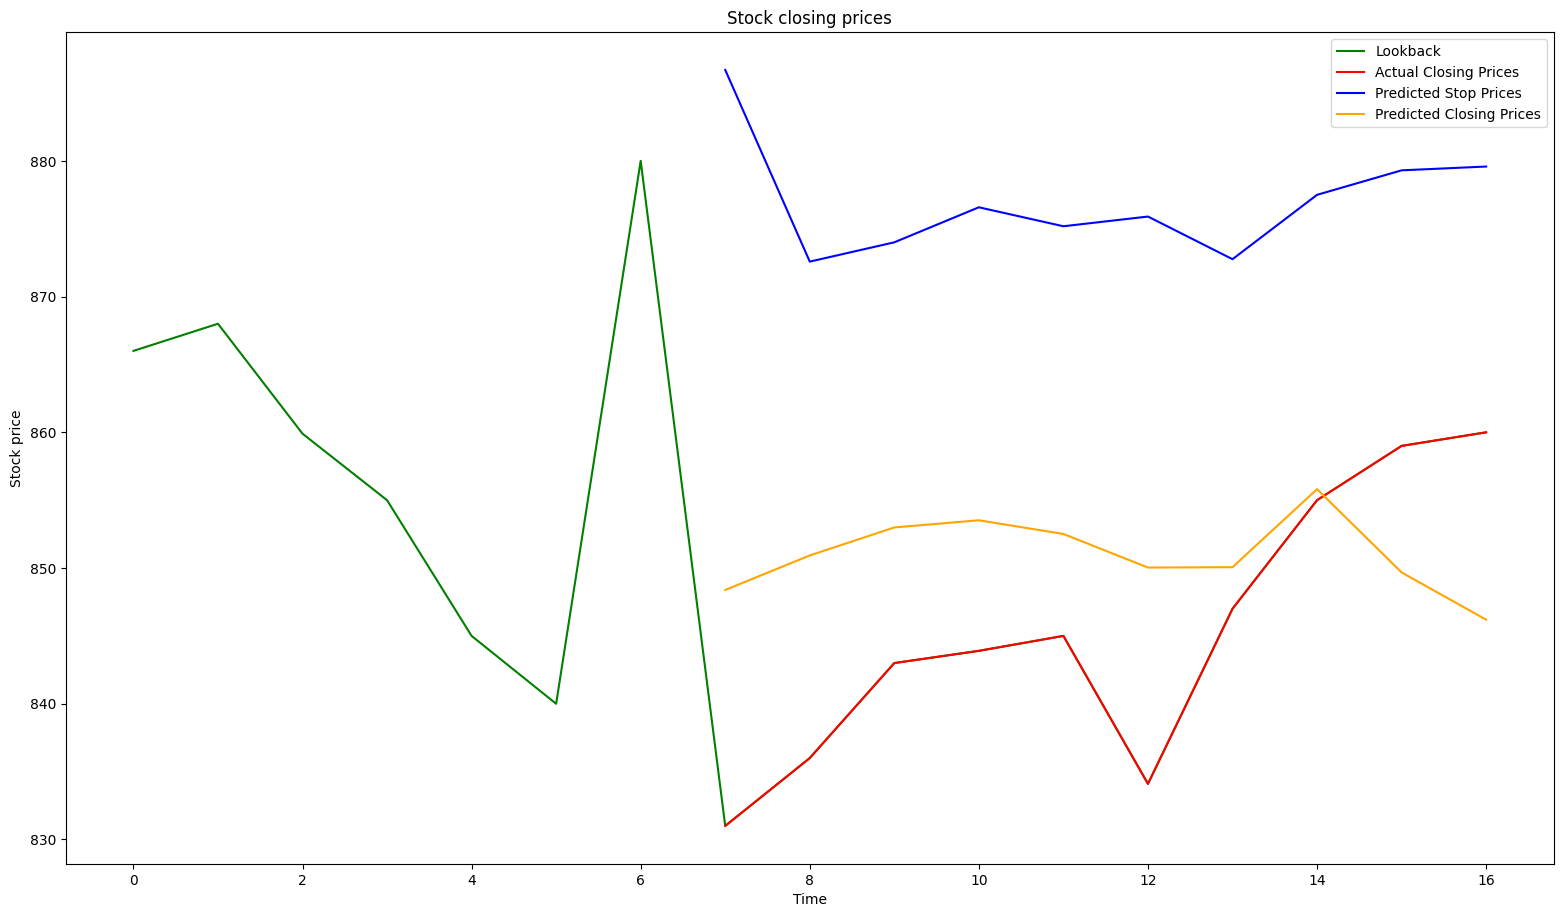

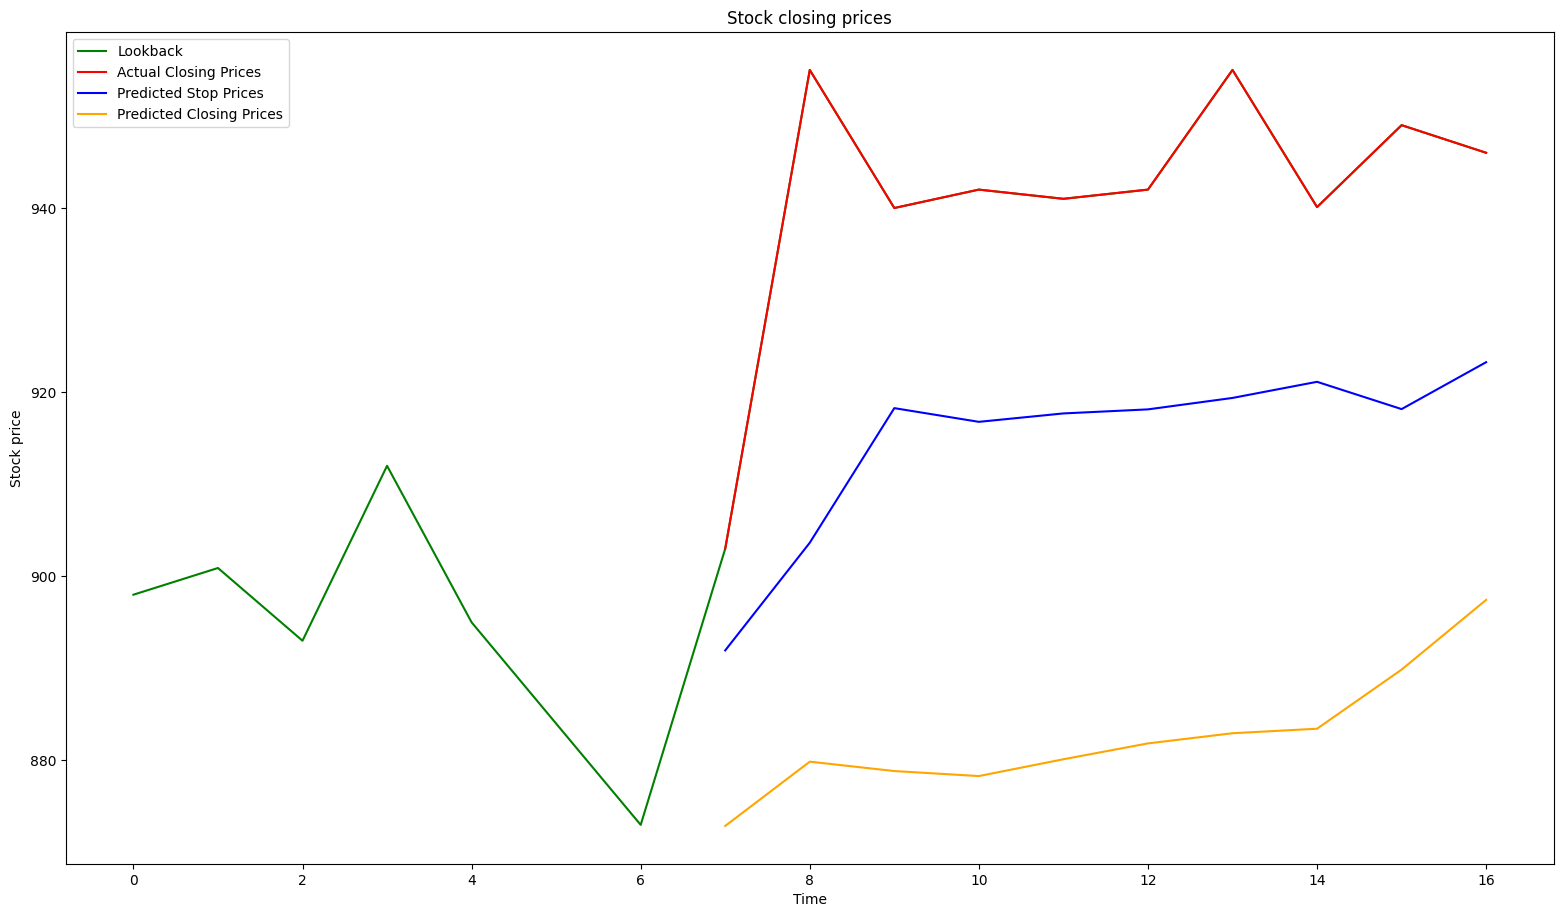

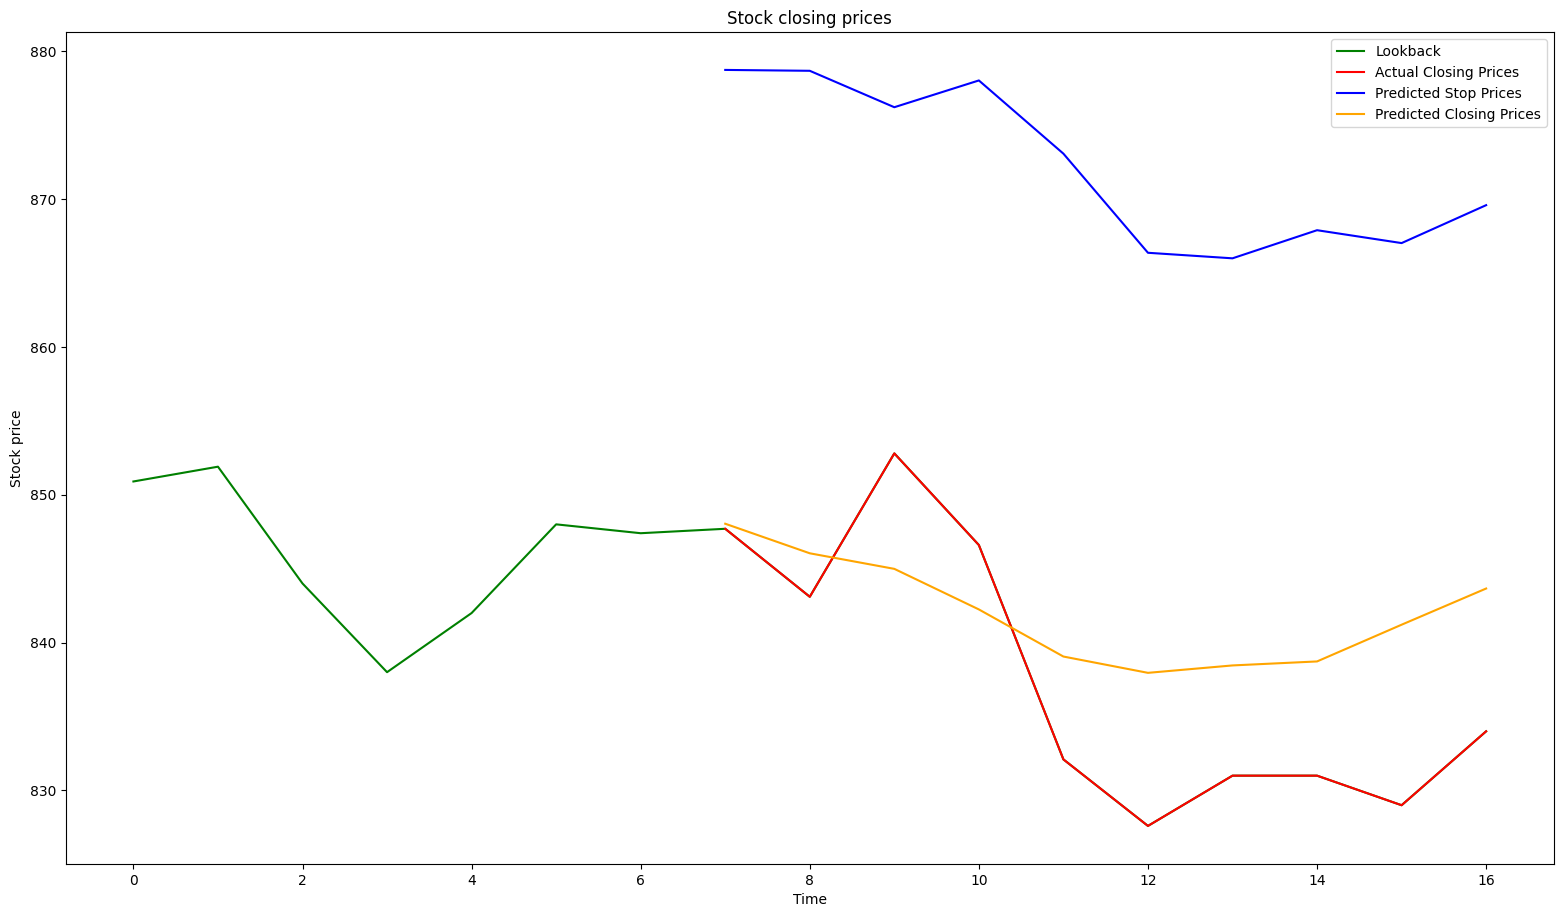

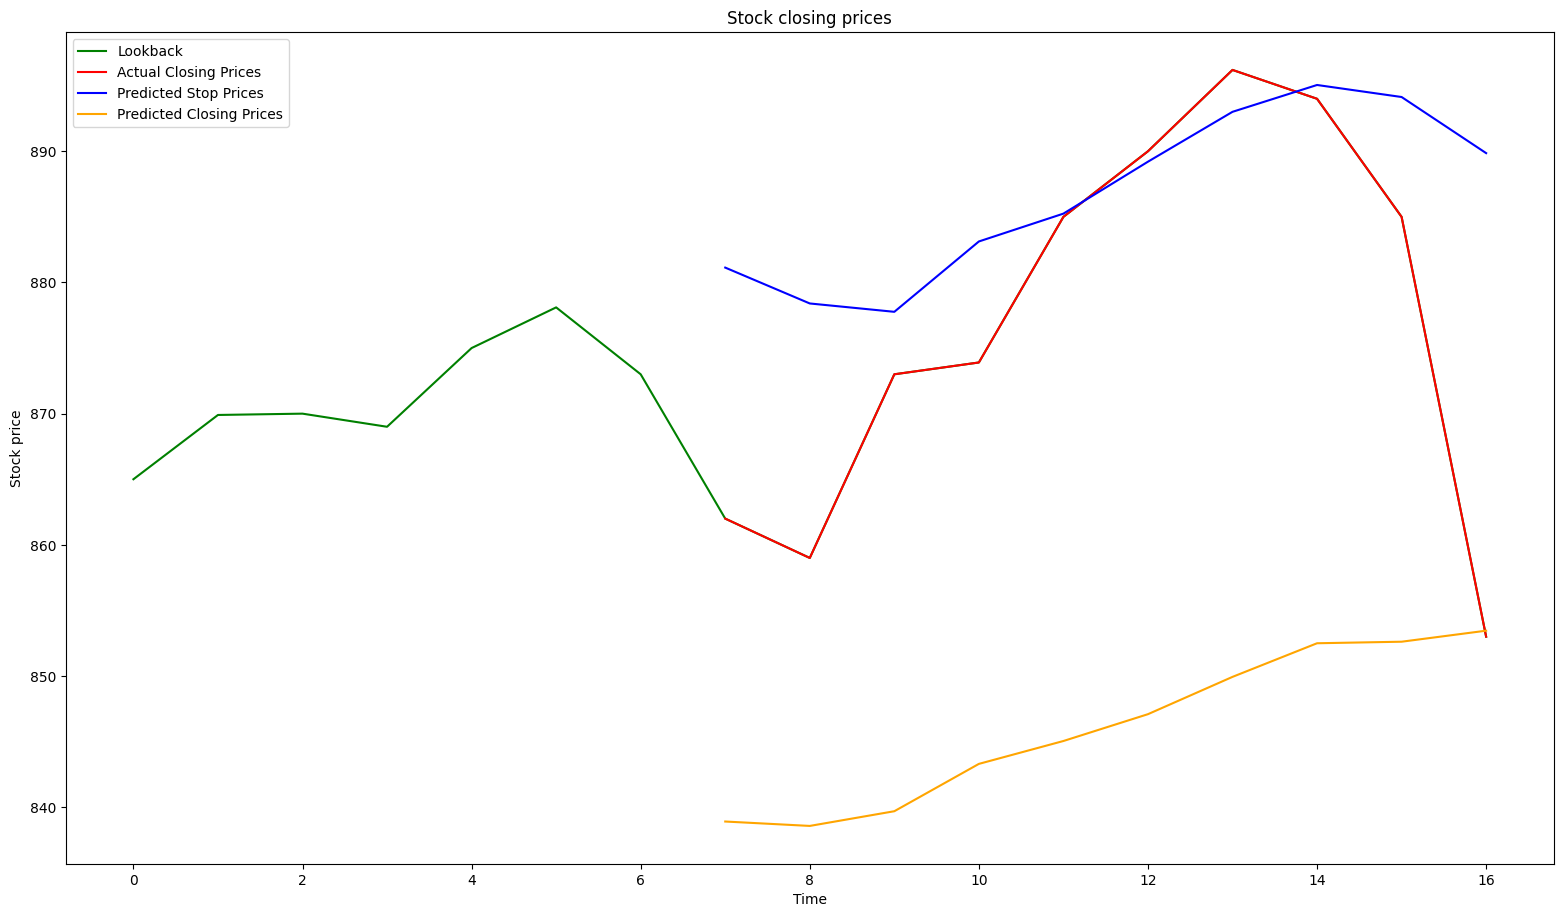

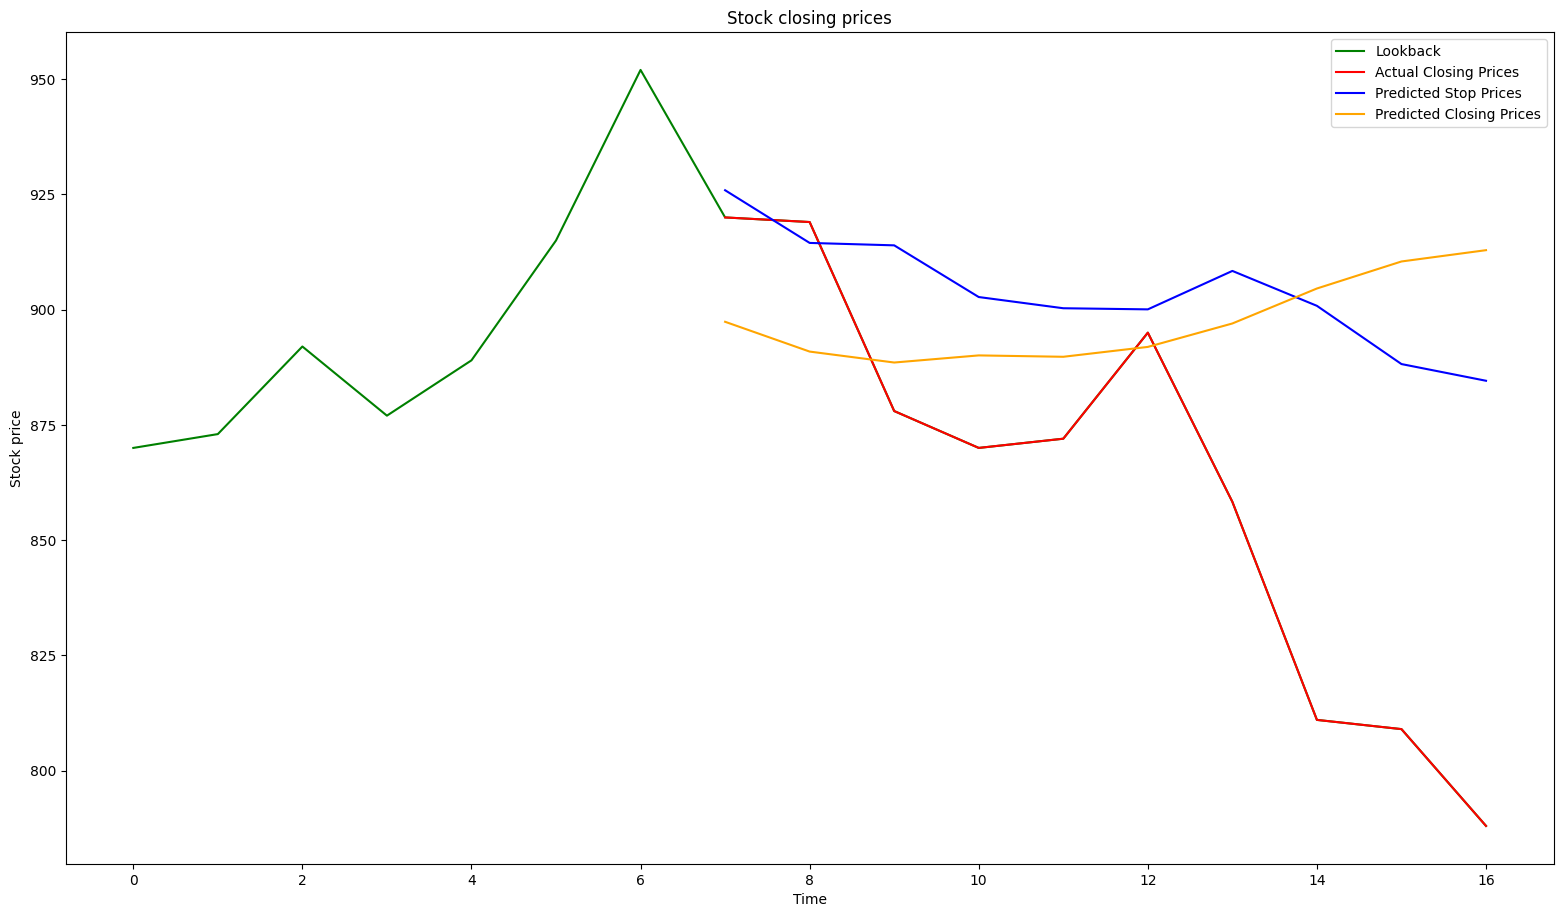

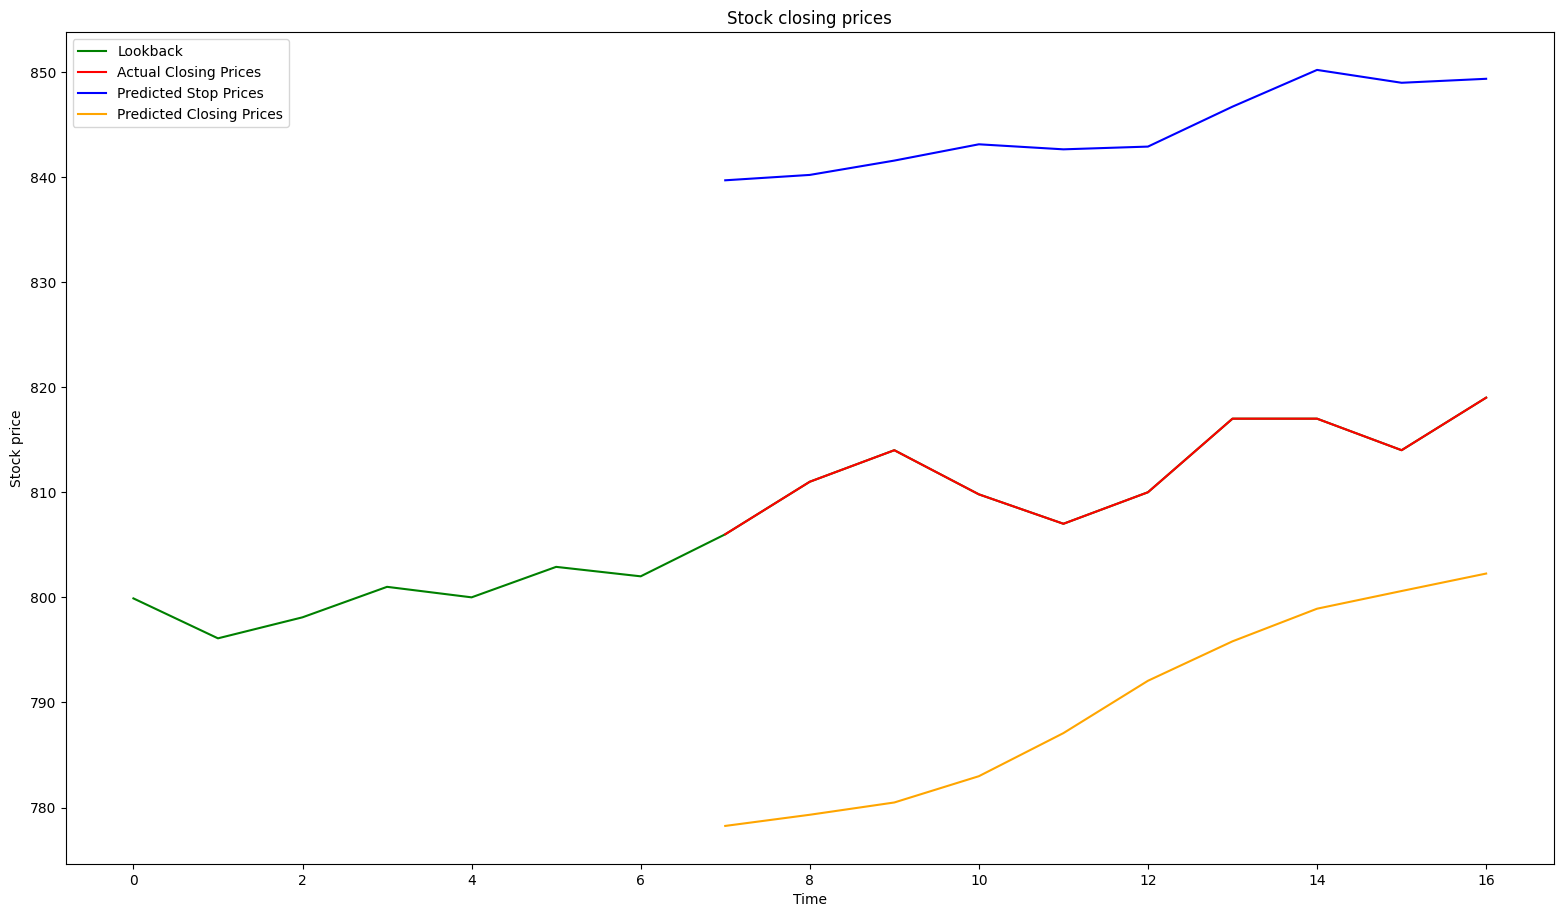

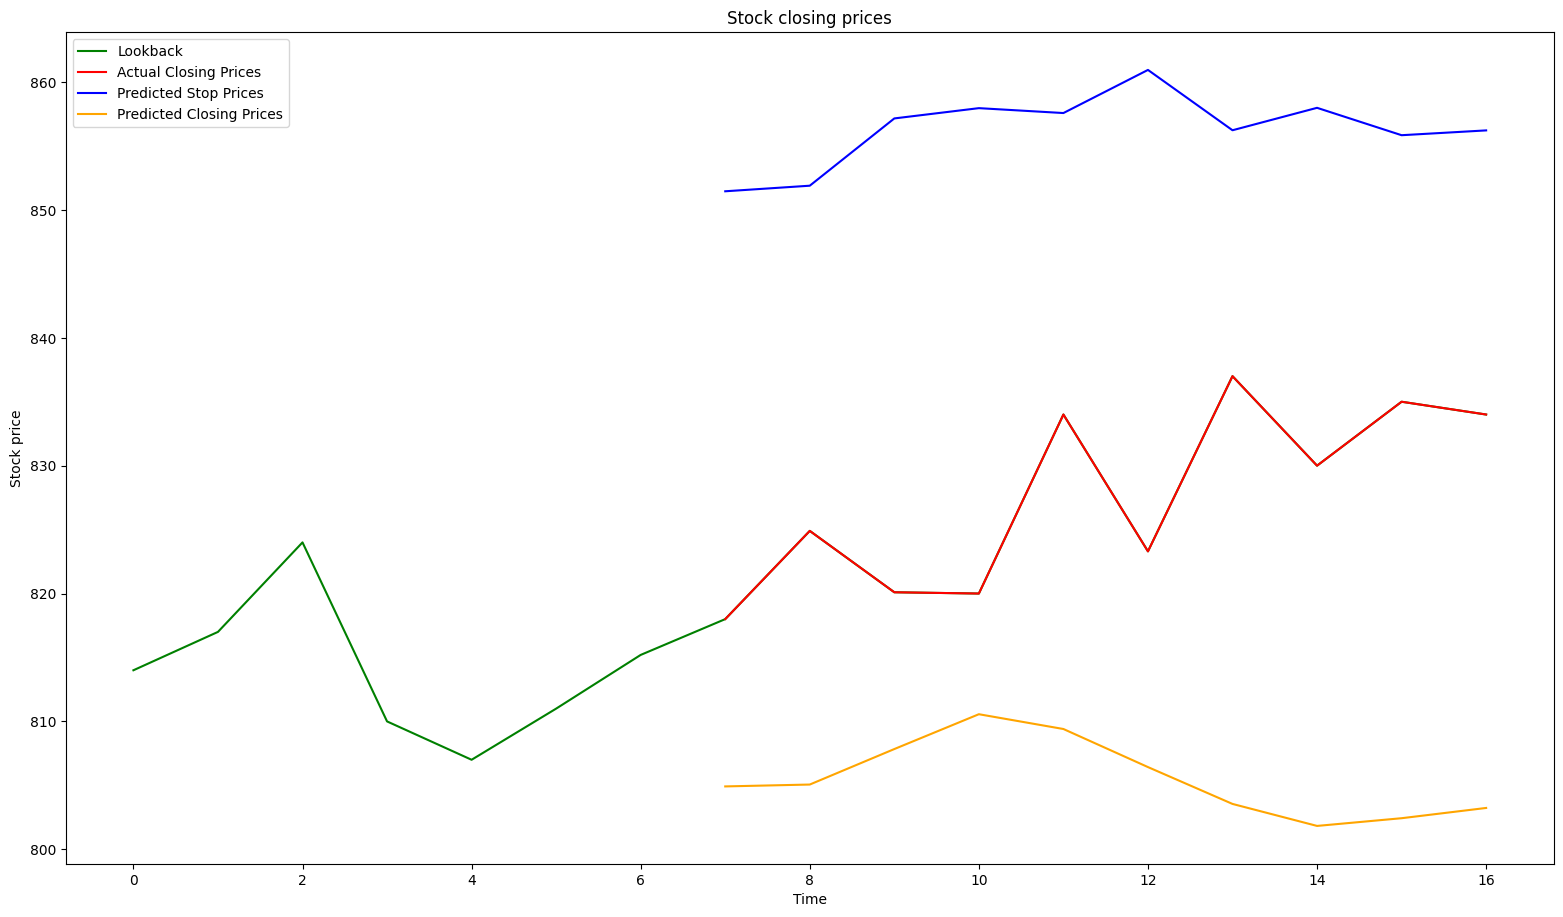

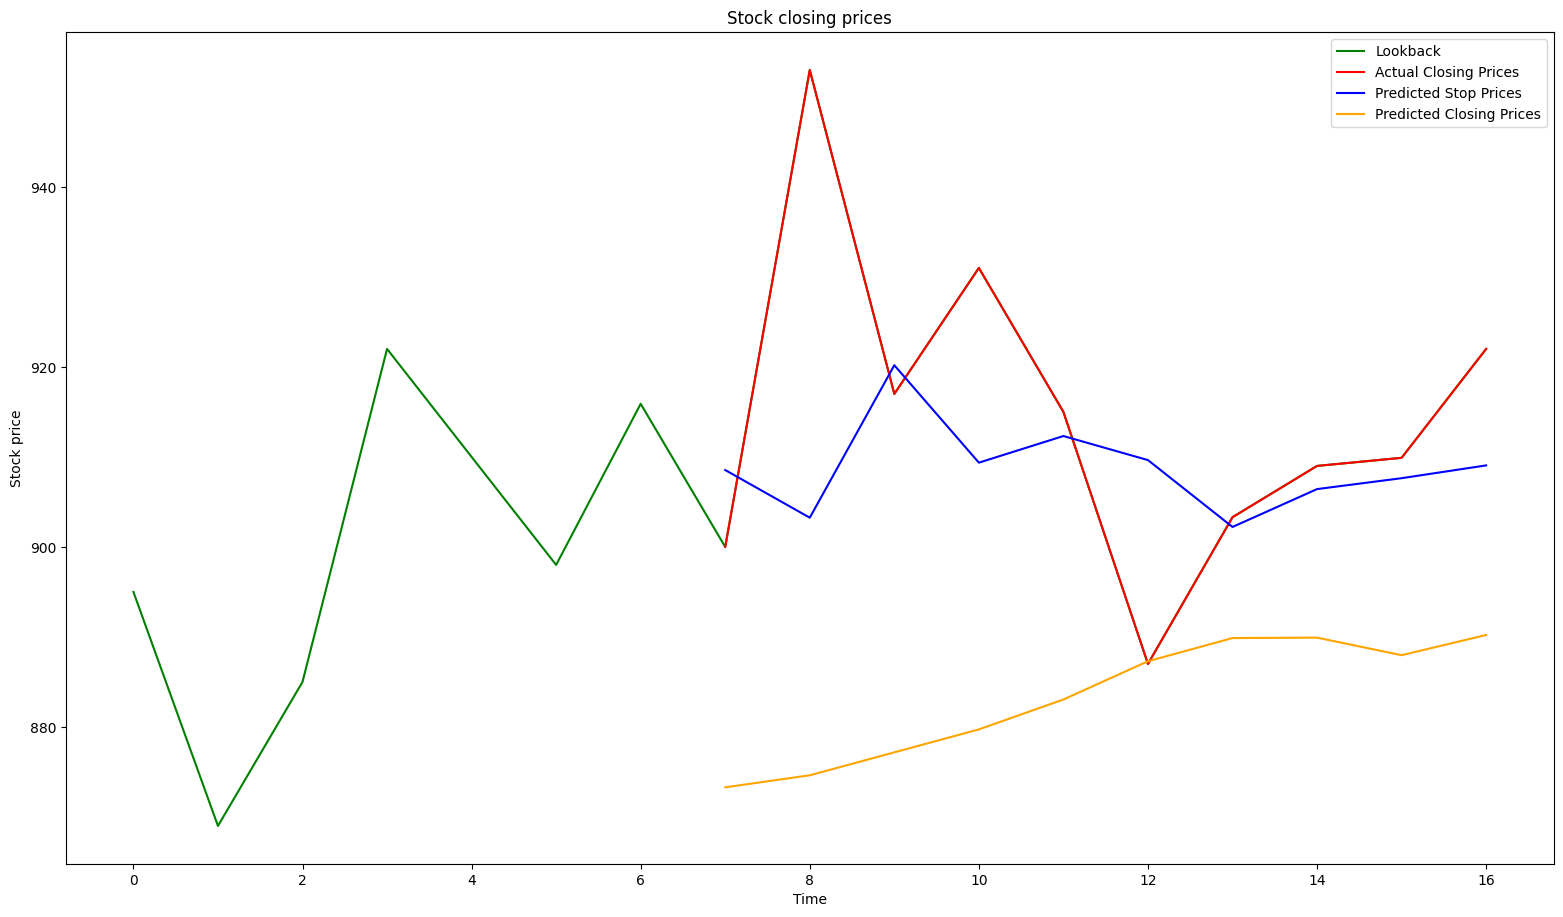

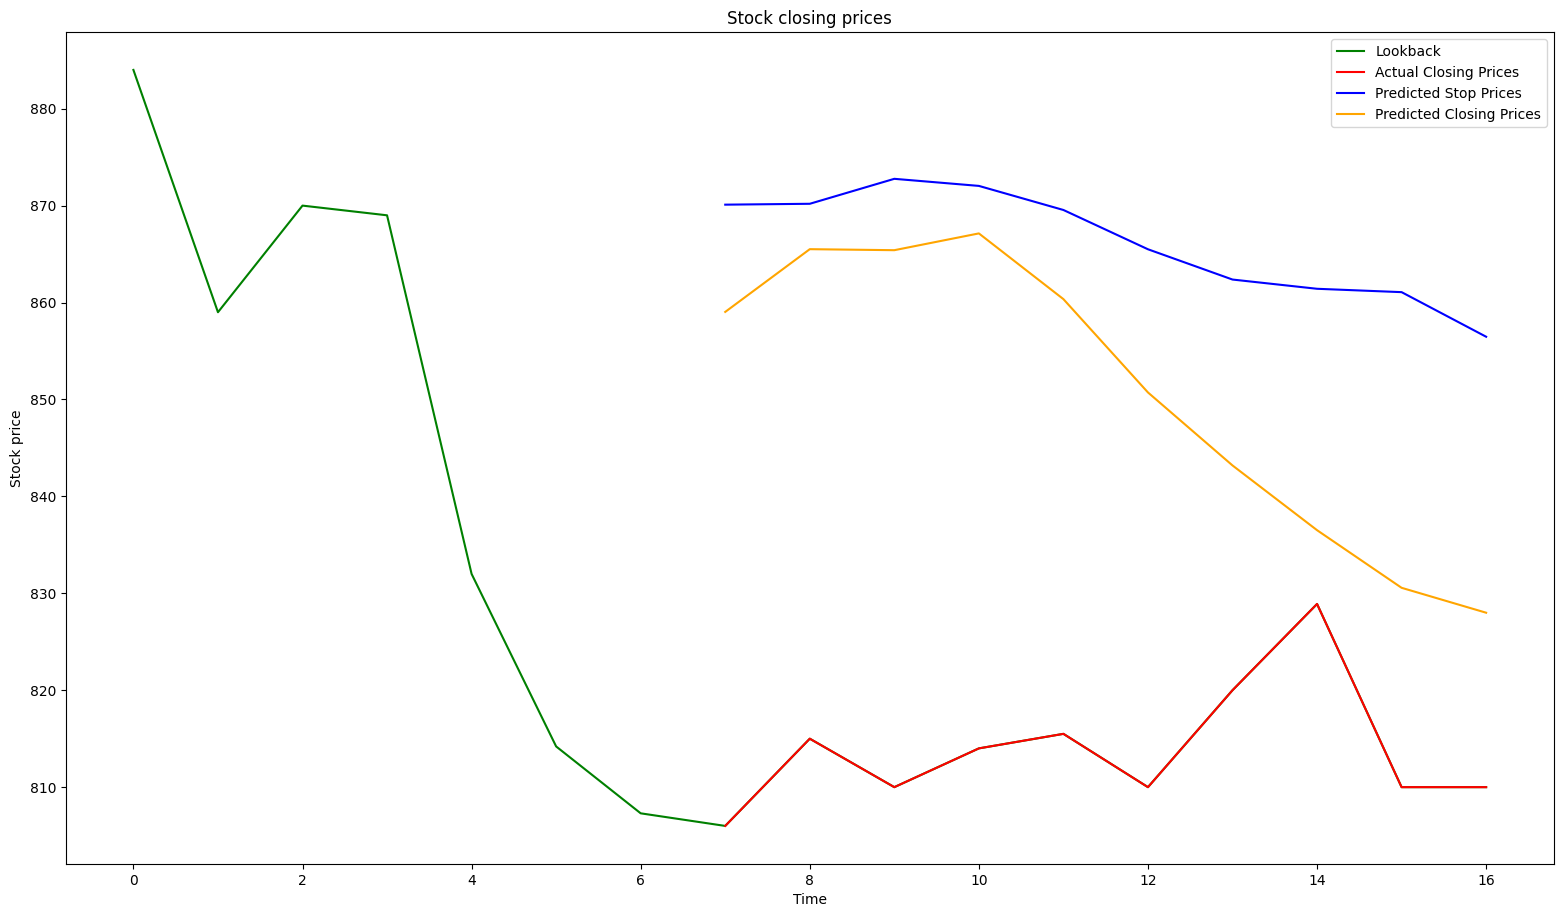

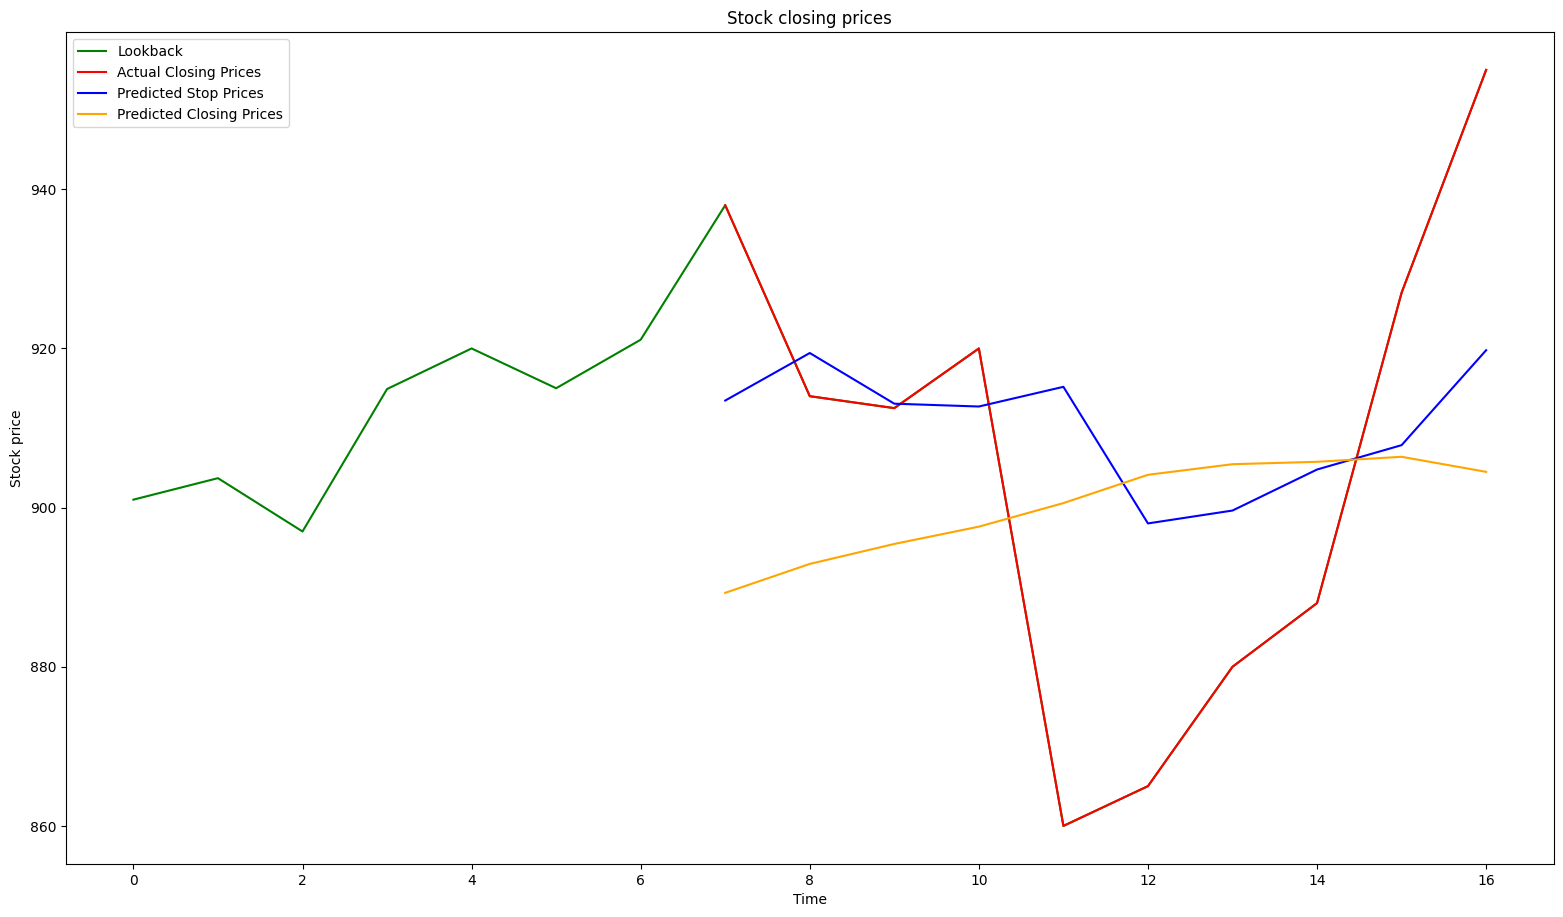

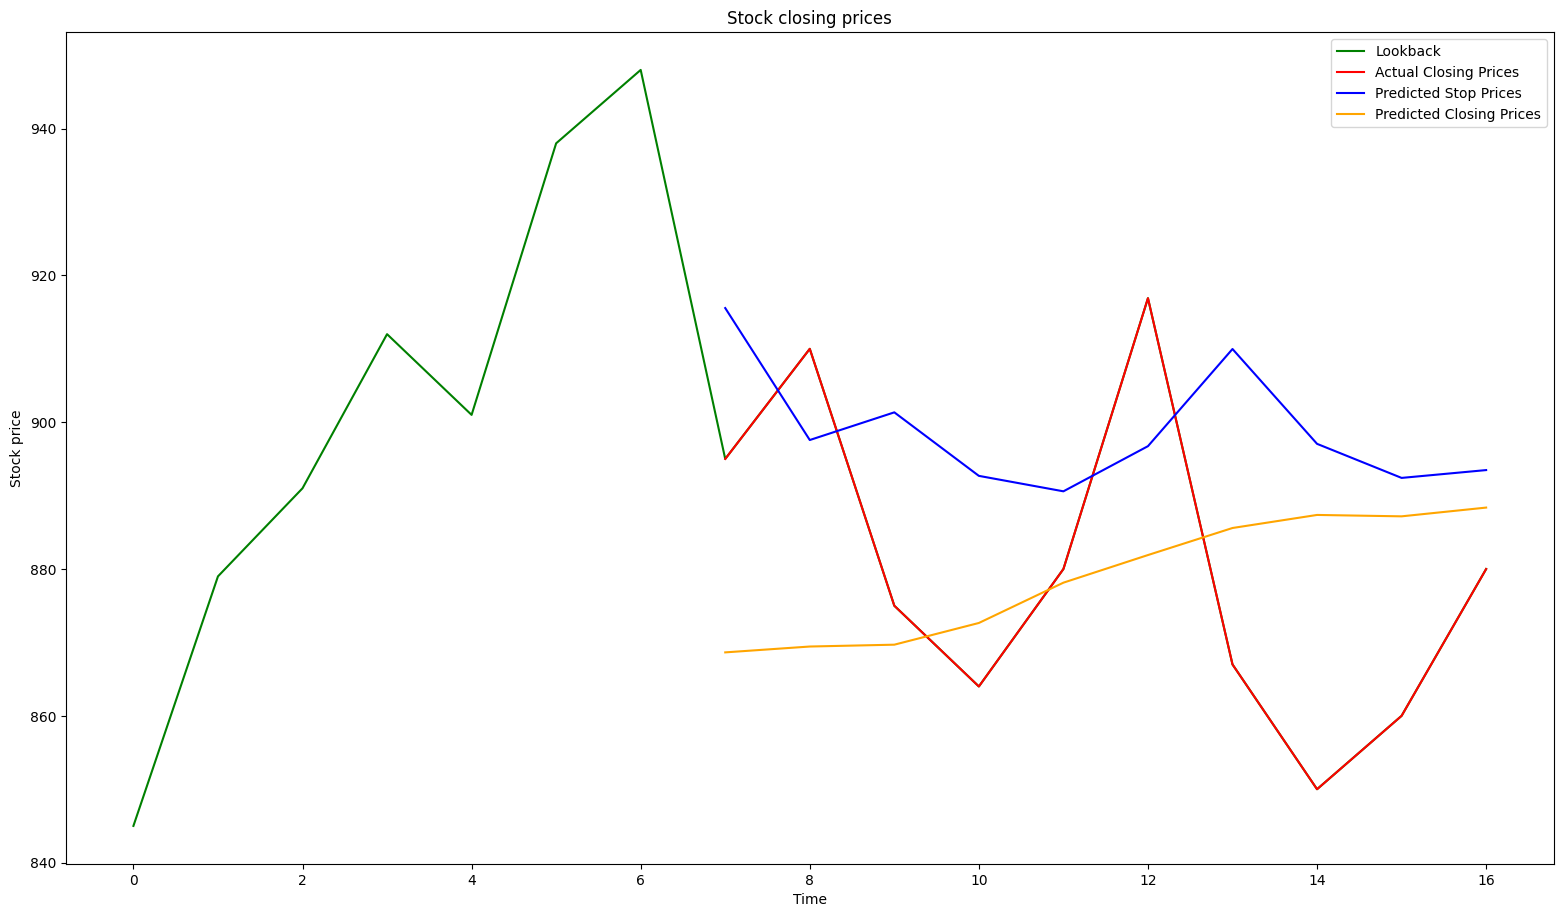

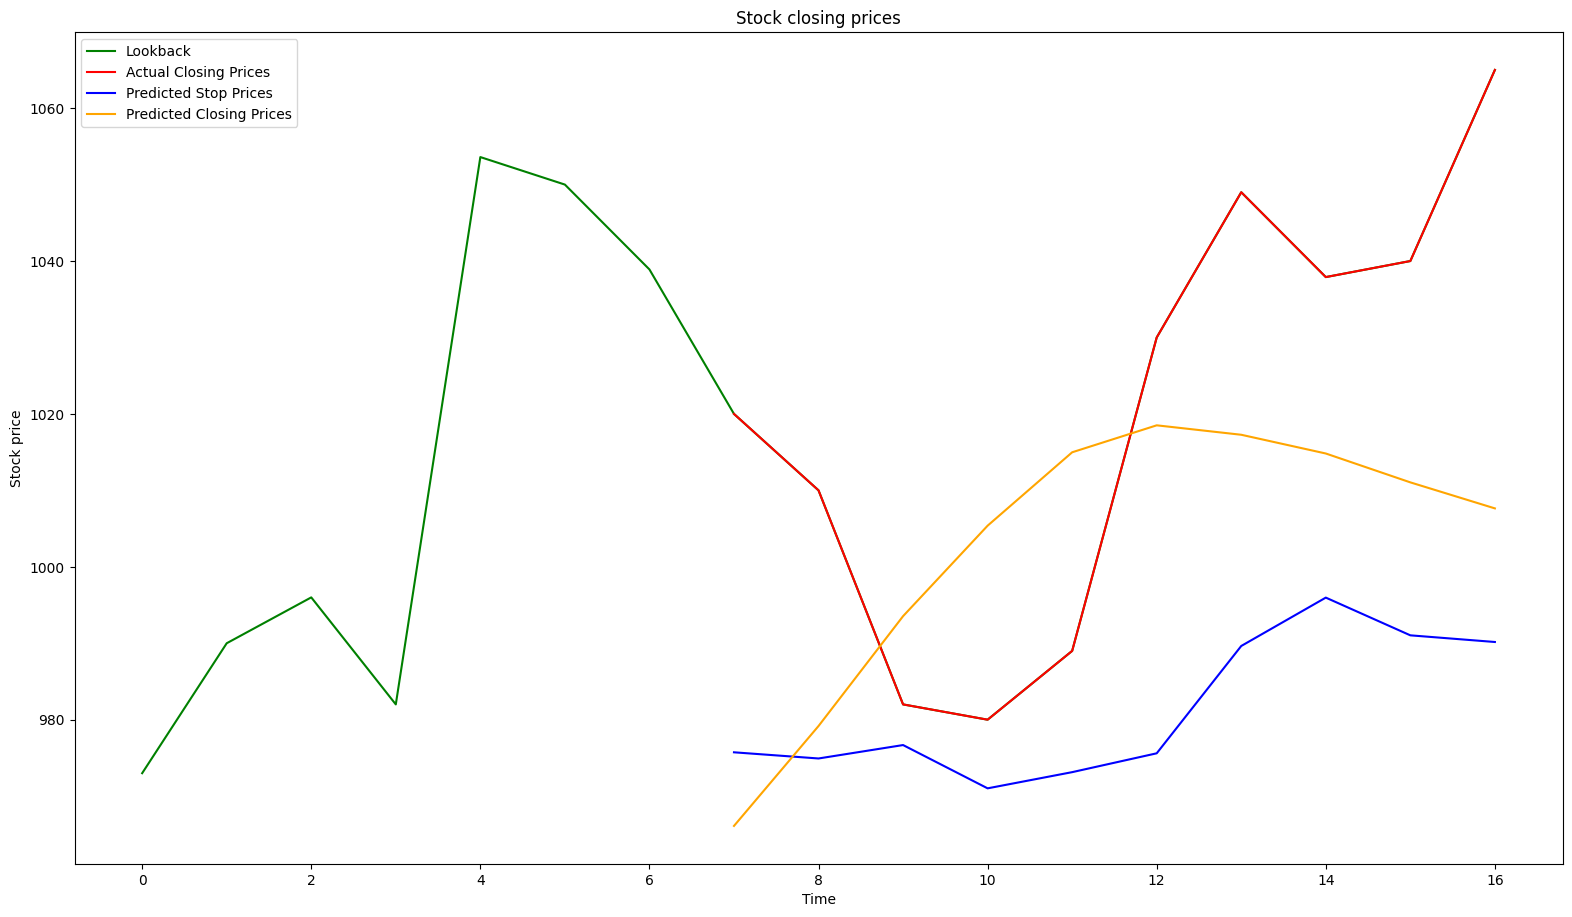

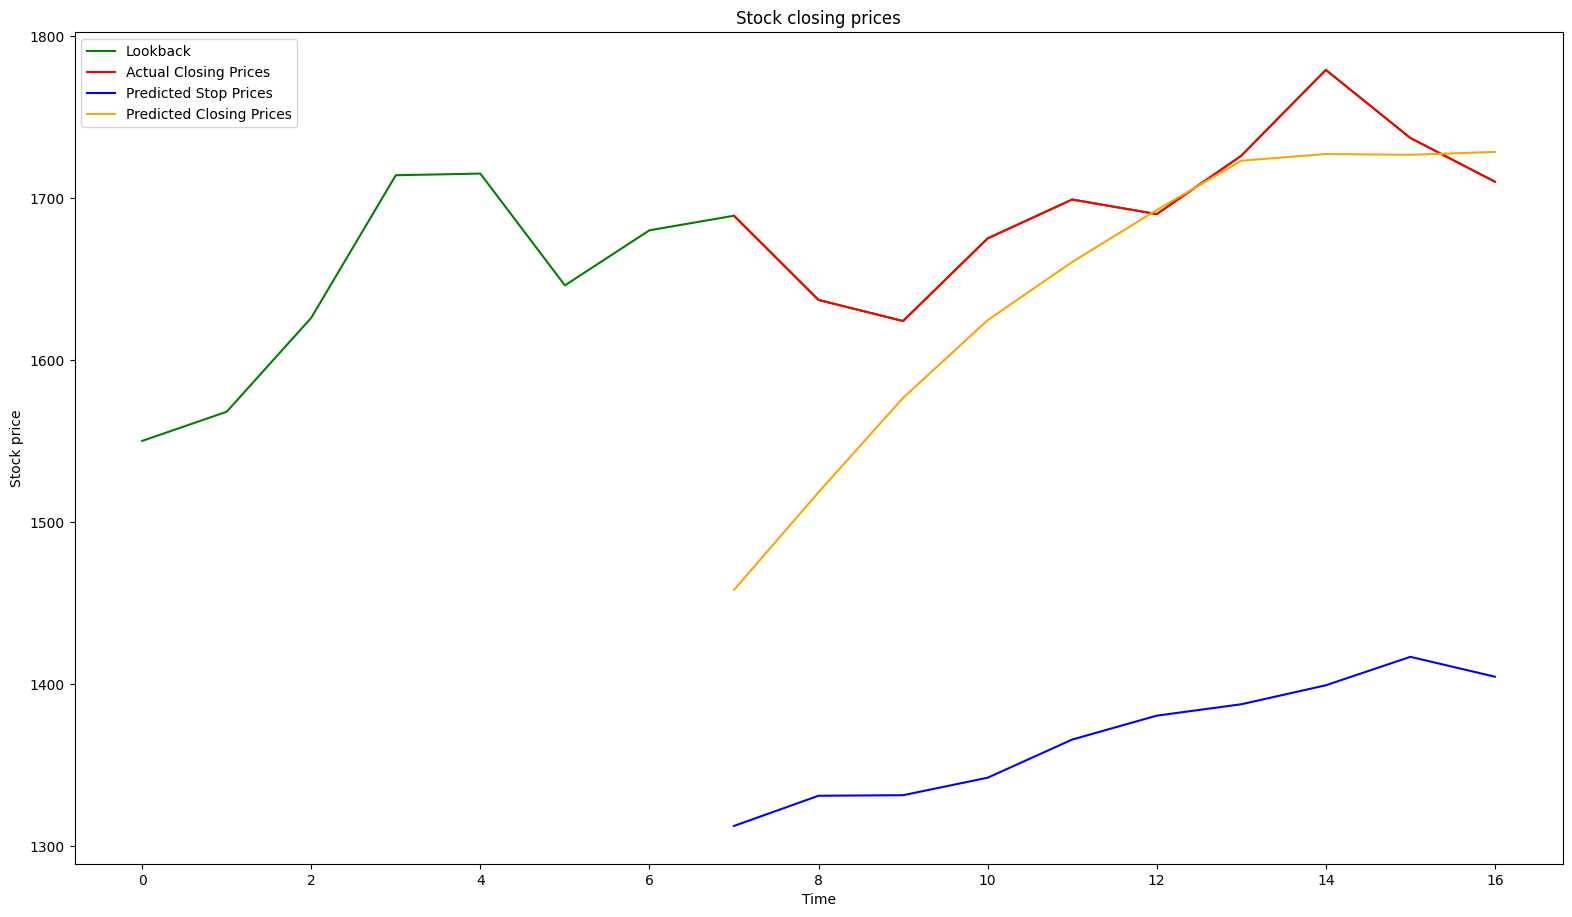

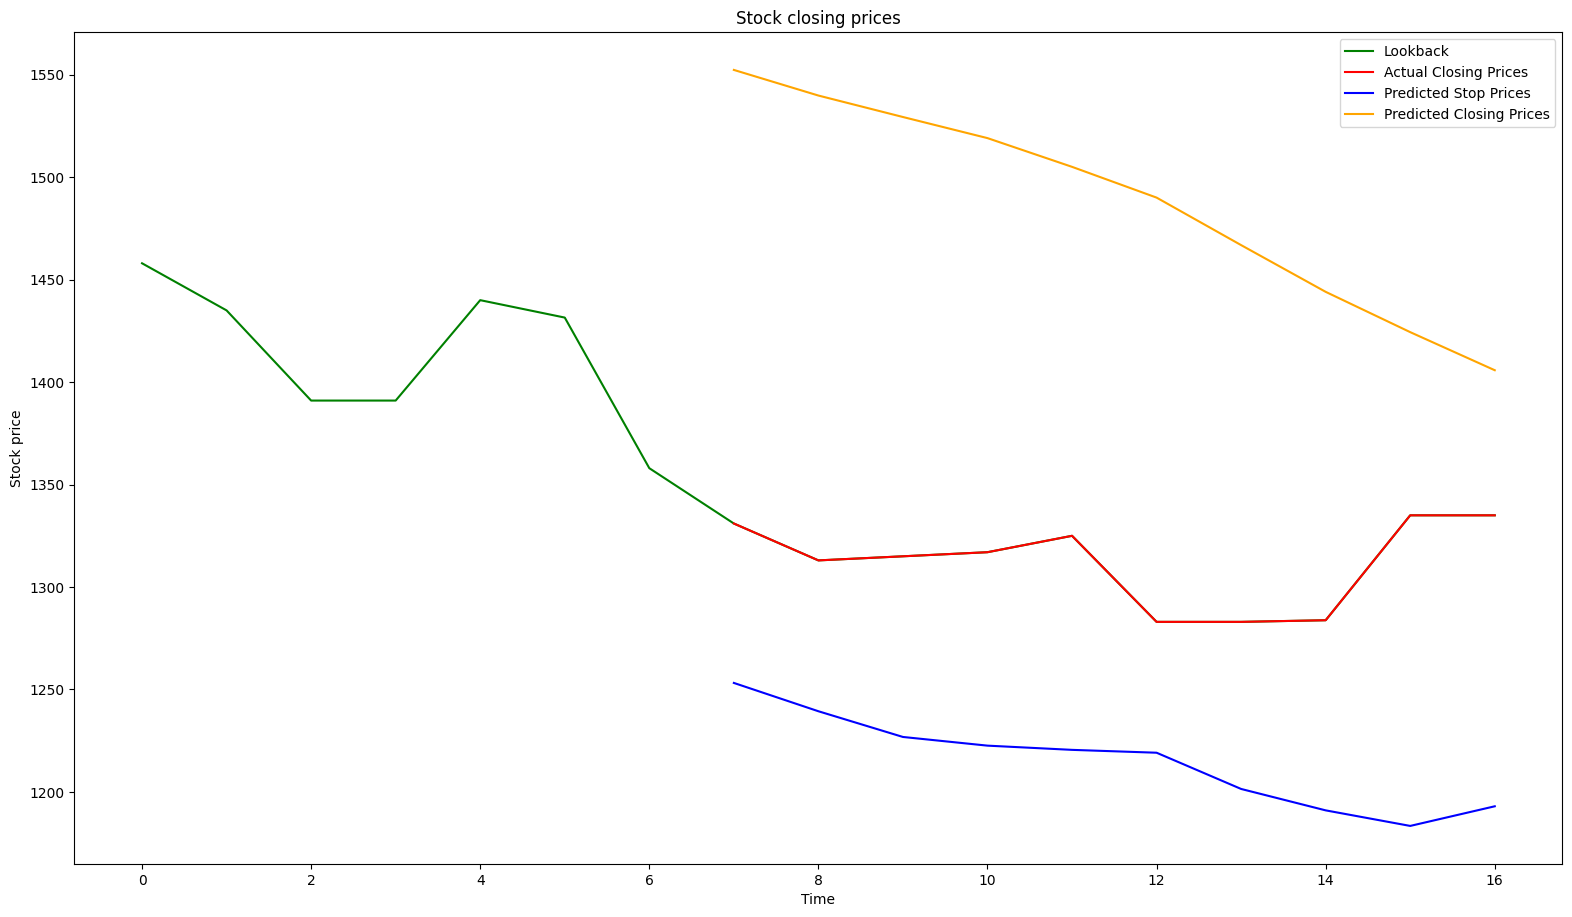

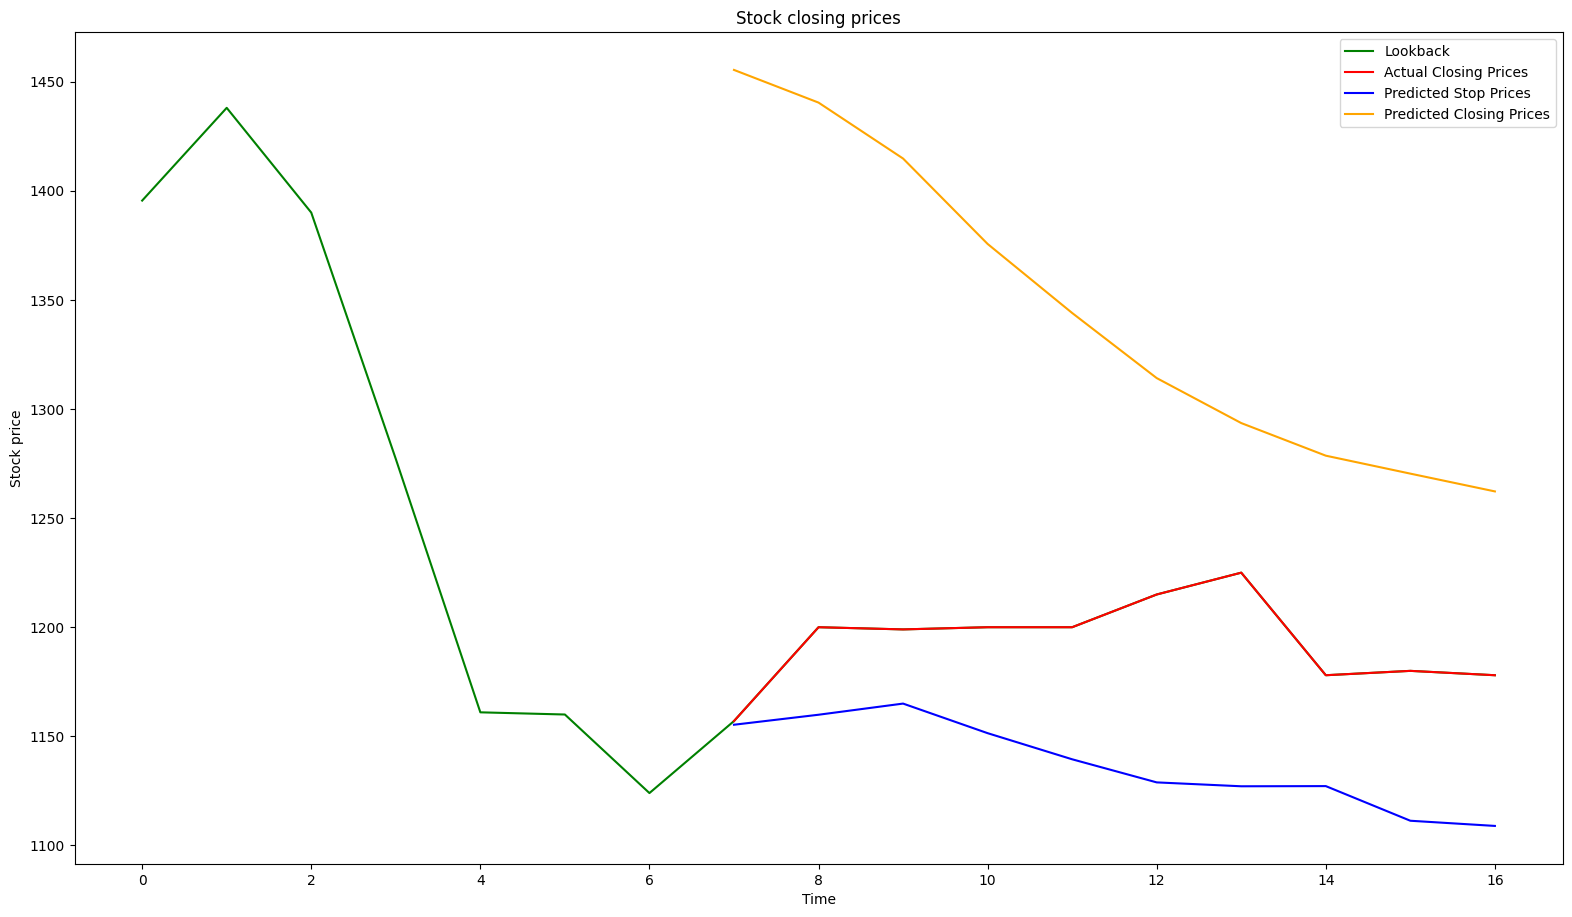

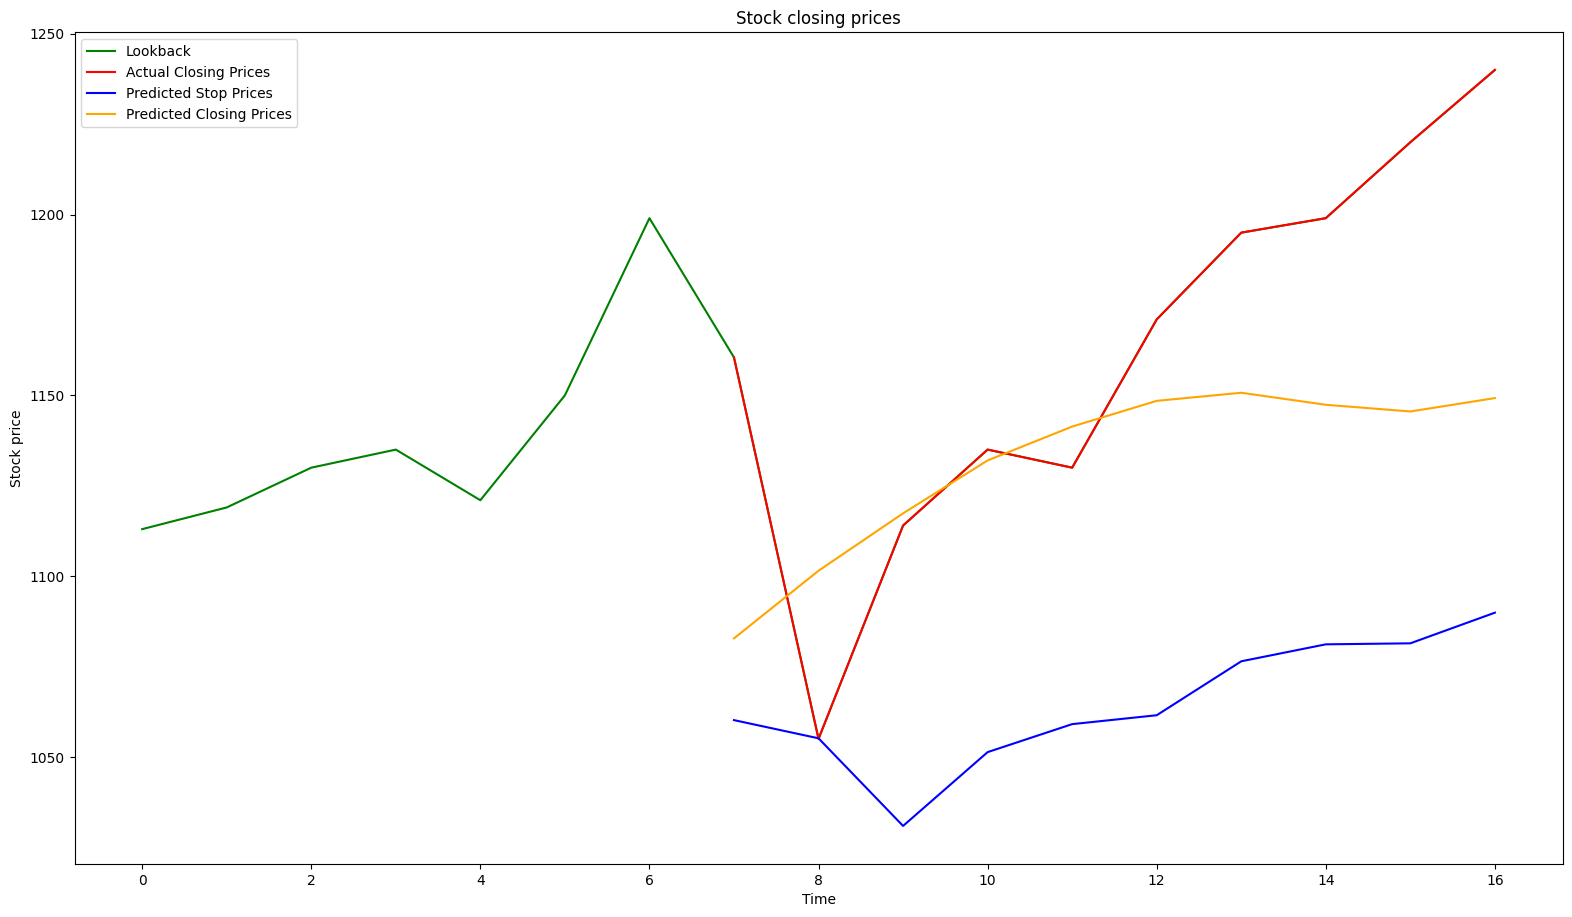

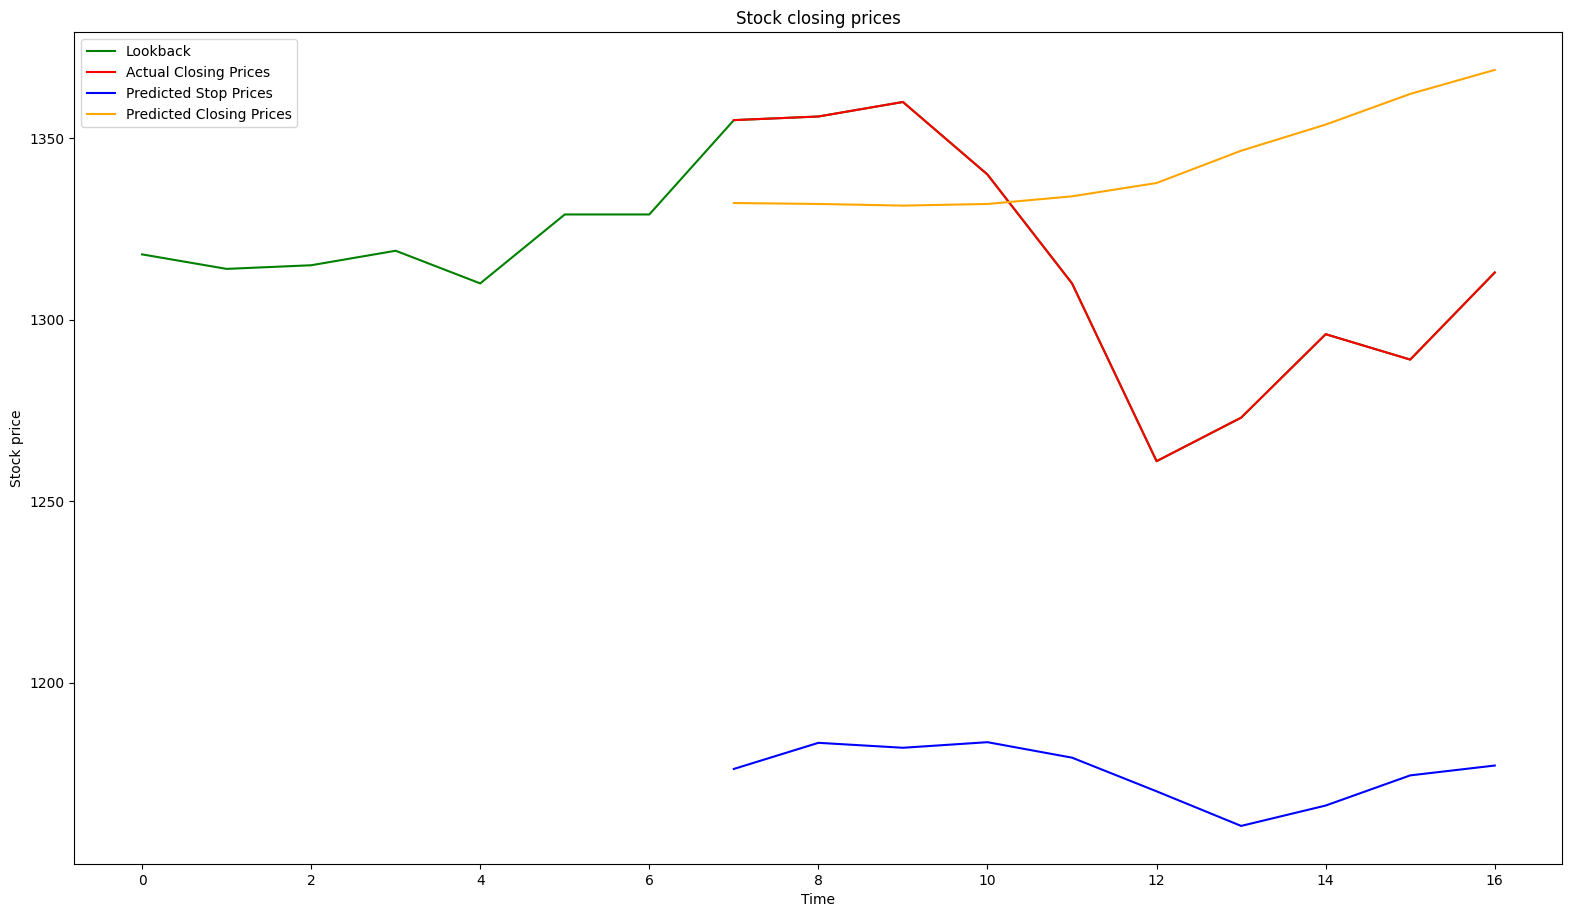

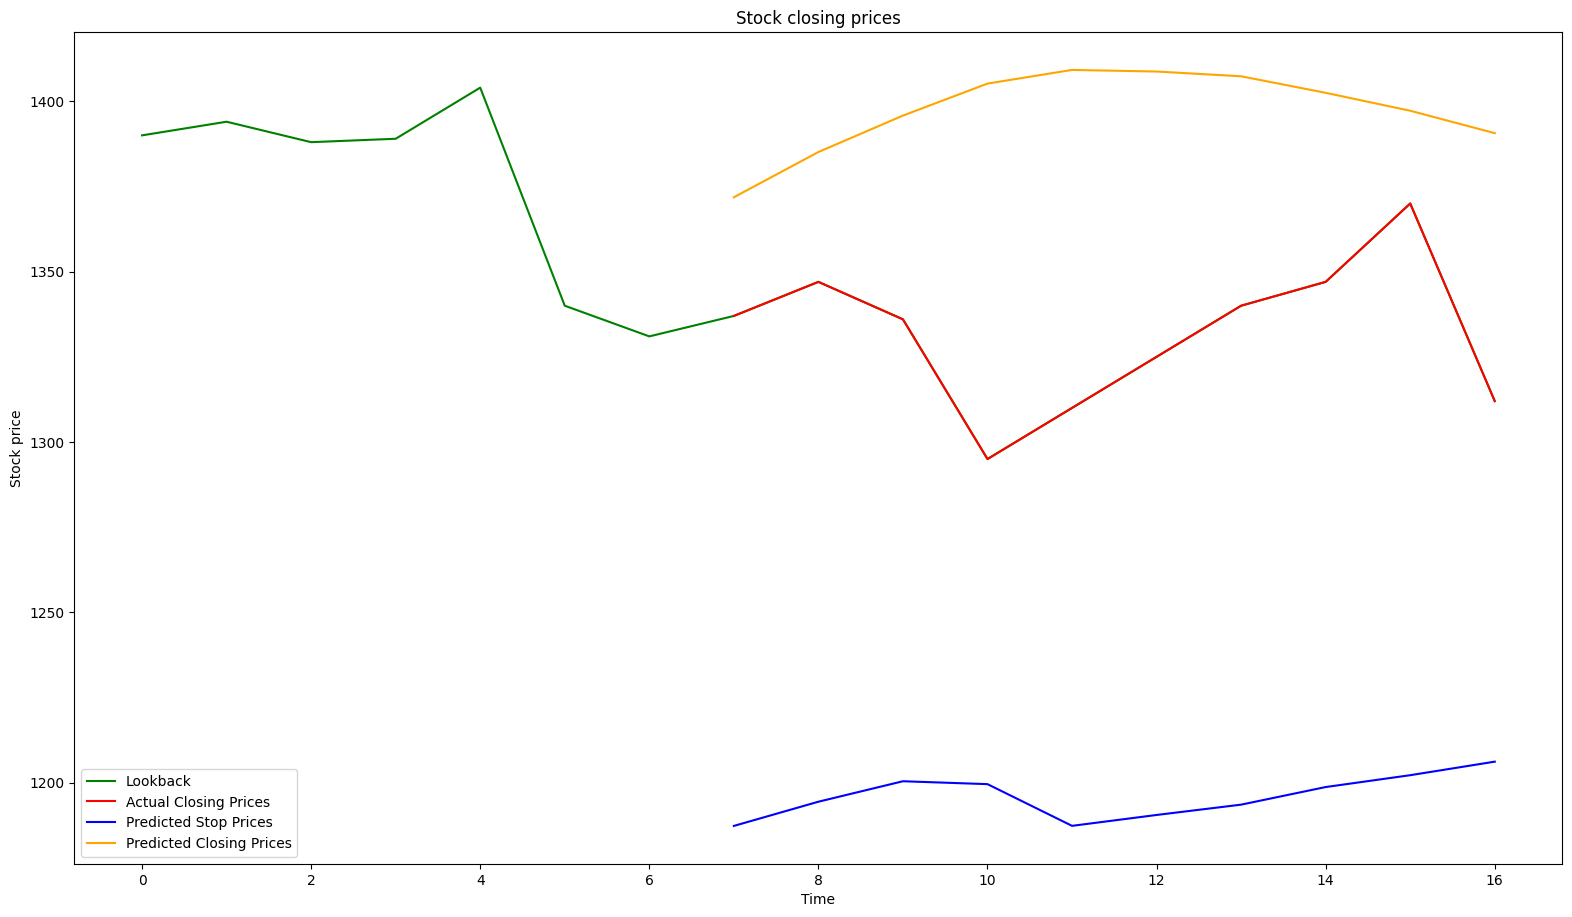

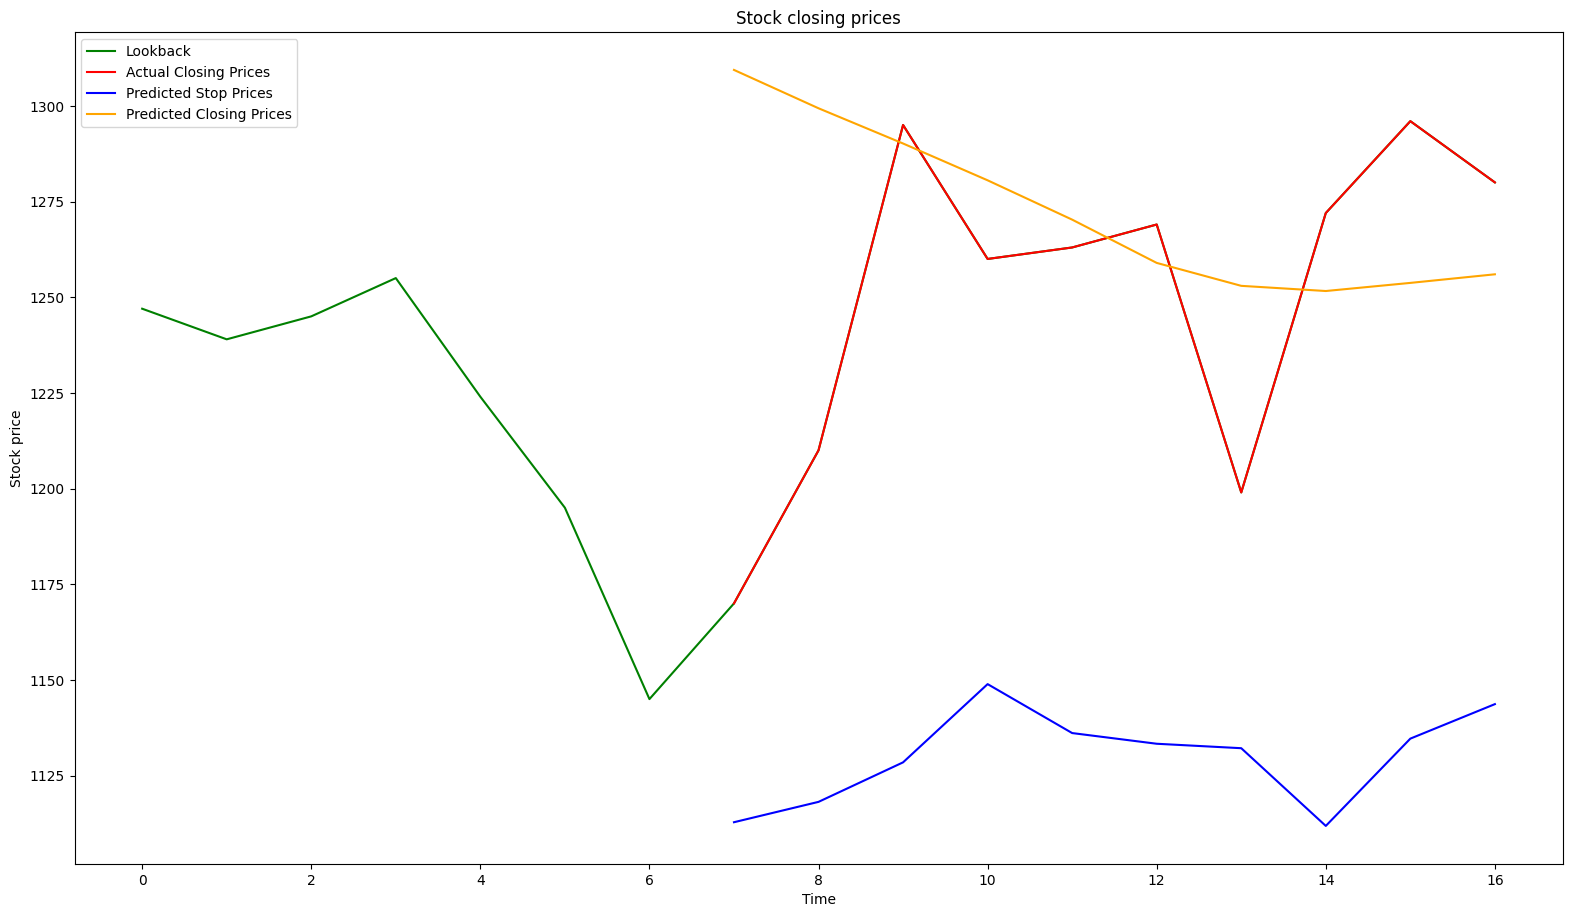

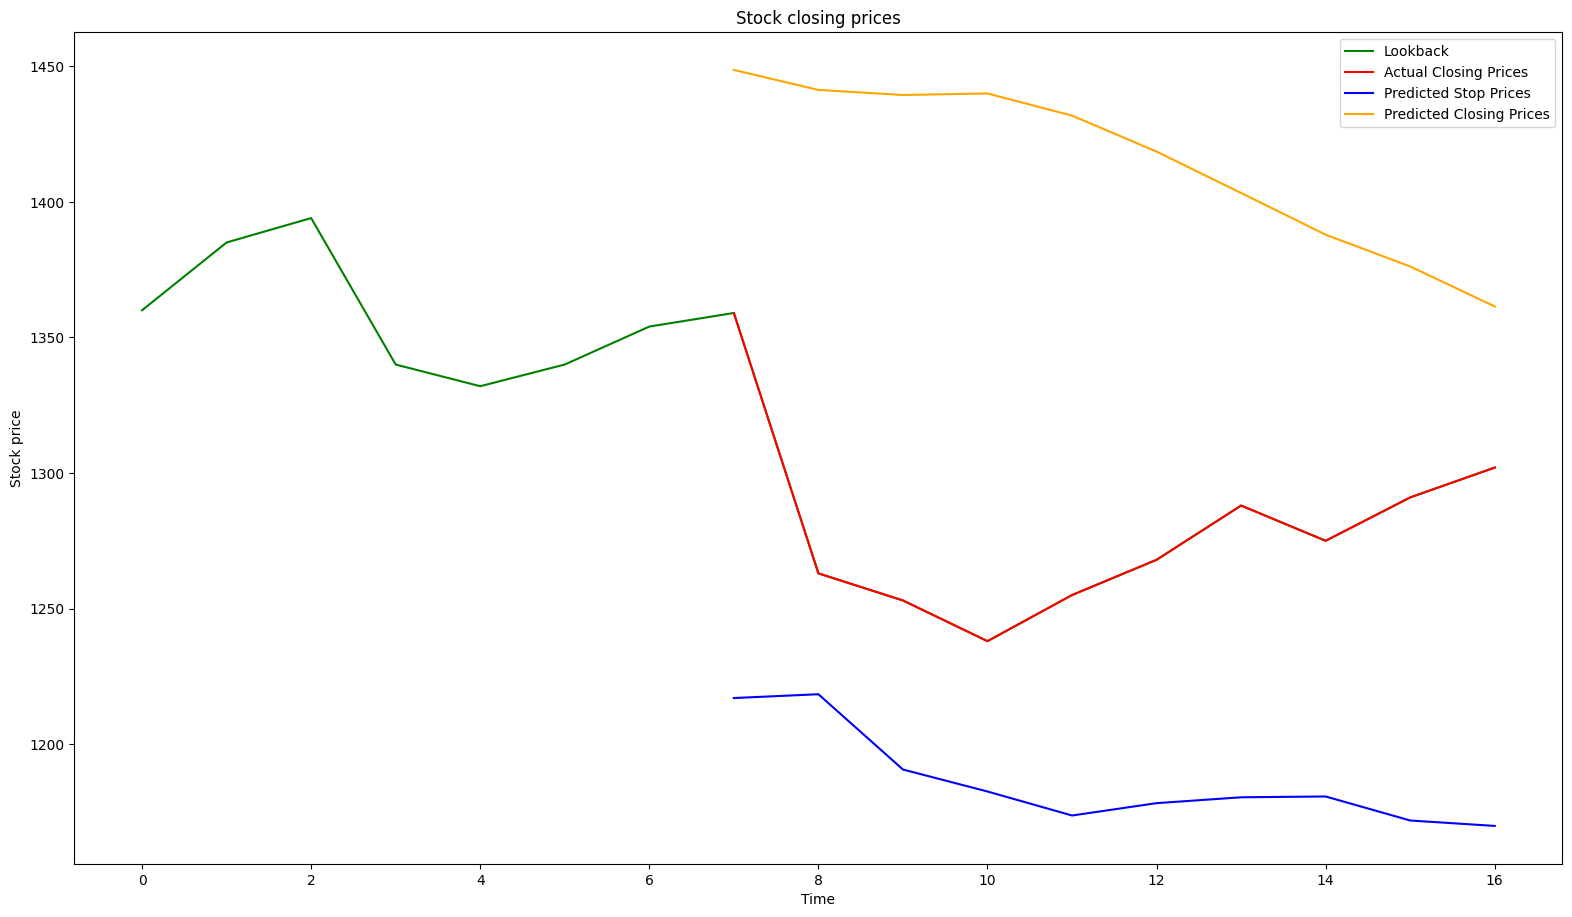

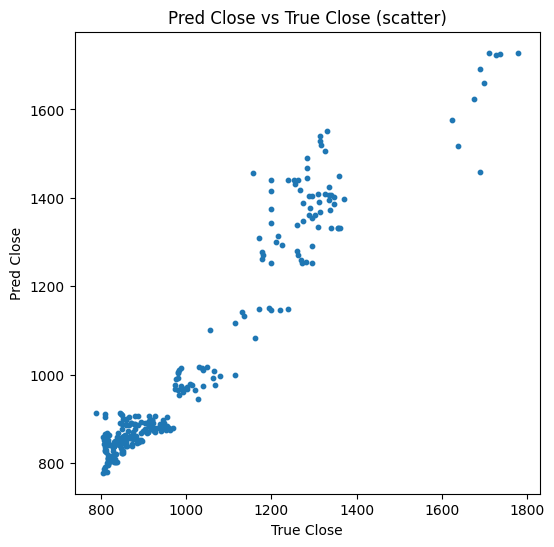

In [398]:
def rmse(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def run_many_windows(df, n_windows=20, lookback=7, horizon=10):
    # choose evenly spaced start points
    max_start = len(df) - (lookback + horizon)
    assert max_start > 0, "Not enough rows for requested lookback+horizon"

    starts = np.linspace(0, max_start, n_windows, dtype=int)

    all_pred_close = []
    all_true_close = []
    all_pred_stop = []
    all_true_stop = []

    for s in starts:
        w = df.iloc[s:s + lookback + horizon].copy()
        pred_close, pred_stop = torch_test(w, model, scaler, lookback)

        true_close = w["Close"].to_numpy()[lookback:]
        all_pred_close.append(pred_close)
        all_true_close.append(true_close)

        all_pred_stop.append(pred_stop)
        if "stop_price" in w.columns:
            all_true_stop.append(w["stop_price"].to_numpy()[lookback:])

    all_pred_close = np.concatenate(all_pred_close)
    all_true_close = np.concatenate(all_true_close)
    all_pred_stop = np.concatenate(all_pred_stop)

    print("Close RMSE:", rmse(all_pred_close, all_true_close))

    if len(all_true_stop) > 0:
        all_true_stop = np.concatenate(all_true_stop)
        if len(all_true_stop) == len(all_pred_stop):
            print("Stop RMSE:", rmse(all_pred_stop, all_true_stop))
        else:
            print("Stop RMSE skipped (shape mismatch)")

    # Plot aggregate scatter: True Close vs Pred Close
    plt.figure(figsize=(6, 6))
    plt.scatter(all_true_close, all_pred_close, s=10)
    plt.xlabel("True Close")
    plt.ylabel("Pred Close")
    plt.title("Pred Close vs True Close (scatter)")
    plt.show()

run_many_windows(test_df, n_windows=30, lookback=cfg.lookback_period, horizon=10)


In [399]:
df.head()

Open    High     Low   Close  Volume  price_change  \
Date                                                               
2021-01-03  1235.0  1304.0  1225.0  1302.0     0.0           1.0   
2021-01-04  1320.0  1346.0  1270.0  1291.0     0.0          -0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0     0.0          -0.1   
2021-01-06  1300.0  1300.0  1277.0  1288.0     0.0           0.1   
2021-01-07  1282.0  1295.0  1263.0  1268.0     0.0          -0.3   

            momentum_rsi  trend_sma_fast          wma  momentum  ...  pr_macd  \
Date                                                             ...            
2021-01-03     34.666667          1279.2  1278.800000     -52.0  ...        1   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  ...        1   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  ...       -1   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  ...        1   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  ...       -1   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03       1       1      1         -1         0         0         1   
2021-01-04      -1       1     -1         -1         0         0         1   
2021-01-05      -1       1     -1         -1         0         0         0   
2021-01-06      -1       1      1         -1         0         0         1   
2021-01-07       1       1     -1         -1         0         0         1   

            trend   stop_price  
Date                            
2021-01-03   11.0  1284.085490  
2021-01-04   16.0  1273.236841  
2021-01-05  -13.0  1257.456989  
2021-01-06   20.0  1270.278119  
2021-01-07   13.0  1250.553303  

[5 rows x 34 columns]

In [400]:
def plot_predictions_date_range(
    df: pd.DataFrame,
    model,
    scaler,
    start: str | pd.Timestamp,
    end: str | pd.Timestamp,
    lookback: int,
    title: str | None = None,
):
    """
    Plots: actual Close, predicted Close, predicted stop_price for [start, end].
    Requires that there are at least `lookback` rows BEFORE `start` in df.
    """
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    if start not in df.index:
        # snap to next available timestamp
        start = df.index[df.index.searchsorted(start)]
    if end not in df.index:
        # snap to previous available timestamp
        end = df.index[df.index.searchsorted(end, side="right") - 1]

    start_pos = df.index.get_loc(start)
    end_pos = df.index.get_loc(end)

    if start_pos < lookback:
        raise ValueError(
            f"Need at least {lookback} rows before start date. "
            f"Start position={start_pos}, lookback={lookback}."
        )

    # Slice must include lookback context BEFORE start
    ctx_slice = df.iloc[start_pos - lookback : end_pos + 1].copy()

    # Run inference: returns predictions for every row after lookback in ctx_slice
    pred_close, pred_stop = torch_test(ctx_slice, model, scaler, lookback)

    # Dates corresponding to predictions
    pred_dates = ctx_slice.index[lookback:]  # length matches pred_close/pred_stop

    # Actual close for those dates
    actual_close = ctx_slice["Close"].to_numpy()[lookback:]

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(pred_dates, actual_close, label="Actual Close")
    plt.plot(pred_dates, pred_close, label="Predicted Close")
    plt.plot(pred_dates, pred_stop, label="Predicted Stop")

    plt.xlabel("Date")
    plt.ylabel("Price")
    if title is None:
        title = f"Predictions from {pred_dates[0].date()} to {pred_dates[-1].date()}"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return series (handy for debugging)
    out = pd.DataFrame(
        {
            "actual_close": actual_close,
            "pred_close": pred_close,
            "pred_stop": pred_stop,
        },
        index=pred_dates,
    )
    return out


[ 931.9386   930.4063   930.3537   936.52026  915.2365   896.6643
  896.9921   900.75366  904.33405  901.9977   904.0338   905.25903
  904.4584   896.07556  890.3612   886.3395   886.2977   884.97406
  887.58124  891.7831   896.6022   900.1545   894.027    887.95624
  889.3966   919.1389   904.0026   899.69135  897.95056  895.4426
  892.26294  886.2986   887.28345  882.59375  880.71716  879.32117
  875.8882   871.8436   864.7603   868.6632   870.11707  869.90186
  867.3174   868.8168   885.8889   873.3979   876.34204  879.9785
  883.4885   885.4774   884.0526   883.88763  881.74536  883.729
  880.23114  877.28015  873.3956   870.26373  869.16406  869.37354
  869.3043   865.4281   863.4184   862.75806  860.72327  858.5416
  863.9627   864.0564   862.69727  863.93835  861.7186   859.0451
  854.9306   856.21436  856.2251   857.29895  859.2969   863.3955
  862.6438   861.5611   857.7841   854.2751   852.223    854.55896
  848.8289   848.95325  854.40936  861.139    864.6907   864.75946
  8

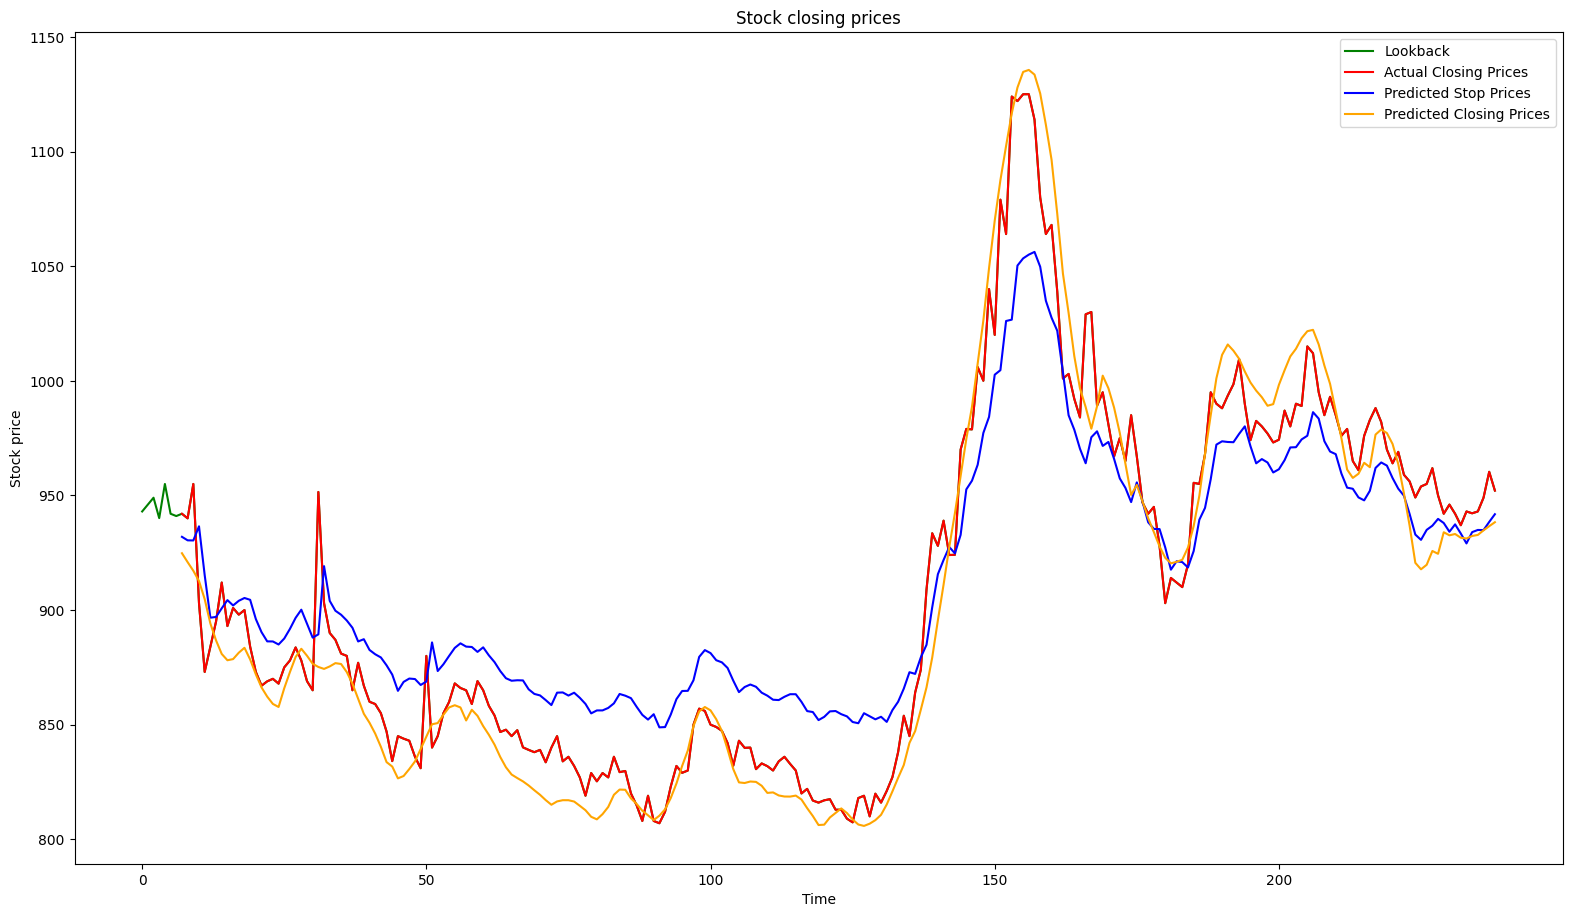

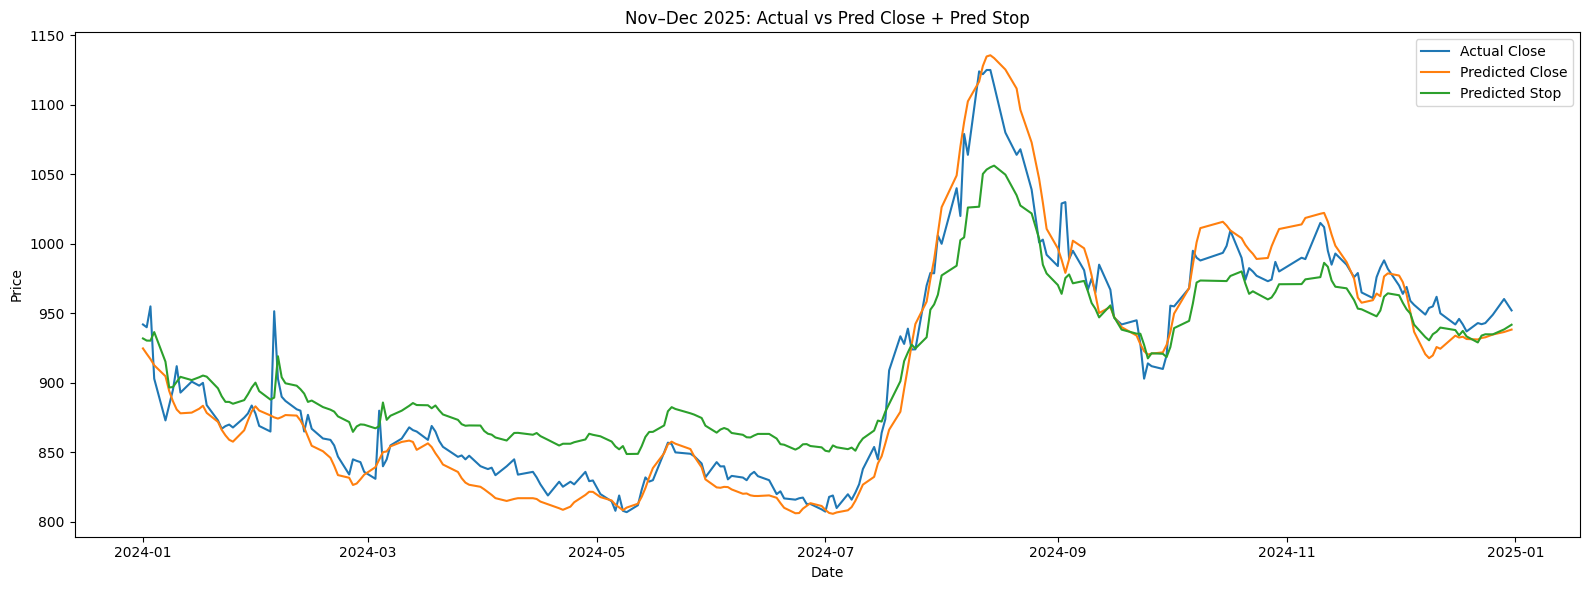

actual_close  pred_close   pred_stop
Date                                            
2024-01-01         942.0  924.782349  931.938599
2024-01-02         940.0  920.887146  930.406311
2024-01-03         955.0  917.139282  930.353699
2024-01-04         903.0  912.661316  936.520264
2024-01-07         873.0  904.764404  915.236511

In [401]:
out = plot_predictions_date_range(
    df=df,
    model=model,
    scaler=scaler,
    start="2024-01-01",
    end="2024-12-31",
    lookback=cfg.lookback_period,
    title="Nov–Dec 2025: Actual vs Pred Close + Pred Stop",
)
out.head()


In [402]:
df.head()

Open    High     Low   Close  Volume  price_change  \
Date                                                               
2021-01-03  1235.0  1304.0  1225.0  1302.0     0.0           1.0   
2021-01-04  1320.0  1346.0  1270.0  1291.0     0.0          -0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0     0.0          -0.1   
2021-01-06  1300.0  1300.0  1277.0  1288.0     0.0           0.1   
2021-01-07  1282.0  1295.0  1263.0  1268.0     0.0          -0.3   

            momentum_rsi  trend_sma_fast          wma  momentum  ...  pr_macd  \
Date                                                             ...            
2021-01-03     34.666667          1279.2  1278.800000     -52.0  ...        1   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  ...        1   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  ...       -1   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  ...        1   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  ...       -1   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03       1       1      1         -1         0         0         1   
2021-01-04      -1       1     -1         -1         0         0         1   
2021-01-05      -1       1     -1         -1         0         0         0   
2021-01-06      -1       1      1         -1         0         0         1   
2021-01-07       1       1     -1         -1         0         0         1   

            trend   stop_price  
Date                            
2021-01-03   11.0  1284.085490  
2021-01-04   16.0  1273.236841  
2021-01-05  -13.0  1257.456989  
2021-01-06   20.0  1270.278119  
2021-01-07   13.0  1250.553303  

[5 rows x 34 columns]

[886.5395  885.2251  883.92896 881.6478  884.5116  883.5985  882.501  ]
[877.80360228 864.07513069 863.75953364 861.68842801 850.17899816
 895.84888905 864.08499309 859.84415776 856.23451652 852.33886546
 856.24437893 857.13199563 852.95033474 857.43773027]


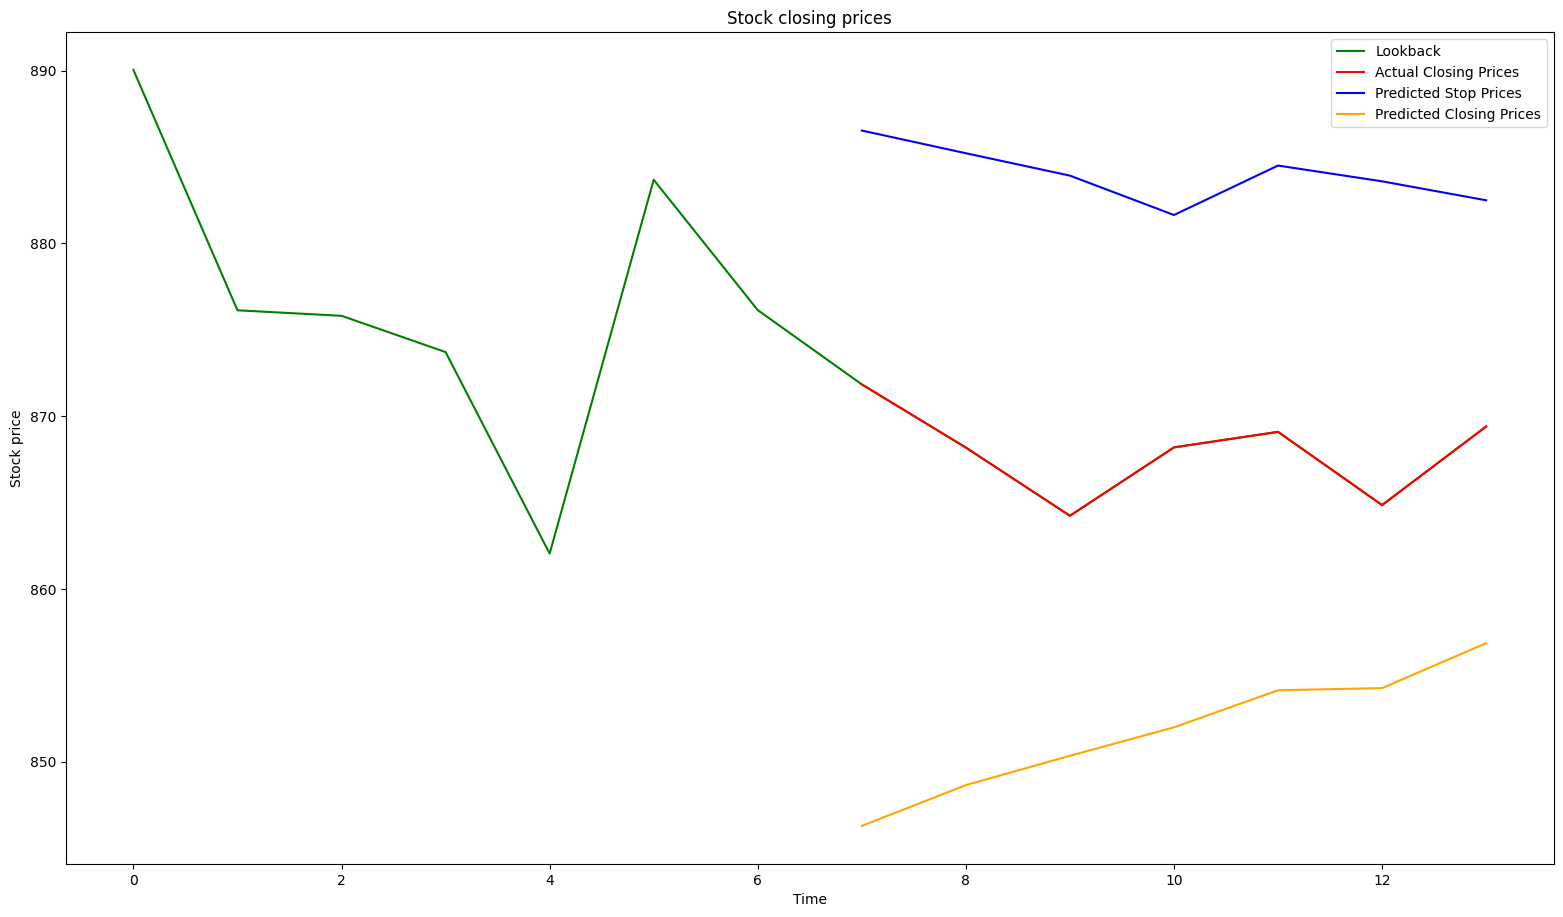

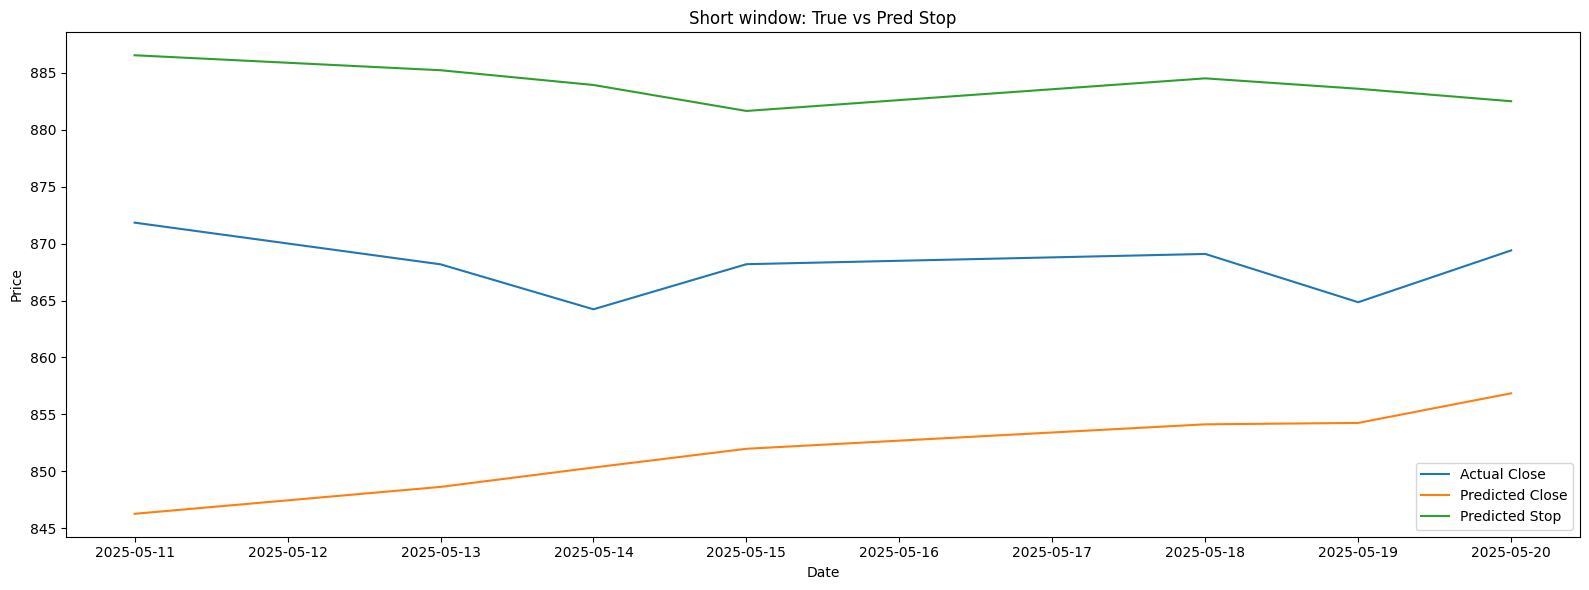

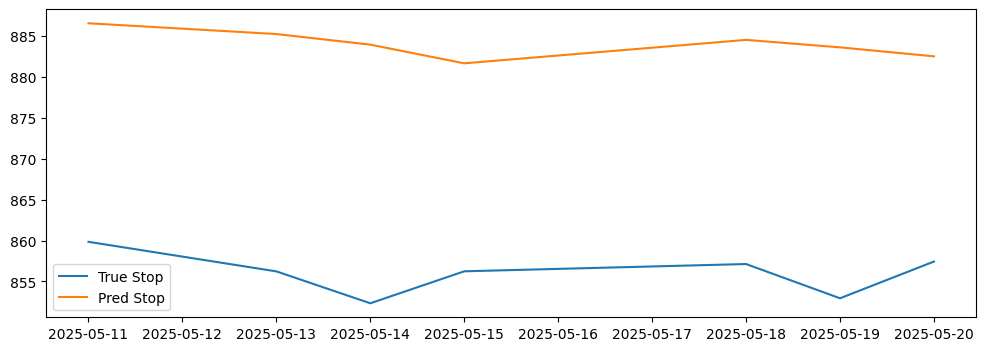

In [403]:
short = df.loc["2025-04-01":"2025-05-20"].copy()

out = plot_predictions_date_range(
    df=short,
    model=model,
    scaler=scaler,
    start="2025-05-10",
    end="2025-05-20",
    lookback=cfg.lookback_period,
    title="Short window: True vs Pred Stop"
)

plt.figure(figsize=(12,4))
plt.plot(out.index, short.loc[out.index, "stop_price"], label="True Stop")
plt.plot(out.index, out["pred_stop"], label="Pred Stop")
plt.legend()
plt.show()


In [404]:
df.head()

Open    High     Low   Close  Volume  price_change  \
Date                                                               
2021-01-03  1235.0  1304.0  1225.0  1302.0     0.0           1.0   
2021-01-04  1320.0  1346.0  1270.0  1291.0     0.0          -0.1   
2021-01-05  1250.0  1306.0  1250.0  1275.0     0.0          -0.1   
2021-01-06  1300.0  1300.0  1277.0  1288.0     0.0           0.1   
2021-01-07  1282.0  1295.0  1263.0  1268.0     0.0          -0.3   

            momentum_rsi  trend_sma_fast          wma  momentum  ...  pr_macd  \
Date                                                             ...            
2021-01-03     34.666667          1279.2  1278.800000     -52.0  ...        1   
2021-01-04     34.228188          1284.4  1275.600000     -49.0  ...        1   
2021-01-05     36.156352          1289.3  1275.290909     -57.0  ...       -1   
2021-01-06     36.393443          1295.0  1278.927273     -52.0  ...        1   
2021-01-07     37.012987          1300.2  1281.145455    -126.0  ...       -1   

            pr_rsi  pr_cci  pr_ad  pr_moment  trend_hh  trend_hl  trend_lh  \
Date                                                                         
2021-01-03       1       1      1         -1         0         0         1   
2021-01-04      -1       1     -1         -1         0         0         1   
2021-01-05      -1       1     -1         -1         0         0         0   
2021-01-06      -1       1      1         -1         0         0         1   
2021-01-07       1       1     -1         -1         0         0         1   

            trend   stop_price  
Date                            
2021-01-03   11.0  1284.085490  
2021-01-04   16.0  1273.236841  
2021-01-05  -13.0  1257.456989  
2021-01-06   20.0  1270.278119  
2021-01-07   13.0  1250.553303  

[5 rows x 34 columns]

Adding stop price
[886.5395  885.2251  883.92896 881.6478  884.5116  883.5985  882.501  ]
[877.80360228 864.07513069 863.75953364 861.68842801 850.17899816
 895.84888905 864.08499309 859.84415776 856.23451652 852.33886546
 856.24437893 857.13199563 852.95033474 857.43773027]


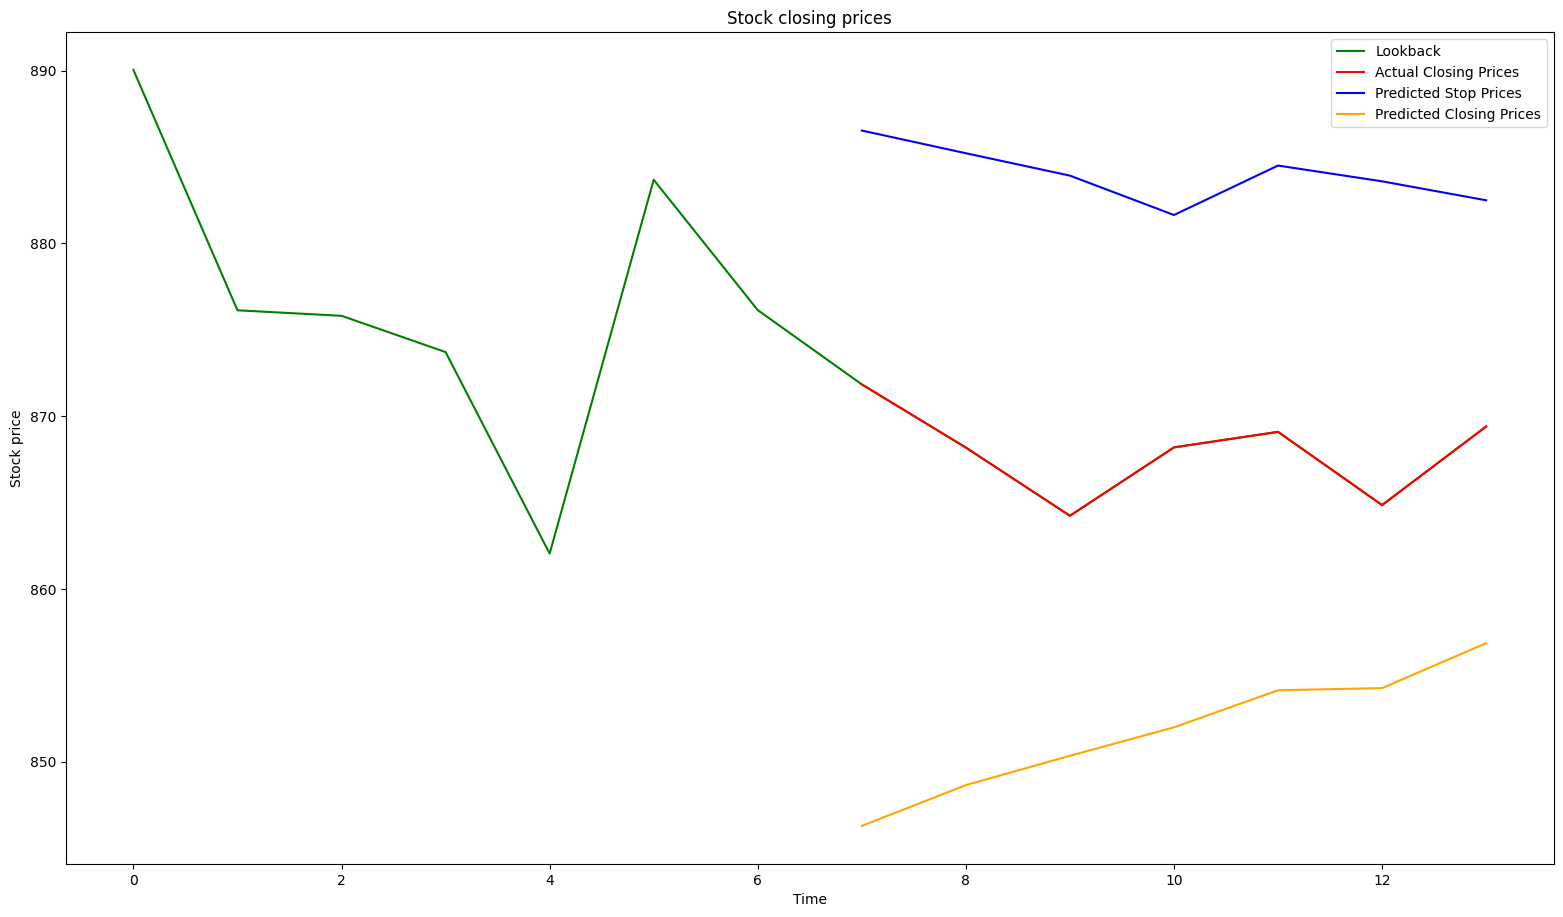

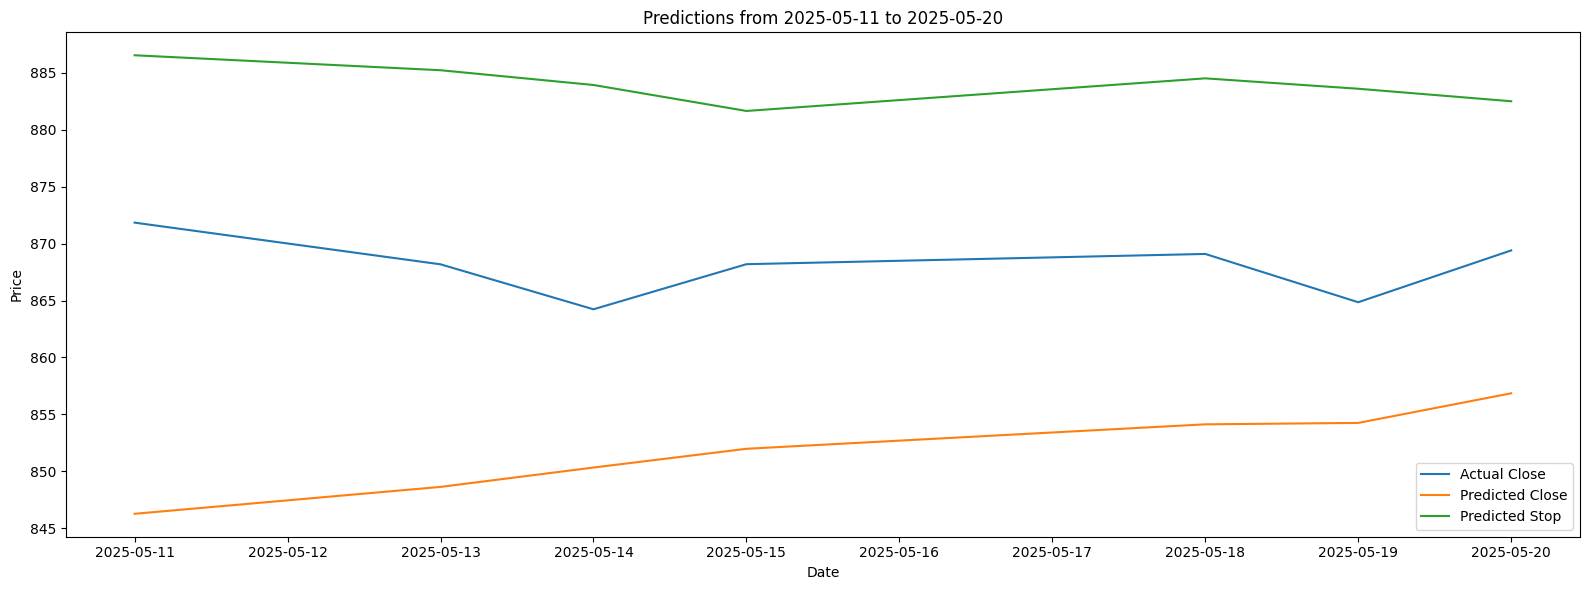

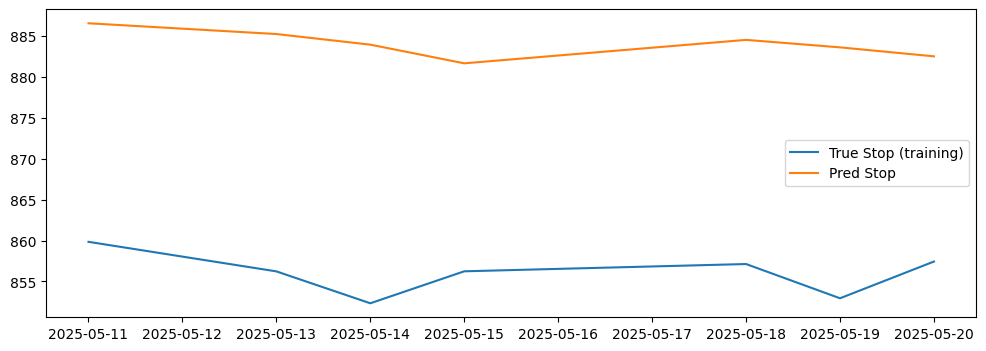

In [405]:
# stop_price must be computed ONCE on full df
df_full = df.copy()
df_full = add_stop_price(df_full, trade_window=10, alpha=stop_alpha)

# then slice
short = df_full.loc["2025-04-25":"2025-05-20"].copy()

# plot true vs pred
out = plot_predictions_date_range(
    df=short,
    model=model,
    scaler=scaler,
    start="2025-05-11",
    end="2025-05-20",
    lookback=cfg.lookback_period,
)

plt.figure(figsize=(12,4))
plt.plot(out.index, short.loc[out.index, "stop_price"], label="True Stop (training)")
plt.plot(out.index, out["pred_stop"], label="Pred Stop")
plt.legend()
plt.show()


In [406]:
# If this prints ~random-ish and changes after training, you're good.
# If it's the same every run, you might be plotting with an untrained model.
batch = next(iter(train_loader))
xb_price, xb_trend, xb_prev, yb_stop, yb_trend, yb_close = [t.to(cfg.device) for t in batch]

model.eval()
with torch.no_grad():
    stop_pred, trend_pred, price_pred = model(xb_price, xb_trend, xb_prev)

print("stop_pred (scaled) min/max:", stop_pred.min().item(), stop_pred.max().item())


stop_pred (scaled) min/max: -0.5067530274391174 -0.09761597216129303


In [407]:
model.train()
xb_price, xb_trend, xb_prev, yb_stop, yb_trend, yb_close = [t.to(cfg.device) for t in batch]
stop_pred, trend_pred, price_pred = model(xb_price, xb_trend, xb_prev)

loss_stop  = mse(stop_pred, yb_stop).item()
loss_price = mse(price_pred, yb_close).item()
loss_trend = trend_custom_loss(yb_trend, trend_pred, alpha=cfg.trend_dir_penalty).item()

print("loss_stop :", loss_stop)
print("loss_price:", loss_price)
print("loss_trend:", loss_trend)


loss_stop : 0.022071778774261475
loss_price: 0.0036703457590192556
loss_trend: 0.032736778259277344


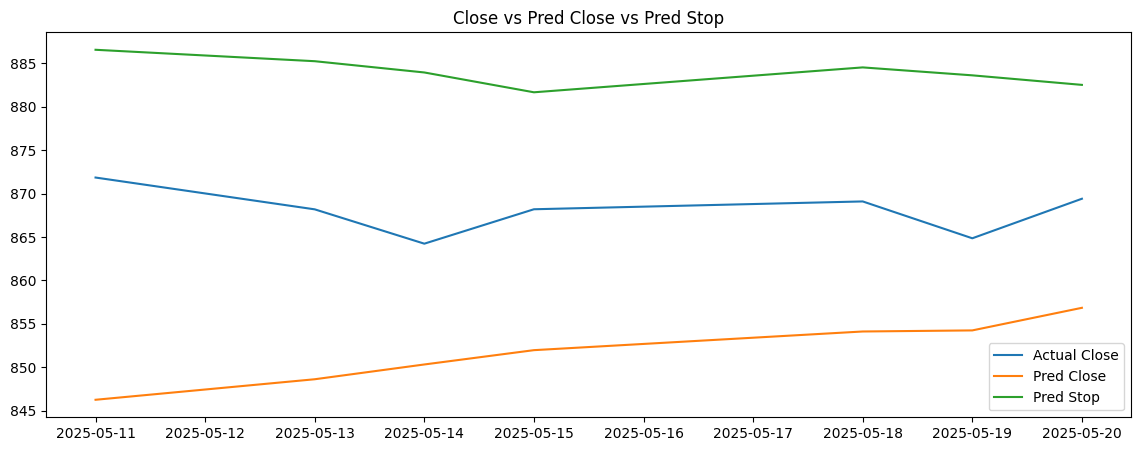

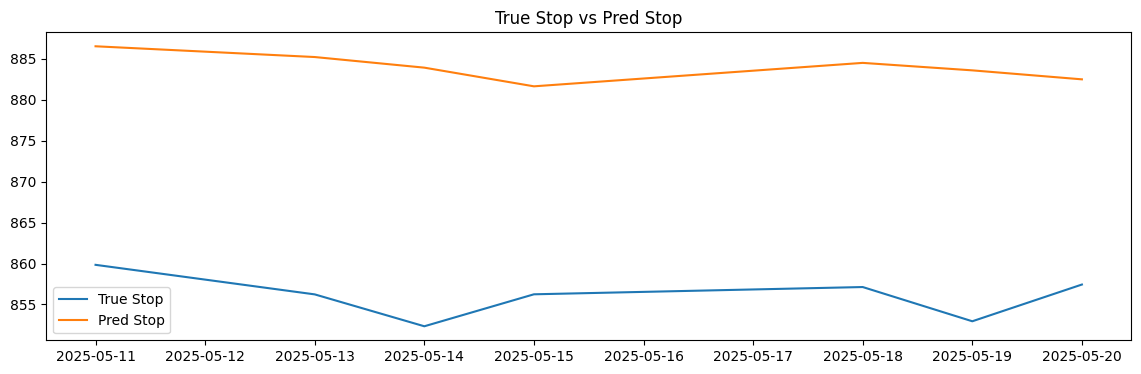

In [408]:
# out is your returned dataframe from plot_predictions_date_range(...)
# (actual_close, pred_close, pred_stop)

plt.figure(figsize=(14,5))
plt.plot(out.index, out["actual_close"], label="Actual Close")
plt.plot(out.index, out["pred_close"], label="Pred Close")
plt.plot(out.index, out["pred_stop"], label="Pred Stop")
plt.legend()
plt.title("Close vs Pred Close vs Pred Stop")
plt.show()

# If you have true stop in df_full:
true_stop = df_full.loc[out.index, "stop_price"]
plt.figure(figsize=(14,4))
plt.plot(out.index, true_stop, label="True Stop")
plt.plot(out.index, out["pred_stop"], label="Pred Stop")
plt.legend()
plt.title("True Stop vs Pred Stop")
plt.show()


In [409]:
# pick a few scaled predictions
pred_scaled = stop_p[:5].reshape(-1)  # scaled stop preds from torch_test()

# the *true* scaled stop values at the same points (from aligned scaled data)
# In torch_test you have scaled = scaler.transform(test_df_aligned.values)
# So get the matching true scaled stop column:
stop_col_idx = col_to_idx["stop_price"]
scaled = scaler.transform(test_df.values.astype(np.float32))
true_scaled = scaled[lookback_period:, stop_col_idx][:5]

print("pred_scaled:", pred_scaled)
print("true_scaled:", true_scaled)

# --- inverse scaling (single-column trick) ---
def inverse_column(pred, col):
    dummy = np.zeros((pred.shape[0], len(test_df.columns)), dtype=np.float32)
    dummy[:, col_to_idx[col]] = pred.reshape(-1)
    return scaler.inverse_transform(dummy)[:, col_to_idx[col]]
# inverse using your helper
inv_pred = inverse_column(stop_p[:5], "stop_price")
print("inv_pred:", inv_pred)

# now inverse the true_scaled to verify scaler correctness
dummy = np.zeros((5, len(all_cols)), dtype=np.float32)
dummy[:, stop_col_idx] = true_scaled
inv_true = scaler.inverse_transform(dummy)[:, stop_col_idx]
print("inv_true:", inv_true)

# also print training min/max for stop_price
print("stop_price scaler min/max:", scaler.min_[stop_col_idx], scaler.max_[stop_col_idx])


pred_scaled: [-0.5261051  -0.5232822  -0.52490664 -0.5313262  -0.53678966]
true_scaled: [-0.66214365 -0.67204297 -0.6694808  -0.6628424  -0.6651716 ]
inv_pred: [961.98846 964.379   963.0034  957.56714 952.9404 ]
inv_true: [846.7863  838.4032  840.573   846.1946  844.22217]
stop_price scaler min/max: 560.67786 2254.3472


stop_price min/max: 747.5705078697108 1803.477660289953
stop_price percentiles: [ 768.37032583  799.84126897  890.57542032 1411.13408315 1649.79450903]


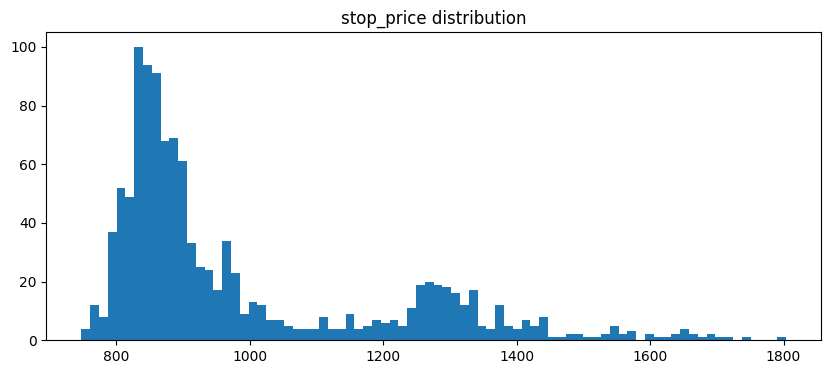

In [410]:
s = df_full["stop_price"].dropna()
print("stop_price min/max:", s.min(), s.max())
print("stop_price percentiles:", np.percentile(s, [1,5,50,95,99]))

plt.figure(figsize=(10,4))
plt.hist(s, bins=80)
plt.title("stop_price distribution")
plt.show()


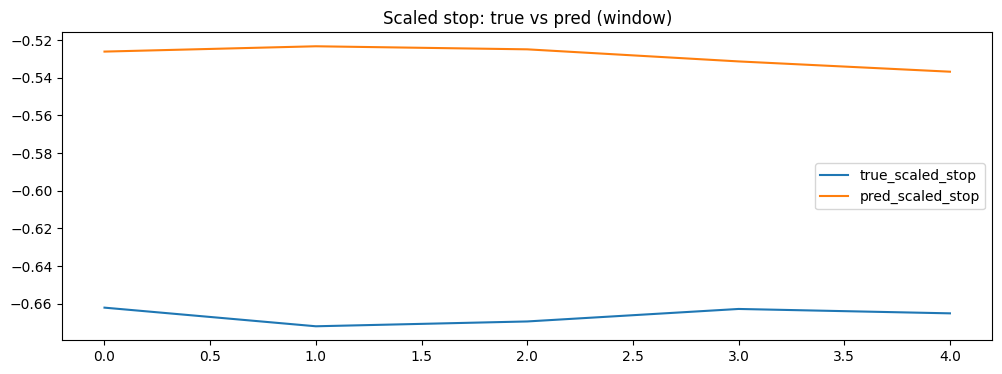

In [411]:
plt.figure(figsize=(12,4))
plt.plot(true_scaled, label="true_scaled_stop")
plt.plot(pred_scaled, label="pred_scaled_stop")
plt.legend()
plt.title("Scaled stop: true vs pred (window)")
plt.show()


In [412]:
print("loss_stop :", loss_stop)
print("loss_price:", loss_price)
print("loss_trend:", loss_trend, "weighted:", 0.01*loss_trend)


loss_stop : 0.022071778774261475
loss_price: 0.0036703457590192556
loss_trend: 0.032736778259277344 weighted: 0.0003273677825927734


stop_delta percentiles: [-0.01375922 -0.01375922 -0.01375922  0.01375922  0.01375922]


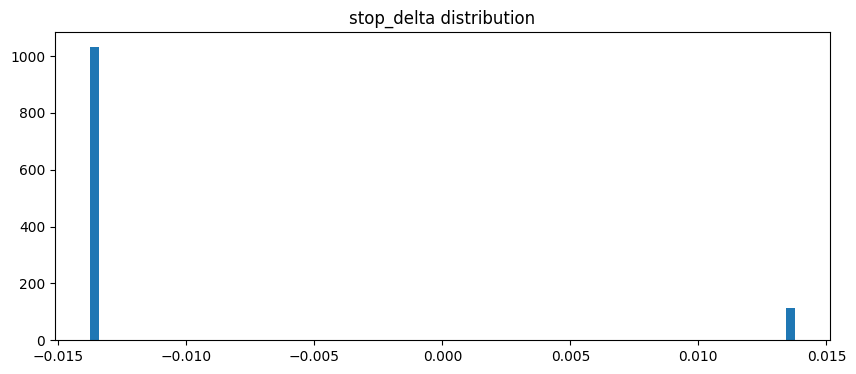

In [413]:
delta = (df_full["stop_price"] - df_full["Close"]) / df_full["Close"]
print("stop_delta percentiles:", np.percentile(delta.dropna(), [1,5,50,95,99]))

plt.figure(figsize=(10,4))
plt.hist(delta.dropna(), bins=80)
plt.title("stop_delta distribution")
plt.show()


In [414]:
import os, json, inspect, re

print("Notebook check:")
print("Contains stop_sign variable in globals:", "stop_sign" in globals())
print("ALPHA in globals:", "ALPHA" in globals(), "value:", globals().get("ALPHA", None))


Notebook check:
Contains stop_sign variable in globals: False
ALPHA in globals: True value: 0.0001
